In [14]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models_sigmoid_sum_minor2 import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader

from PIL import Image, ImageDraw

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库

print('Init Finished!')

Init Finished!


In [5]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 512

In [6]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def load_model(model_path):
    model = resnet_cifar(depth=args_depth, num_classes=num_classes)
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
#     print('Successfully Load Model: ', os.path.basename(model_path))
    print('Successfully Load Model: ', model_path)
    return model

In [8]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

def get_weights(model):
    return model.module.lmask.get_channel_mask()
#     return model.module.lmask.mask

In [9]:
def predict_model(PATH, title, run_model=True):
    model = load_model(PATH)
    model.train(False)
    use_gpu = True
    epoch = 1
    phase = 'val'
    running_corrects = 0.0
    data_len = len(dataloaders[phase])
    # print(data_len)
    true_labels = []
    model_preds = []
    if run_model:
        for idx,data in enumerate(dataloaders[phase]):
            printF(idx, data_len)
            inputs,labels = data
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            #forward
            outputs, reg = model(inputs, labels, epoch)
            _, preds = torch.max(outputs.data, 1)
            # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
            # print ('group loss:',group_loss[0])
            y = labels.data
            batch_size = labels.data.shape[0]
            # print(y.resize_(batch_size,1))
            running_corrects += torch.sum(preds == y)
            # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
            epoch_acc = float(running_corrects) /dataset_sizes[phase]
            true_labels.extend(y.cpu().numpy())
            model_preds.extend(preds.cpu().numpy())
        print('%s top1 Acc:%.4f'%(phase,epoch_acc))
    
    #Draw weights
    weights = get_weights(model)
    weights = weights.cpu().detach().numpy()
    weights = np.transpose(weights)
#     print(weights.shape)
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111)
    im = ax.imshow(weights,cmap=plt.cm.jet)
    plt.colorbar(im,orientation='vertical')
    plt.title(title)
    plt.show()
    return true_labels, model_preds

In [19]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
def plot_confusion_matrix_and_text(cm, labels_name, true_labels, model_preds, title):
    plt.figure(figsize=(16,16),dpi=200)
    plt.subplot(221)
    plot_confusion_matrix(cm, labels_name, title)
    plt.subplot(222)
    
    text_img = Image.new('RGB', (350, 250), color = (255,255,255))
    d = ImageDraw.Draw(text_img)
    text_content = classification_report(true_labels, model_preds, target_names=labels_name)
    d.text((0,0), text_content, fill=(0,0,0))
    plt.imshow(text_img)
    plt.show()

In [20]:
def show_res(PATH, run_model=True):
    model_path = os.path.join(PATH, 'saved_model.pt')
    title = PATH.split('/')[-1]
    true_labels, model_preds = predict_model(model_path, title, run_model)
    cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
    plot_confusion_matrix_and_text(cm, labels_name, true_labels, model_preds, title)
    plt.show() 

# Algorithm1

# get_channel_mask show

In [12]:
def get_weights(model):
    return model.module.lmask.get_channel_mask()
#     return model.module.lmask.mask

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/TwoStep_Algorithm1_Clip_L11e_3_LimitChannelClass/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7442


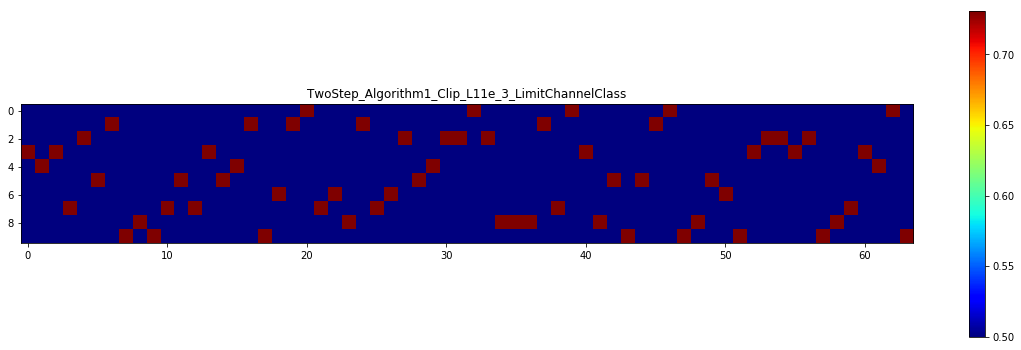

/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


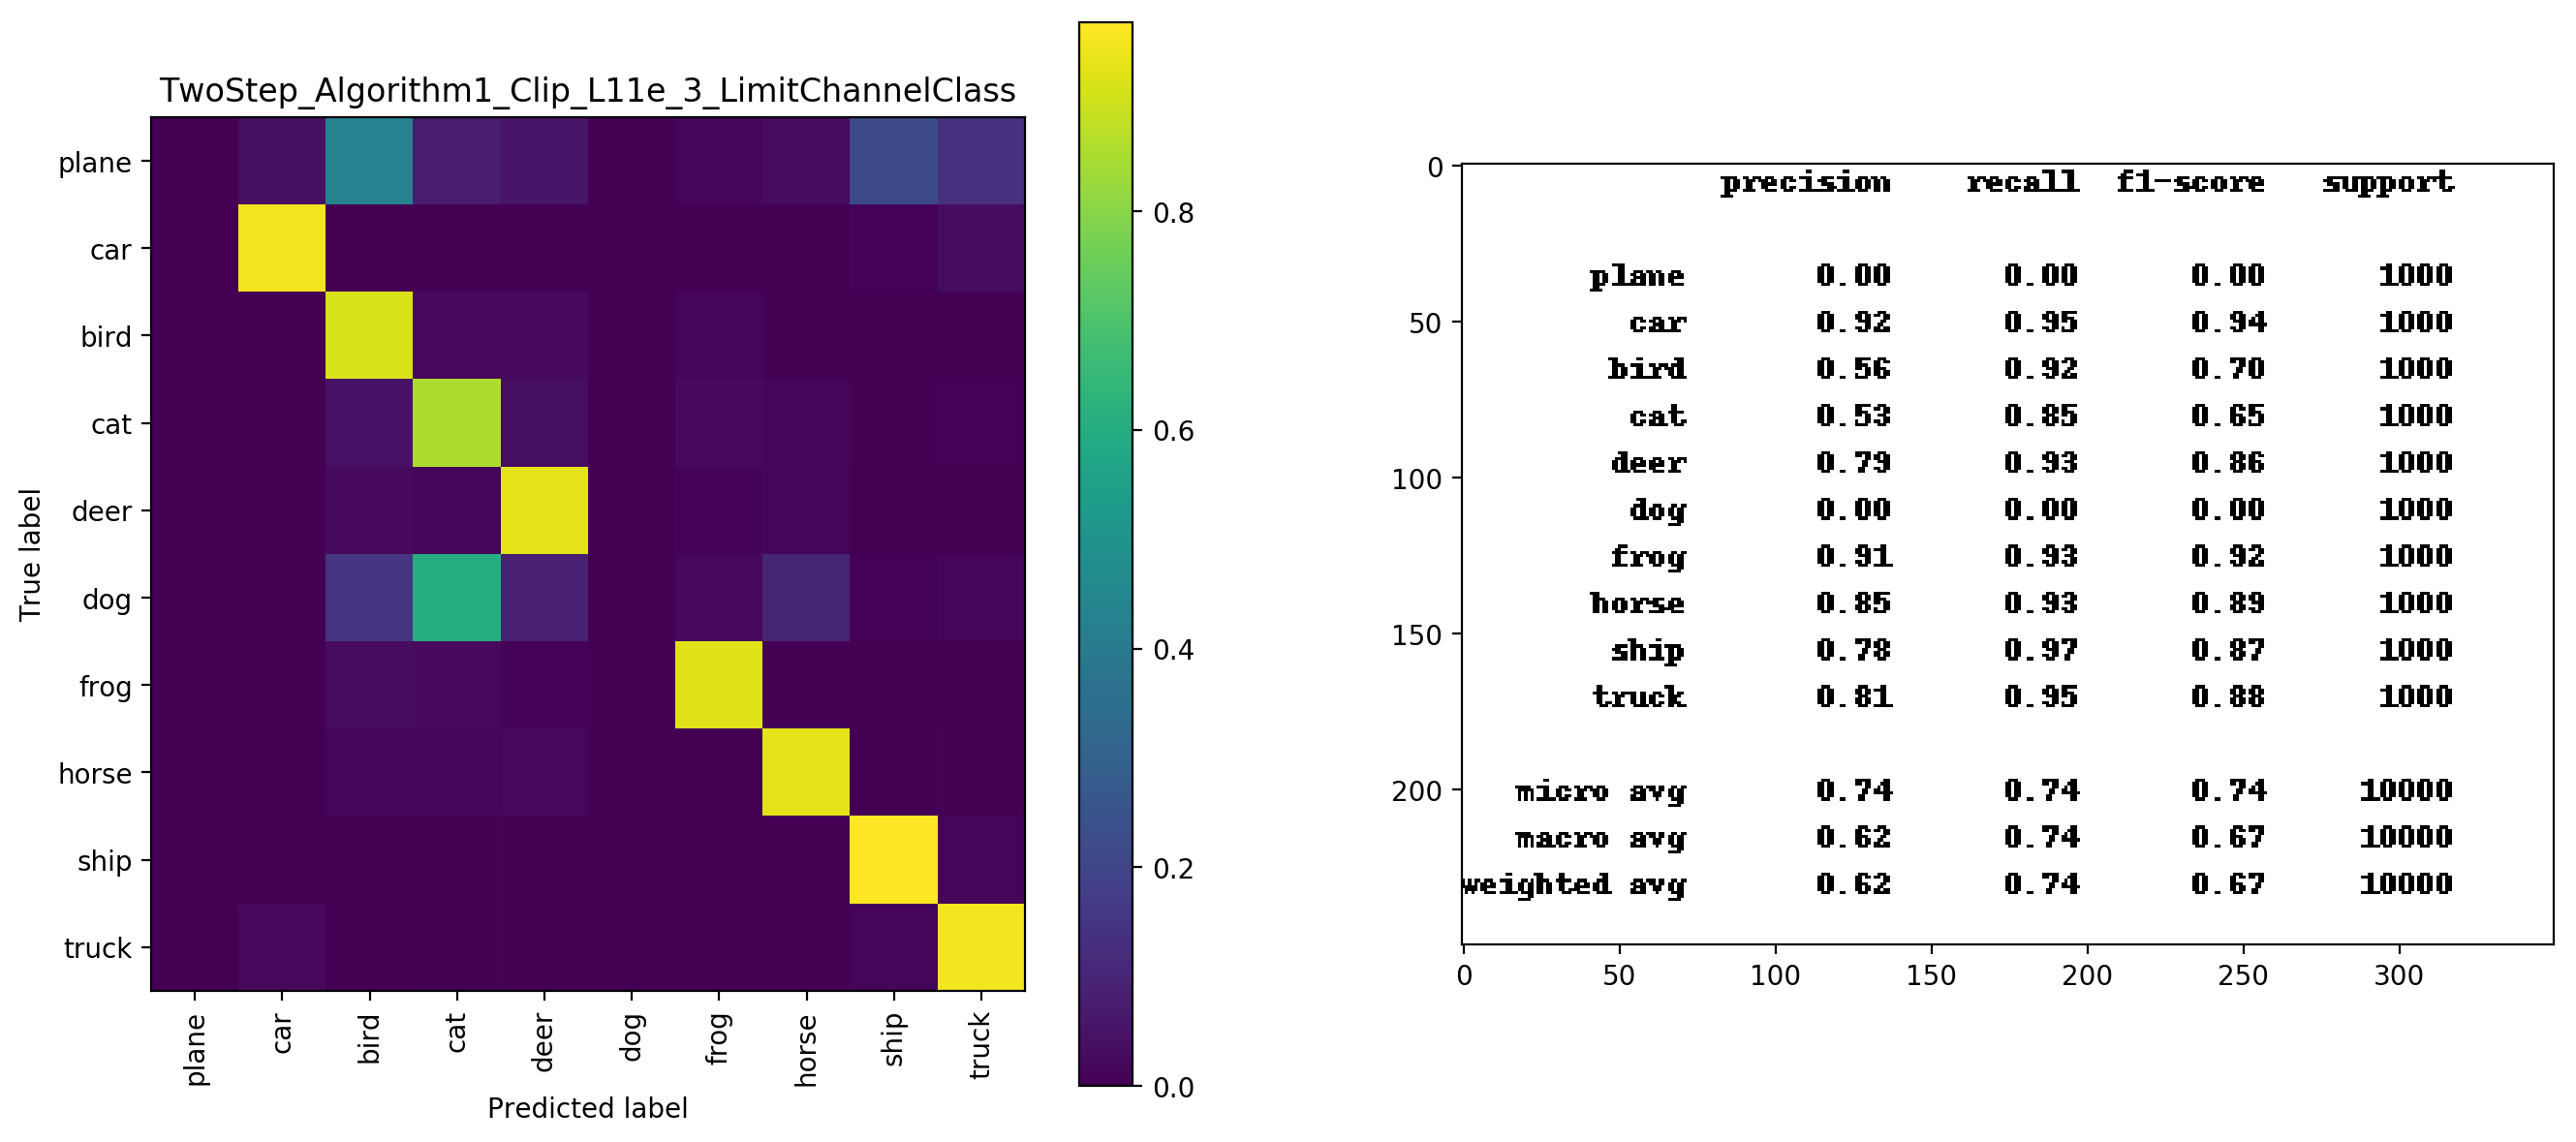

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/TwoStep_Algorithm1_Clip_L1_LimitChannelClass/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7451


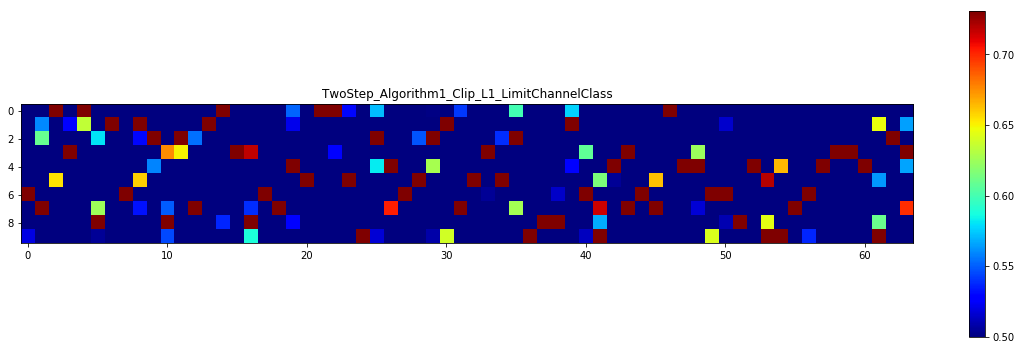

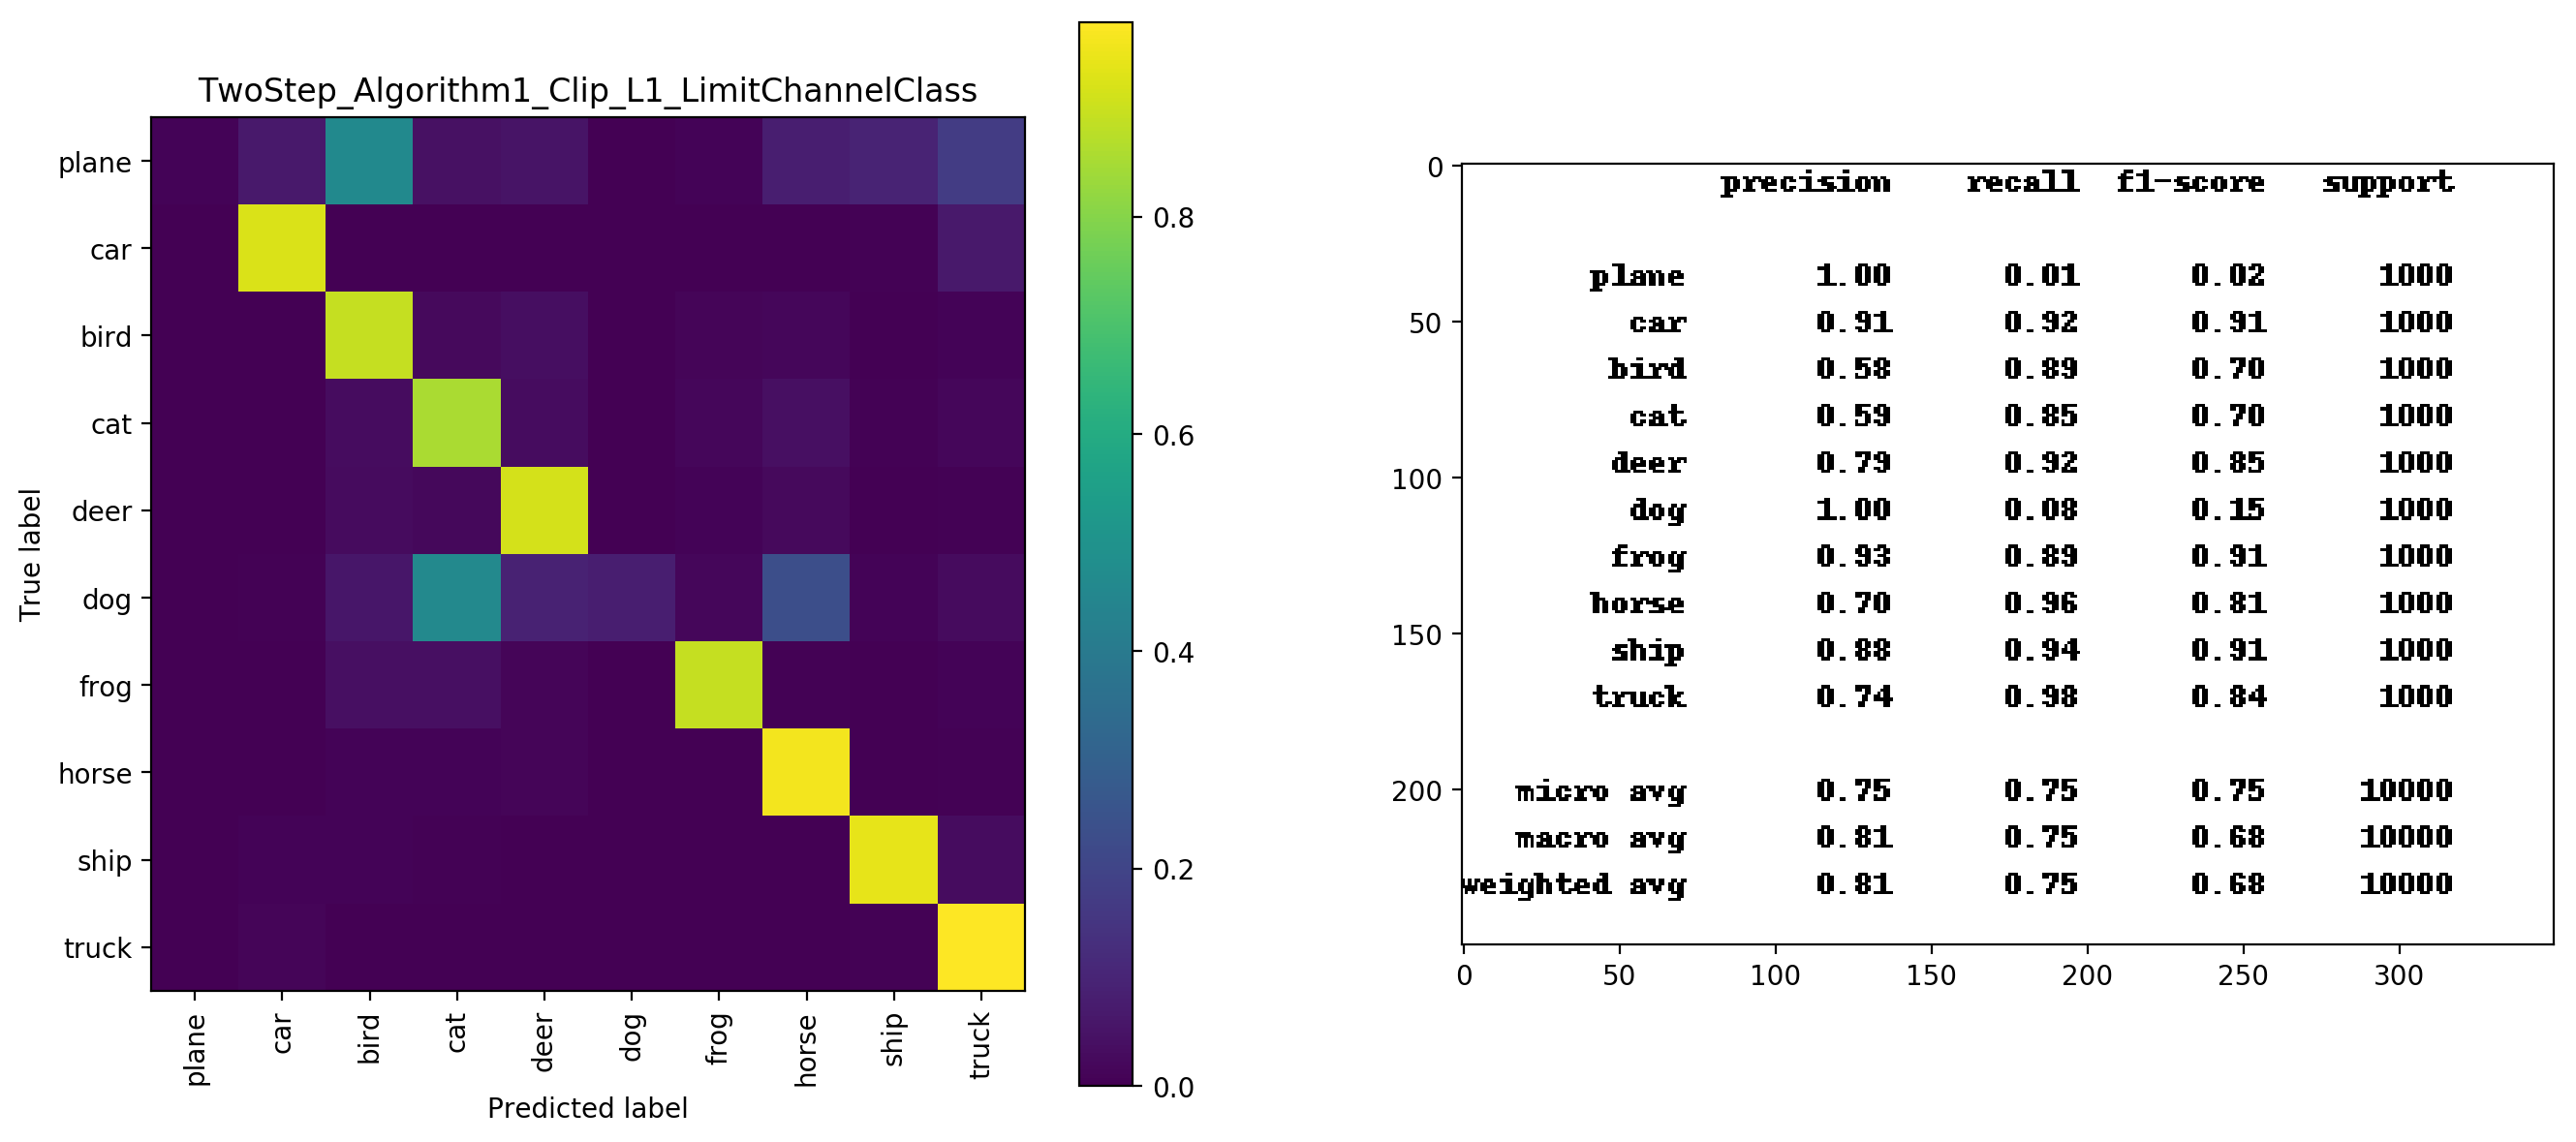

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/TwoStep_Algorithm1_Clip_L21_LimitChannelClass/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7690


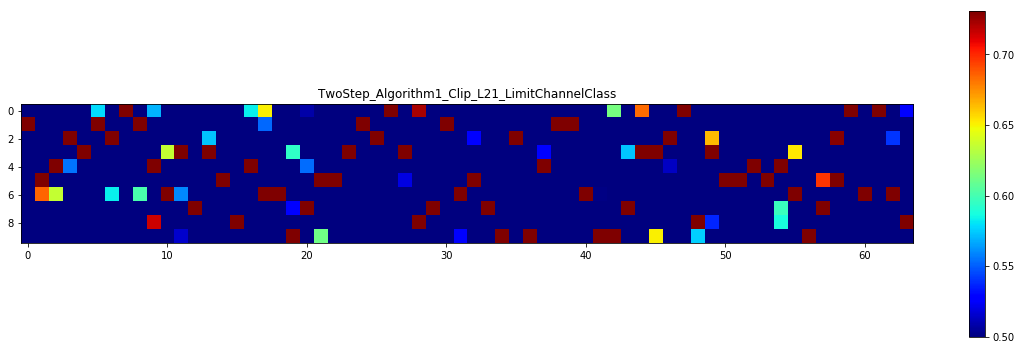

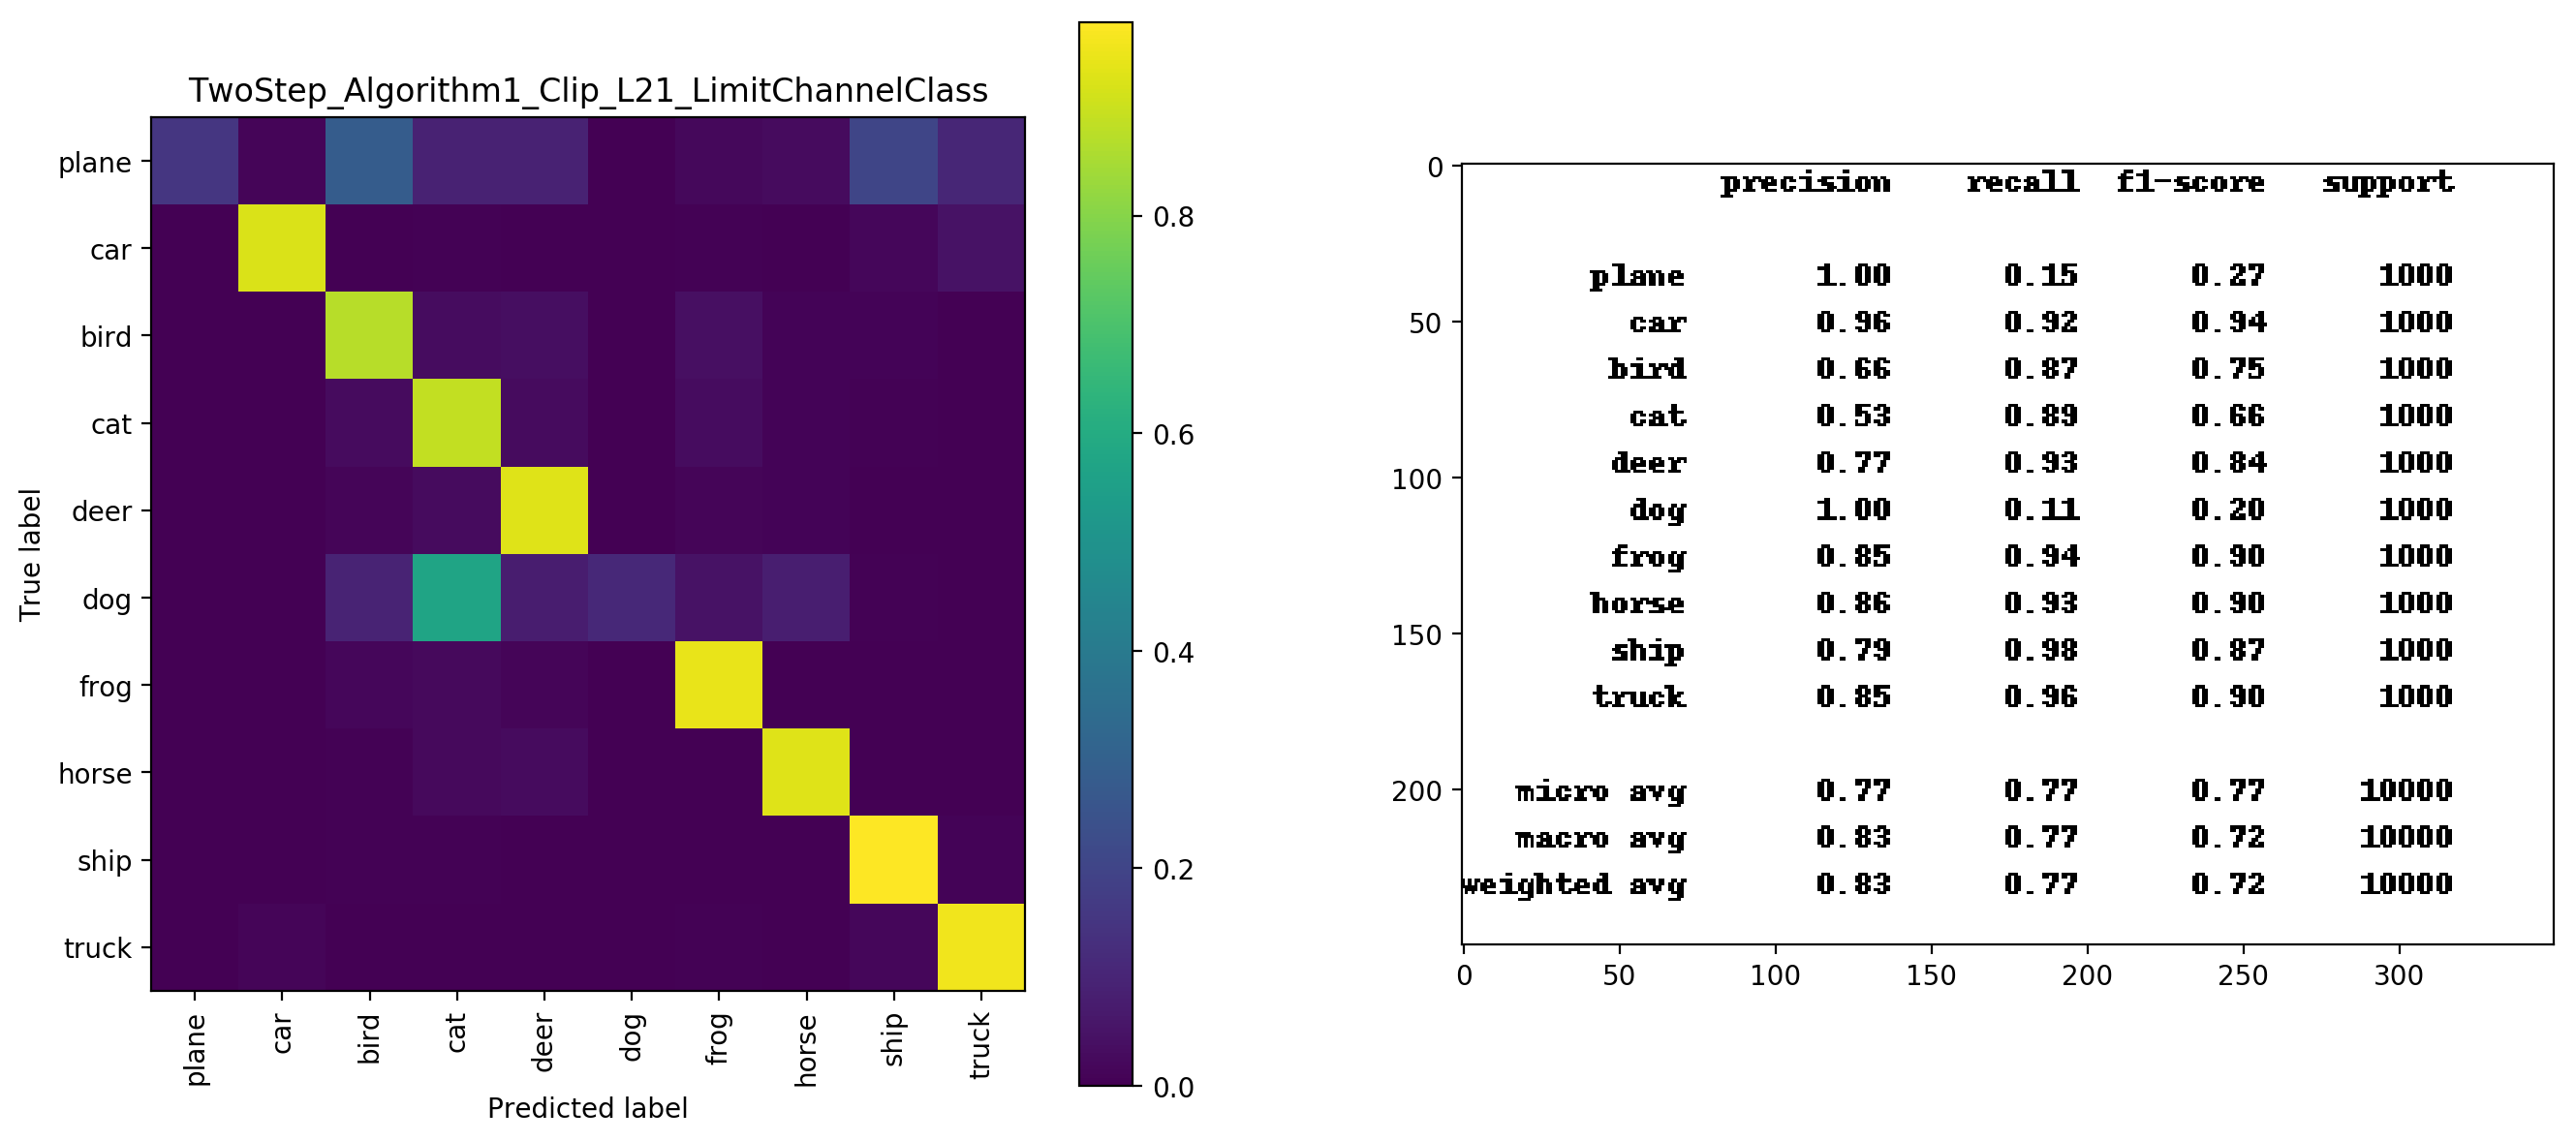

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/TwoStep_Algorithm1_Clip_Lmax_LimitChannelClass/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.8937


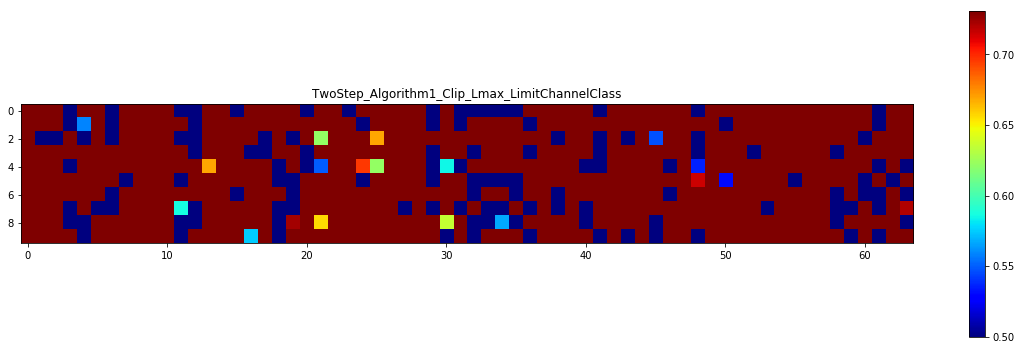

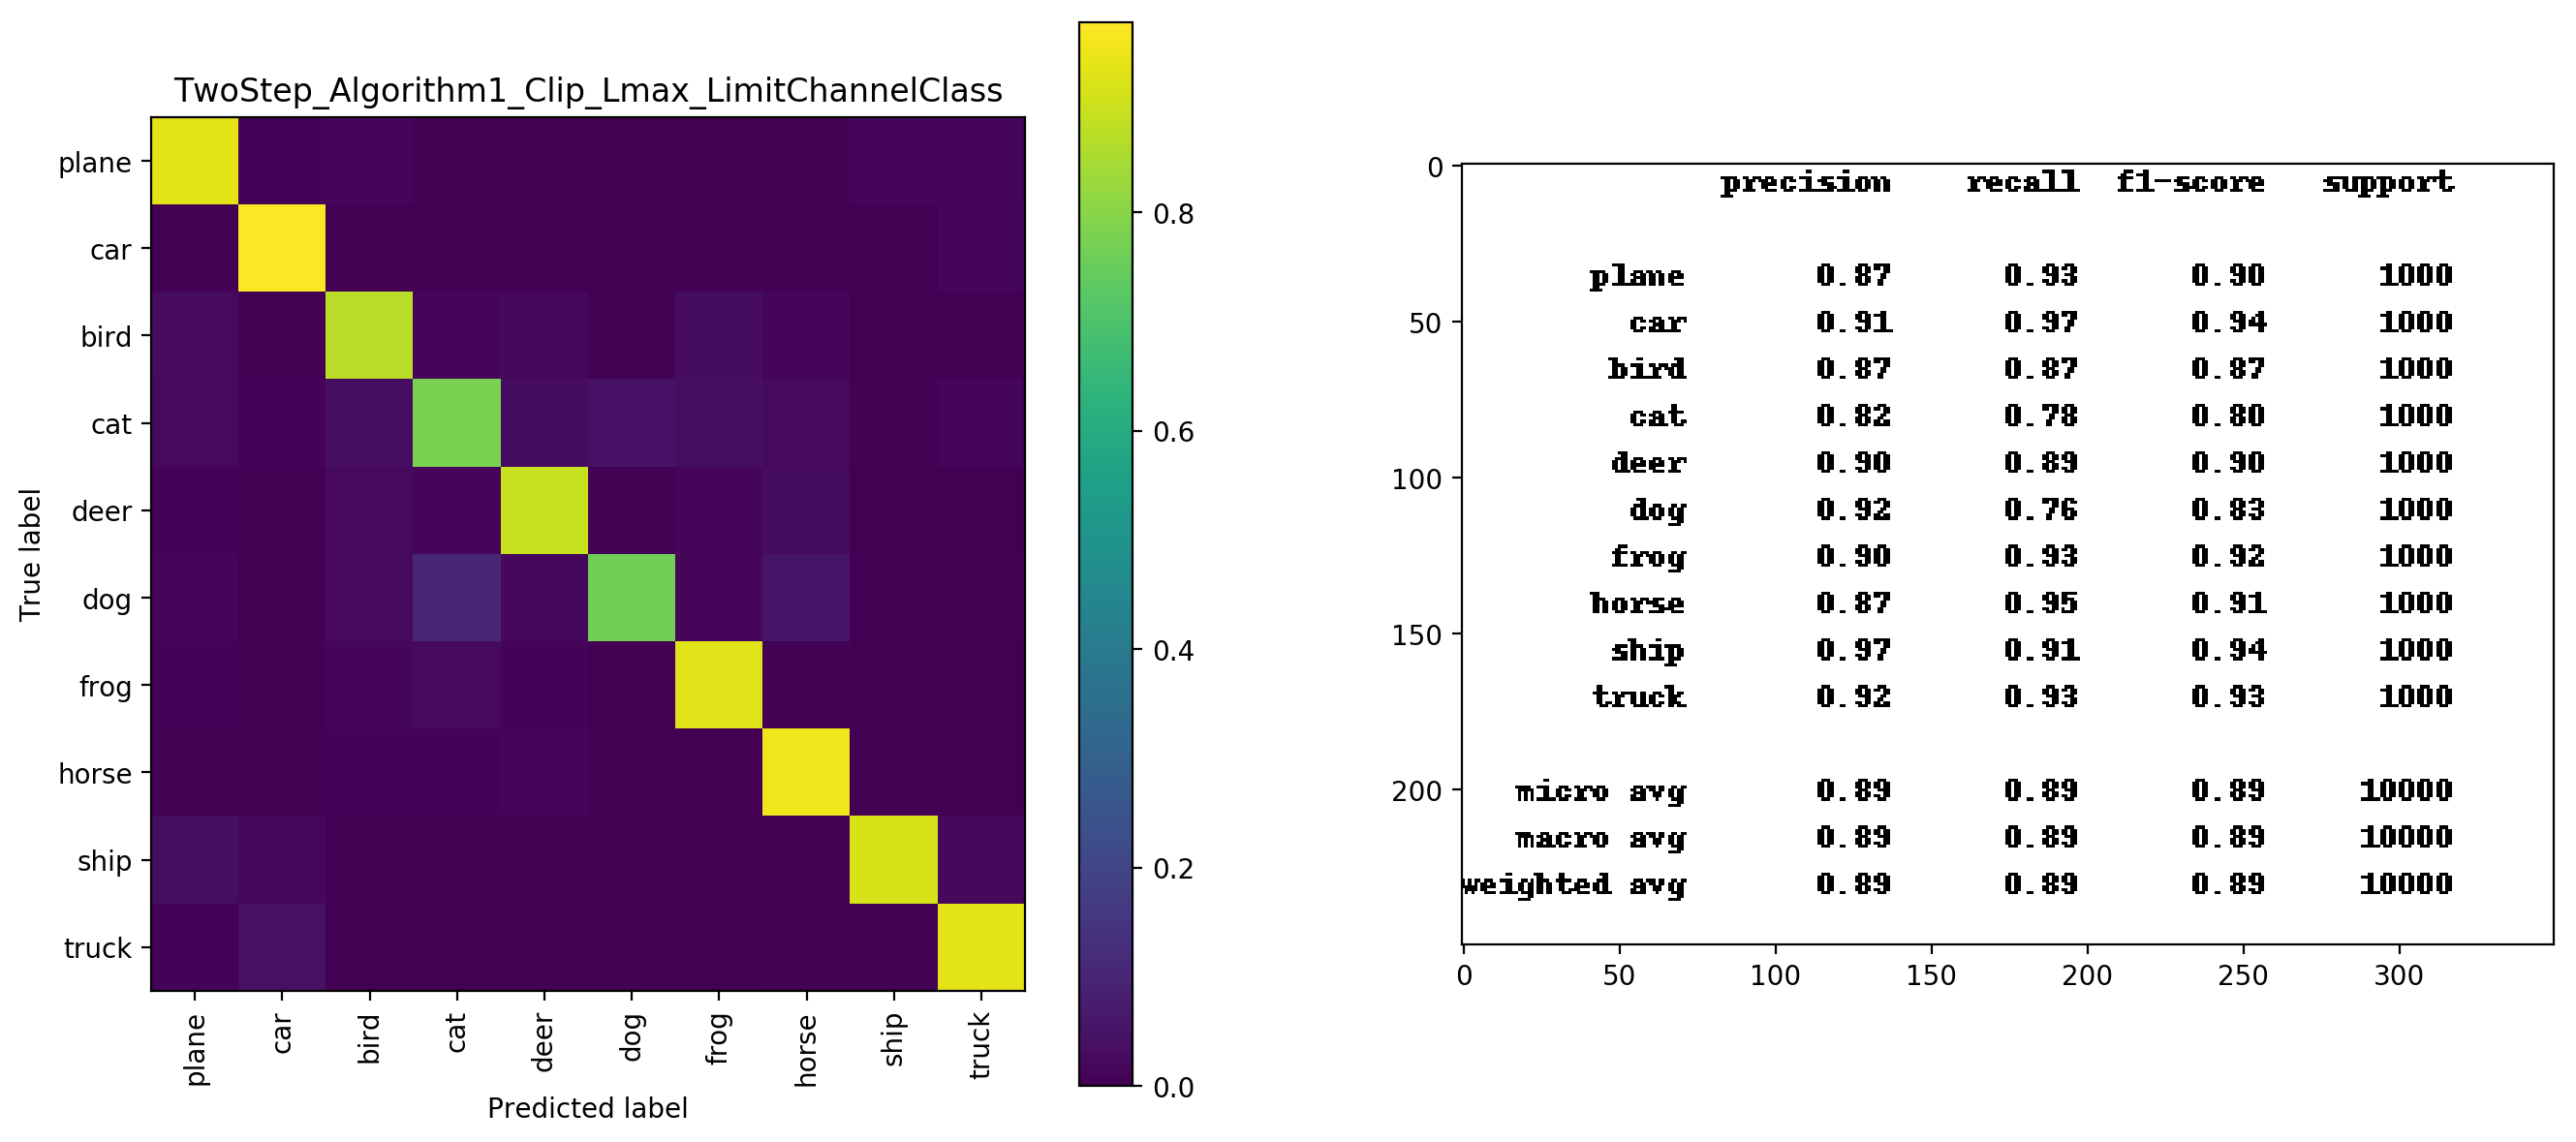

In [22]:
exp_root = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/'
analysis_queue = [
    'TwoStep_Algorithm1_Clip_L11e_3_LimitChannelClass',
    'TwoStep_Algorithm1_Clip_L1_LimitChannelClass',
    'TwoStep_Algorithm1_Clip_L21_LimitChannelClass',
    'TwoStep_Algorithm1_Clip_Lmax_LimitChannelClass',
]
analysis_queue = [exp_root+var for var in analysis_queue]
for item in analysis_queue:
    show_res(item)

# Show self.mask instead of sigmoid(self.mask)

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/TwoStep_Algorithm1_Clip_L11e_3_LimitChannelClass/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7442


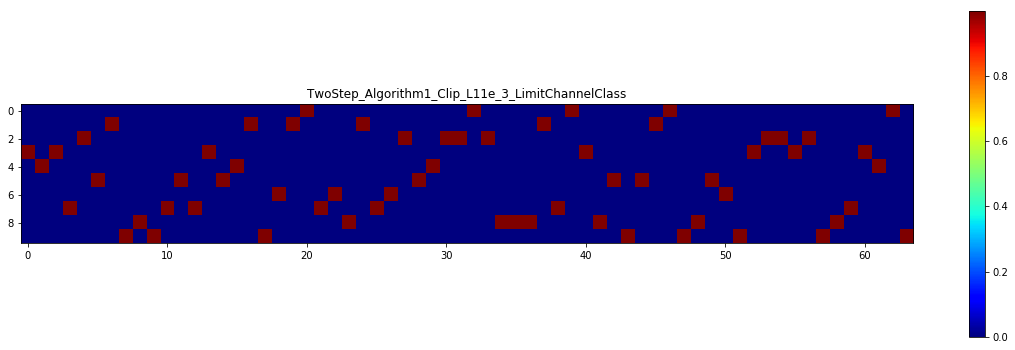

/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


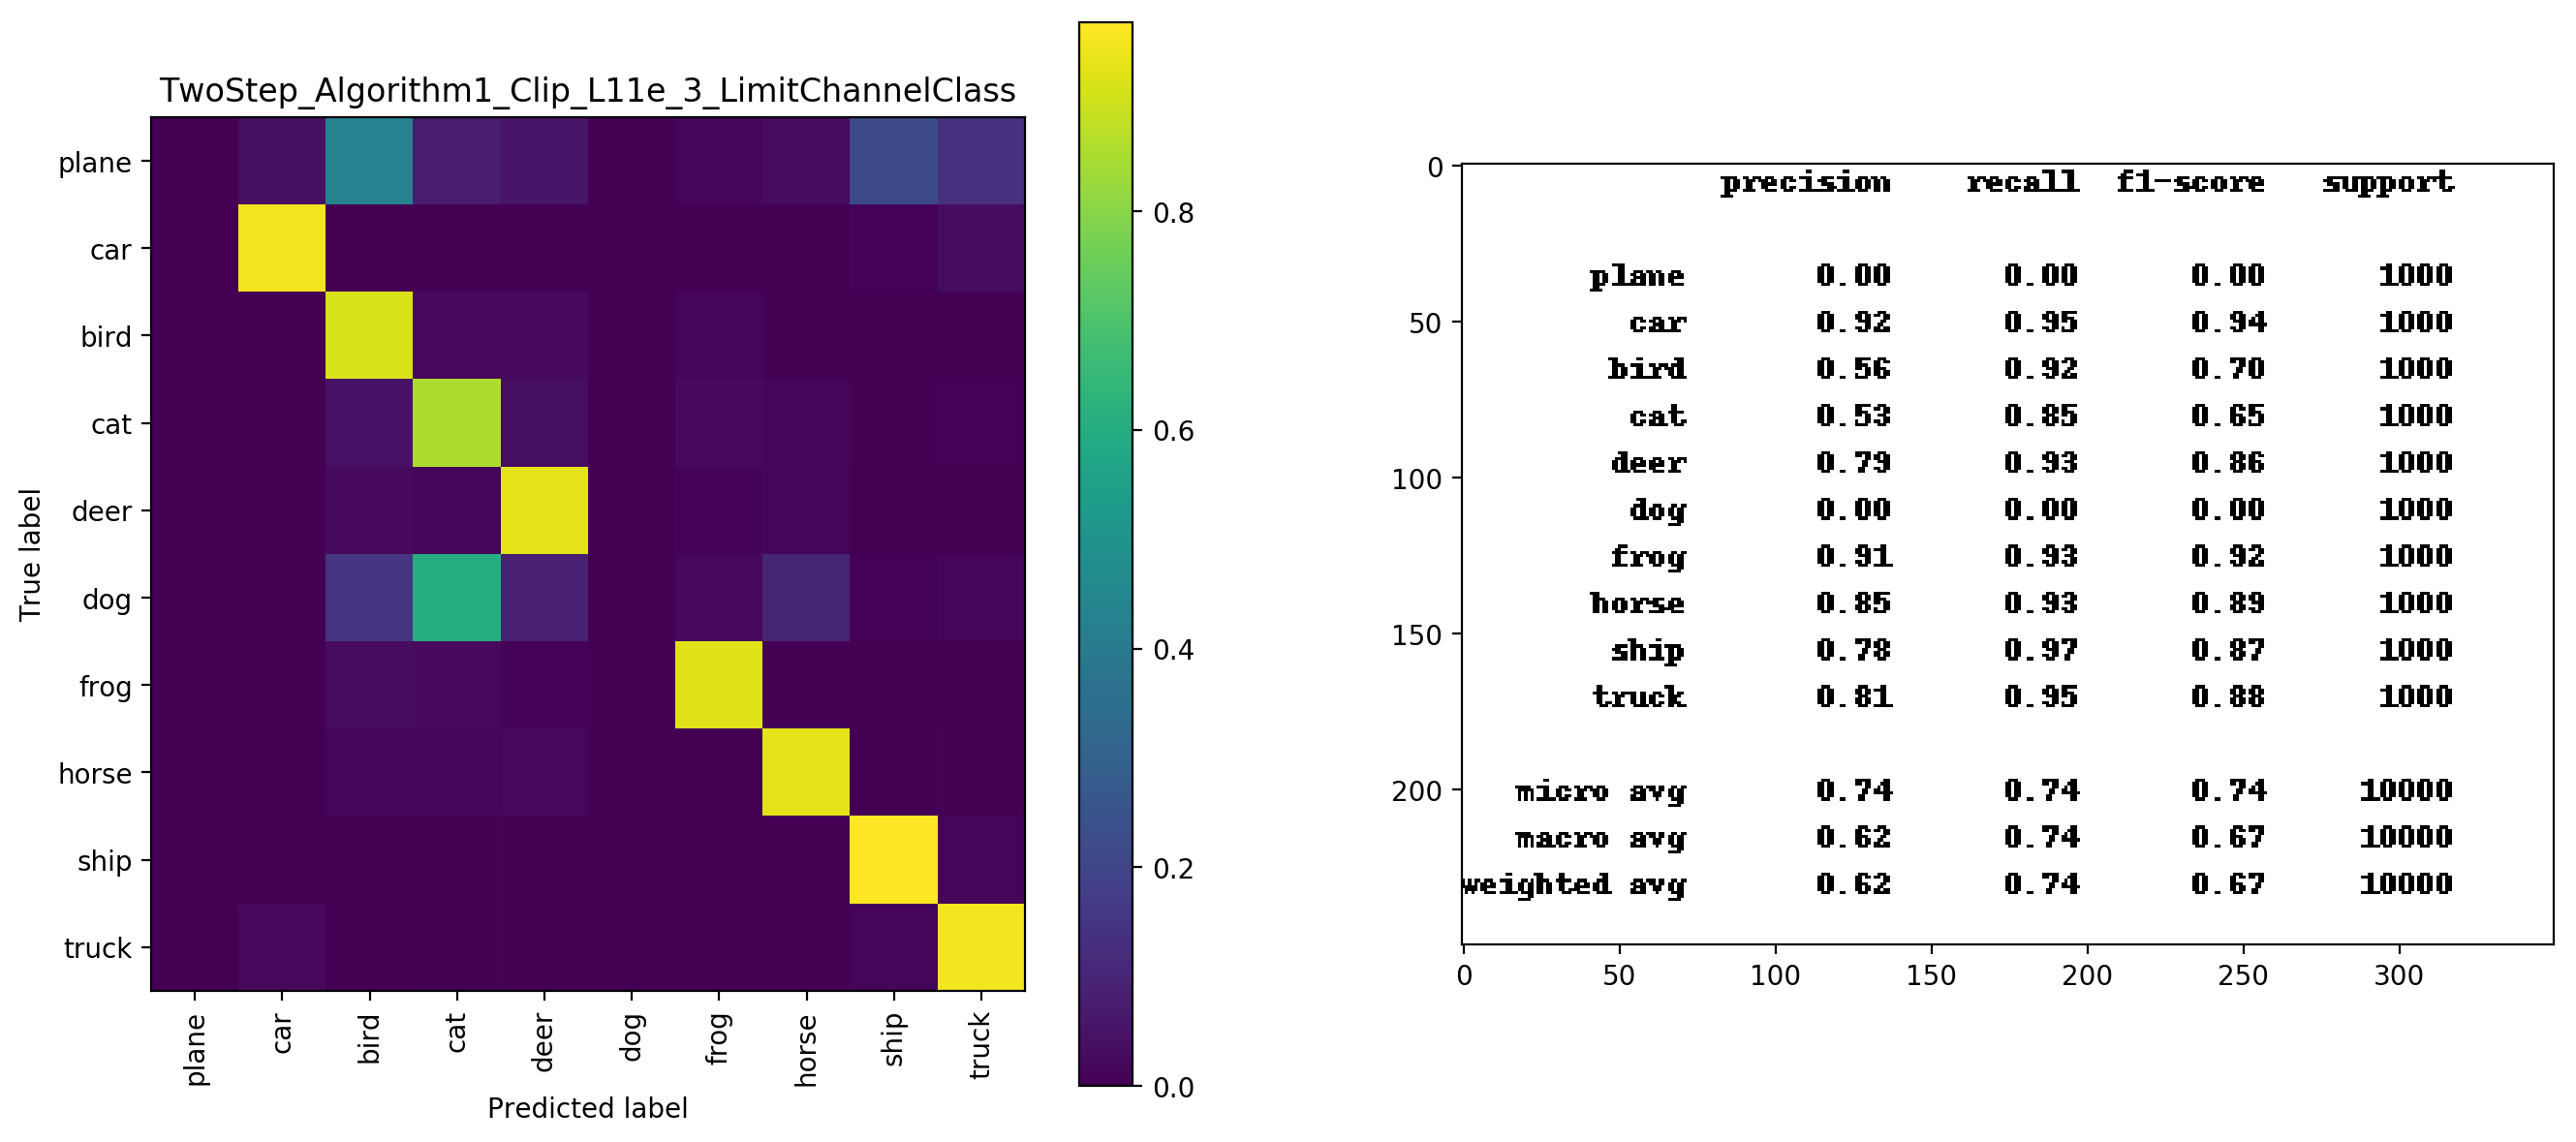

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/TwoStep_Algorithm1_Clip_L1_LimitChannelClass/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7451


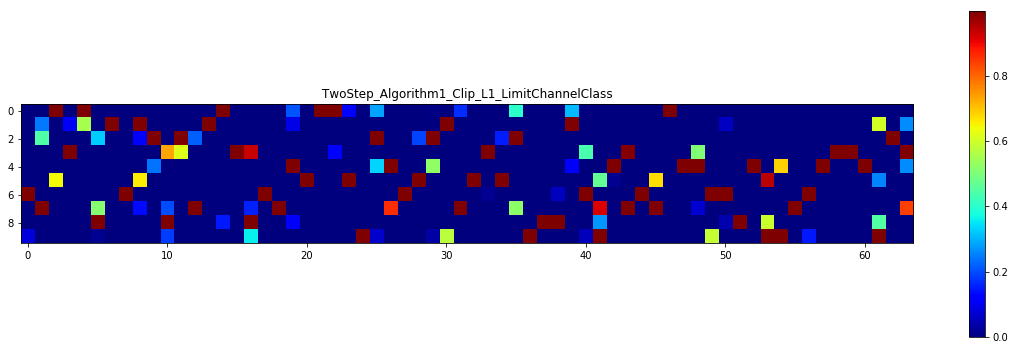

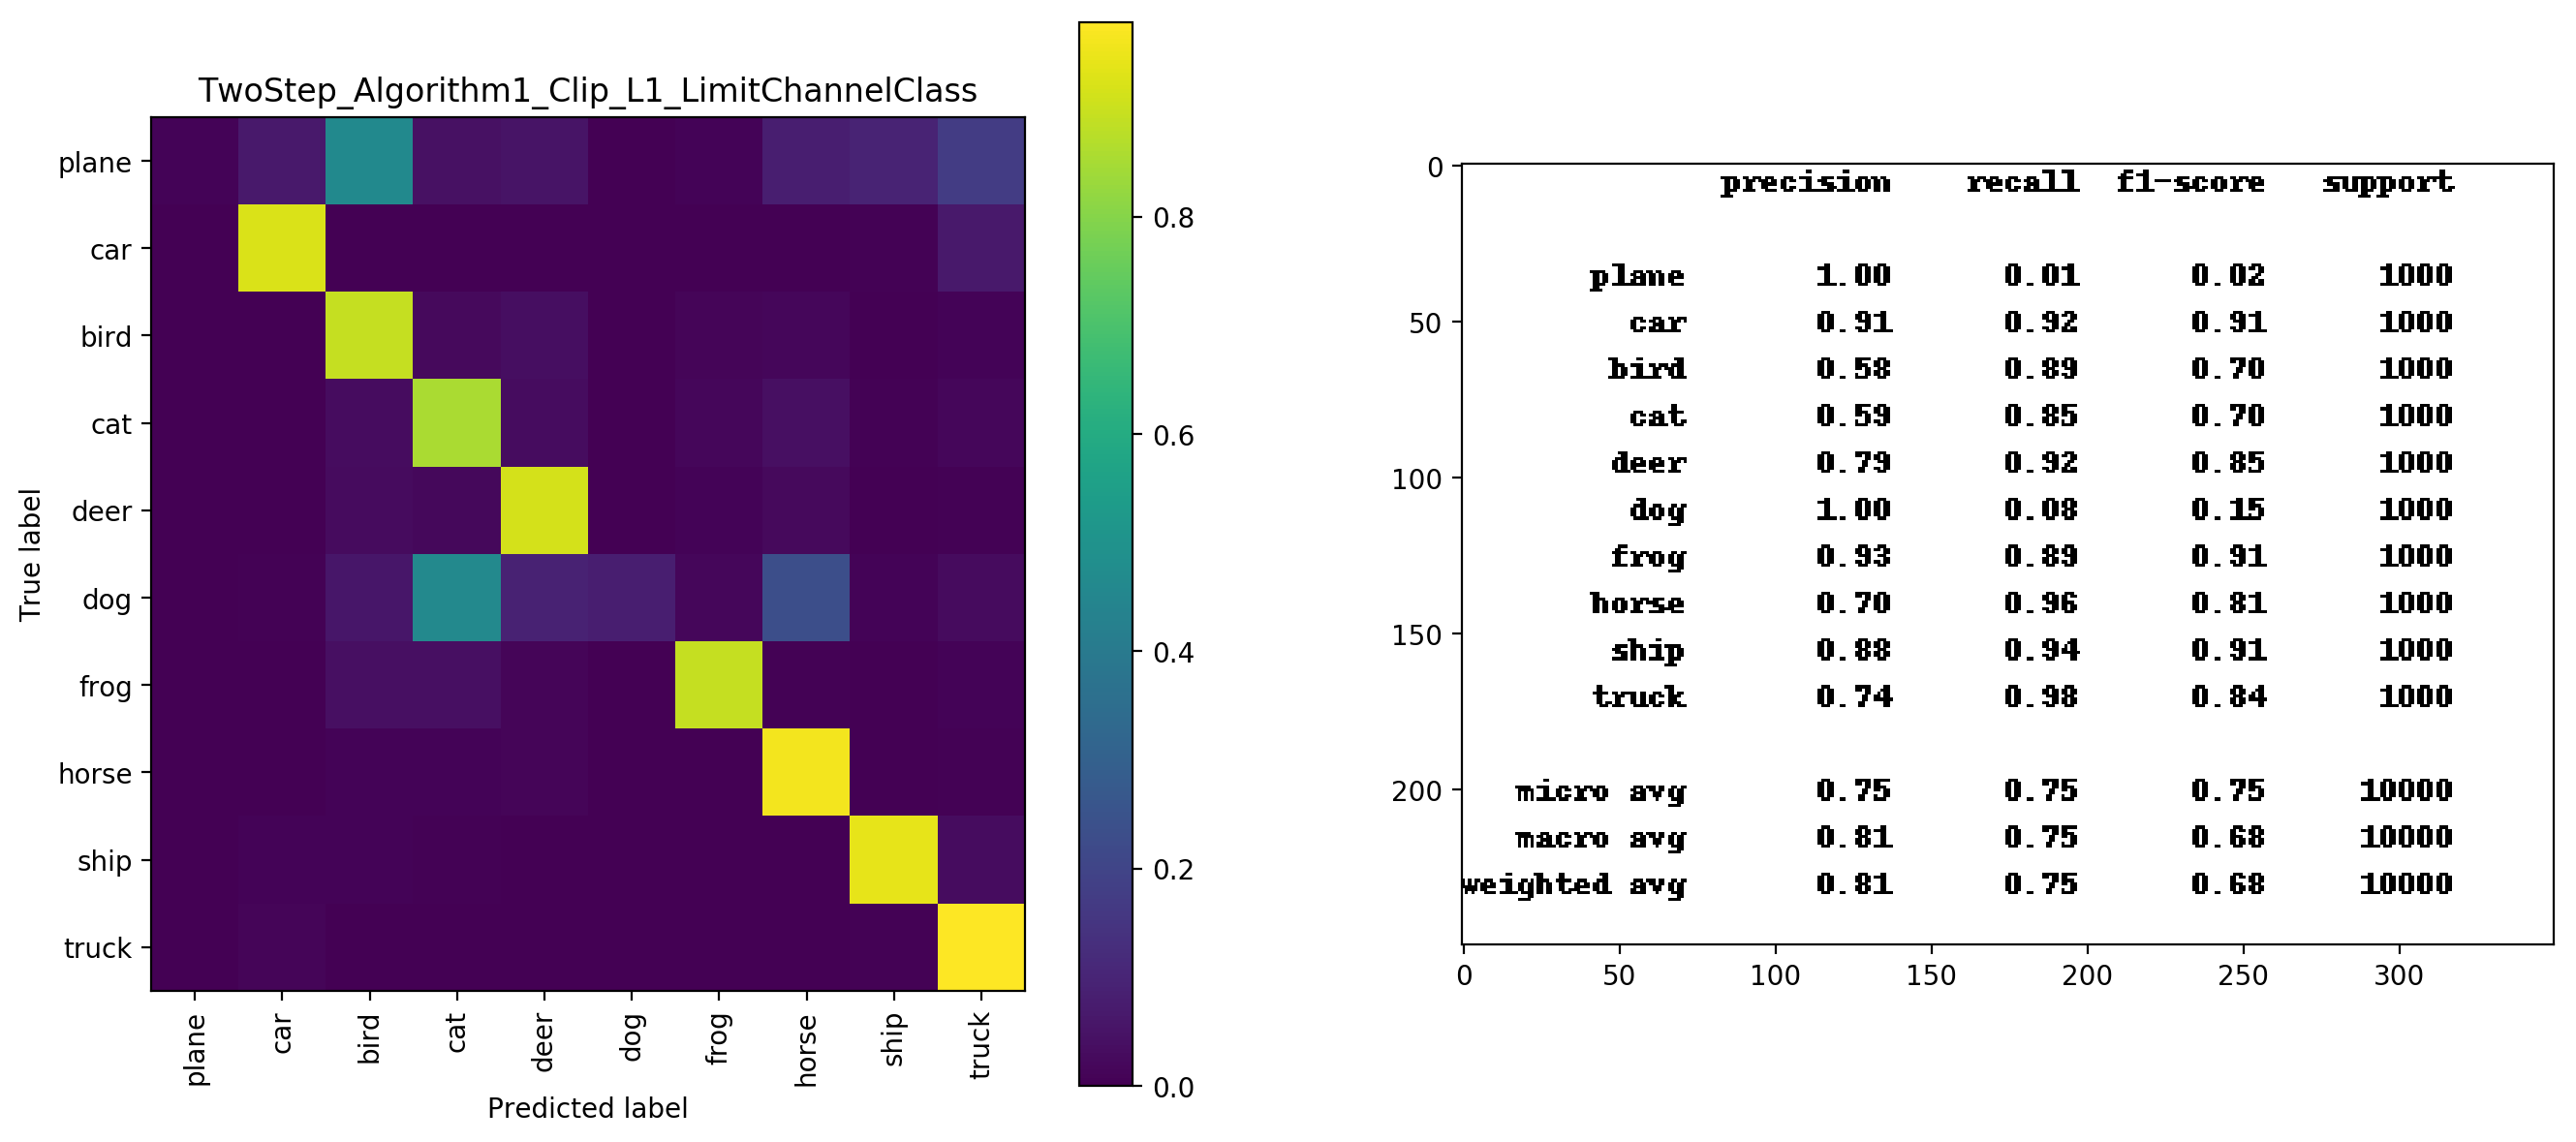

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/TwoStep_Algorithm1_Clip_L21_LimitChannelClass/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7690


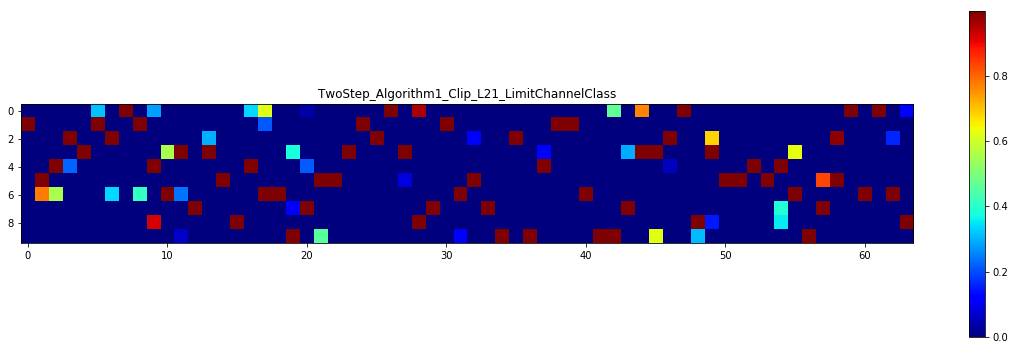

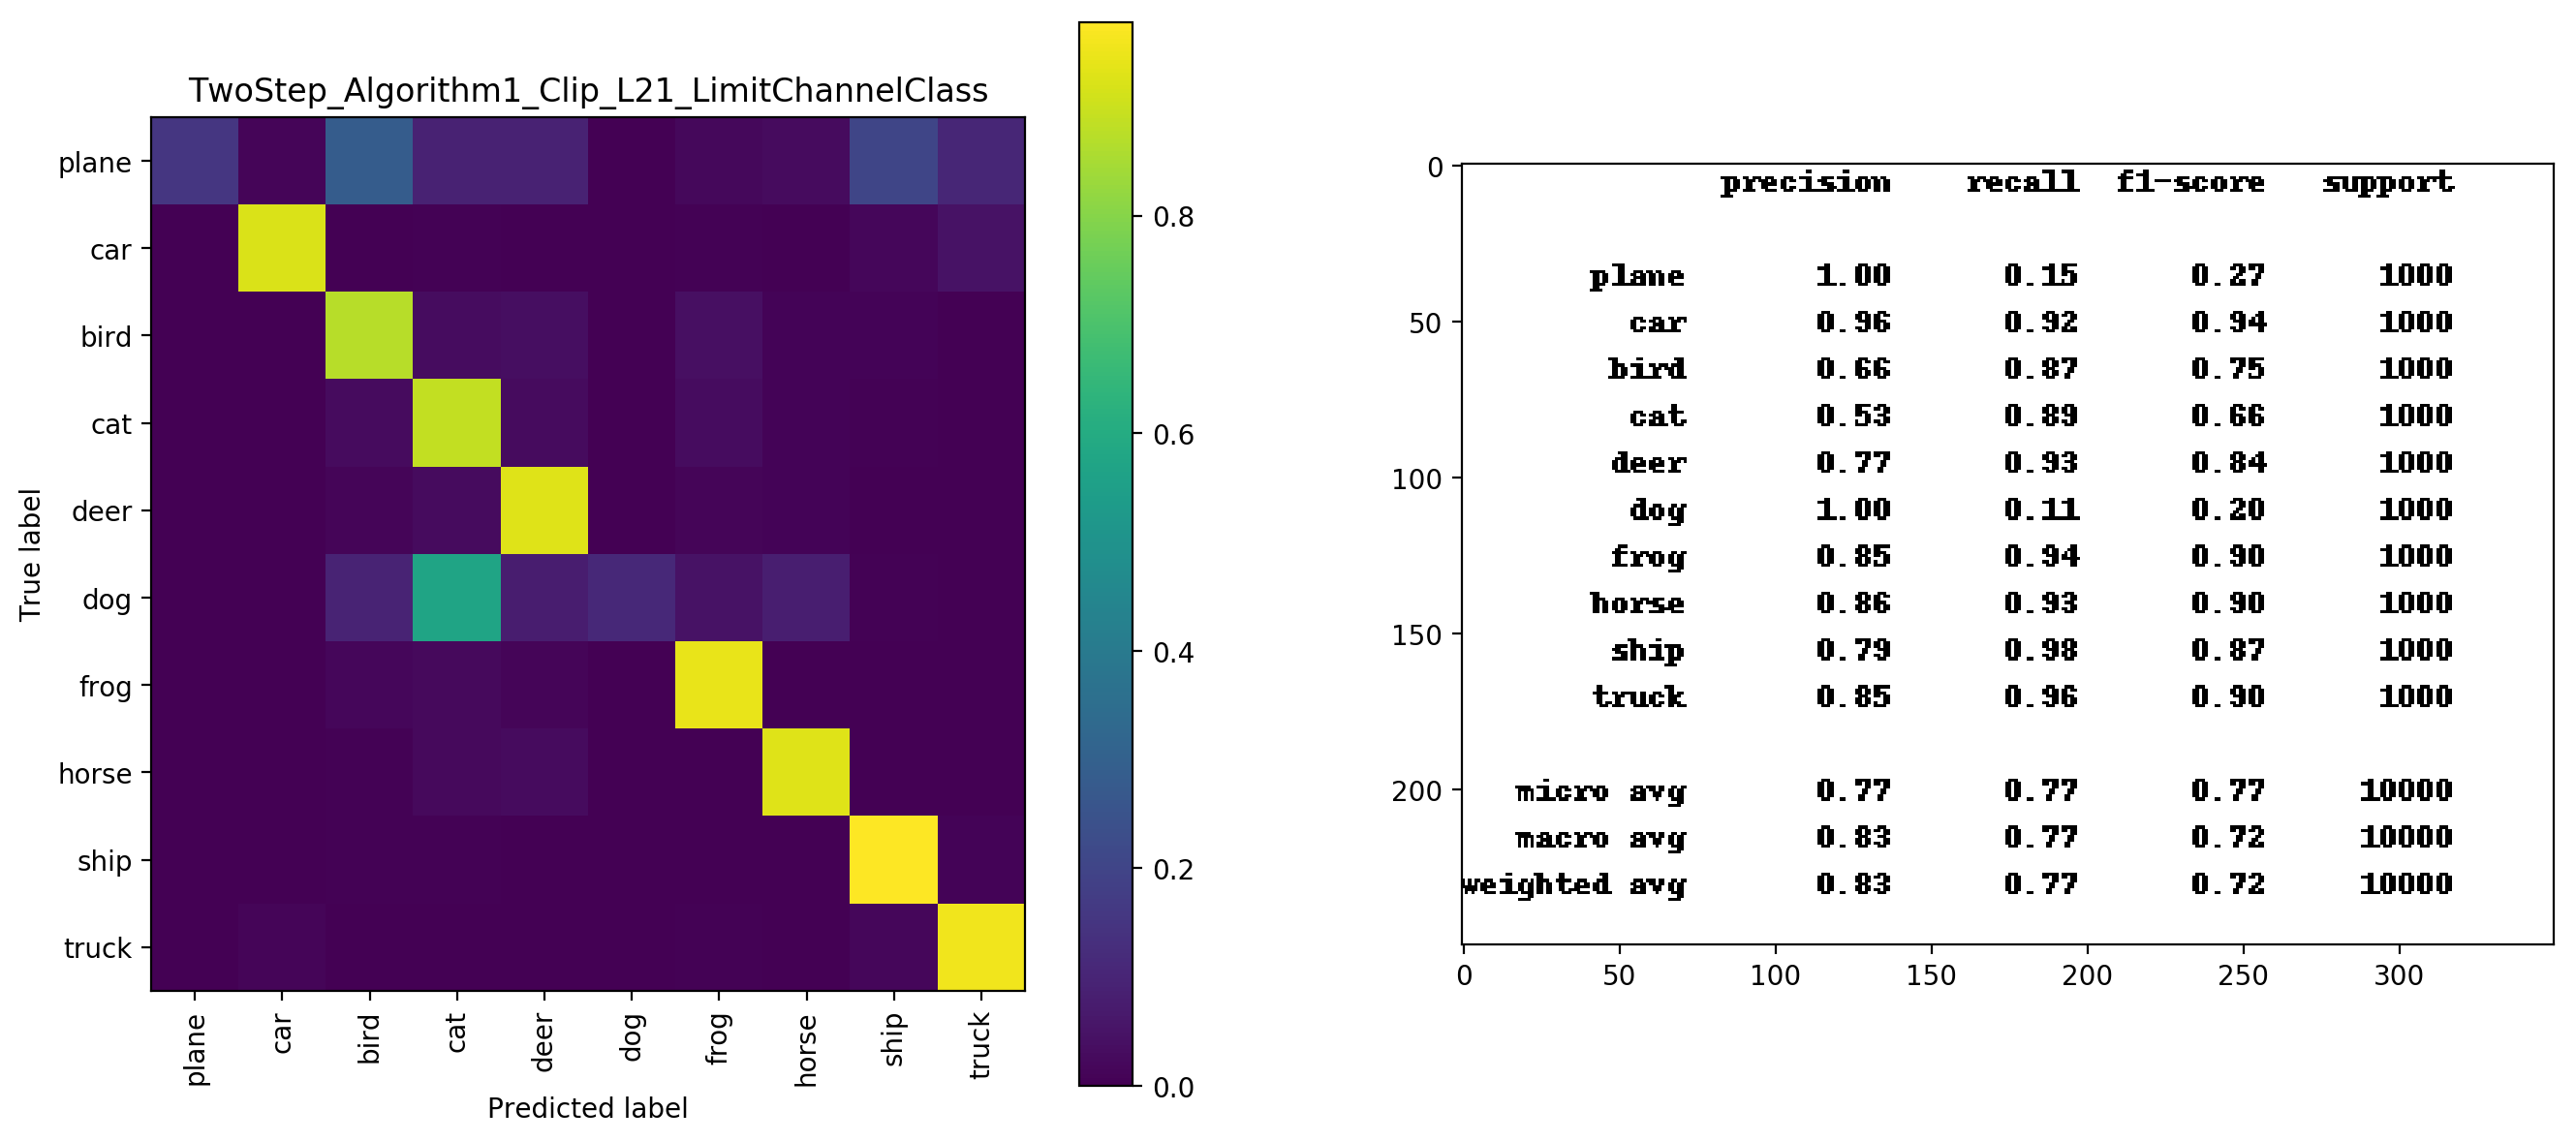

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/TwoStep_Algorithm1_Clip_Lmax_LimitChannelClass/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.8937


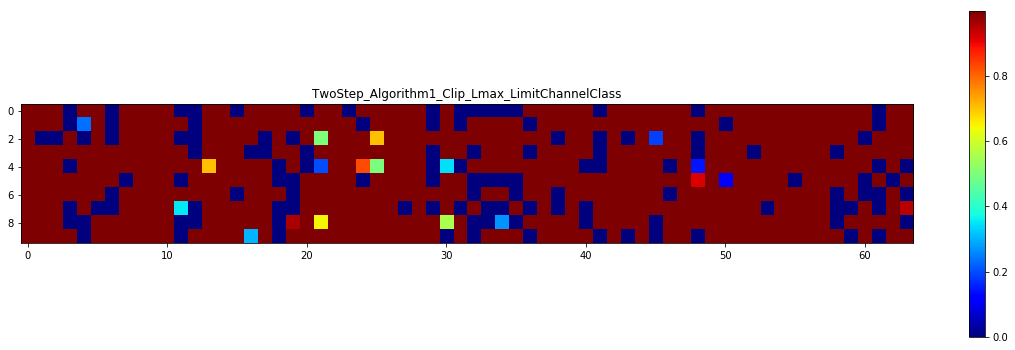

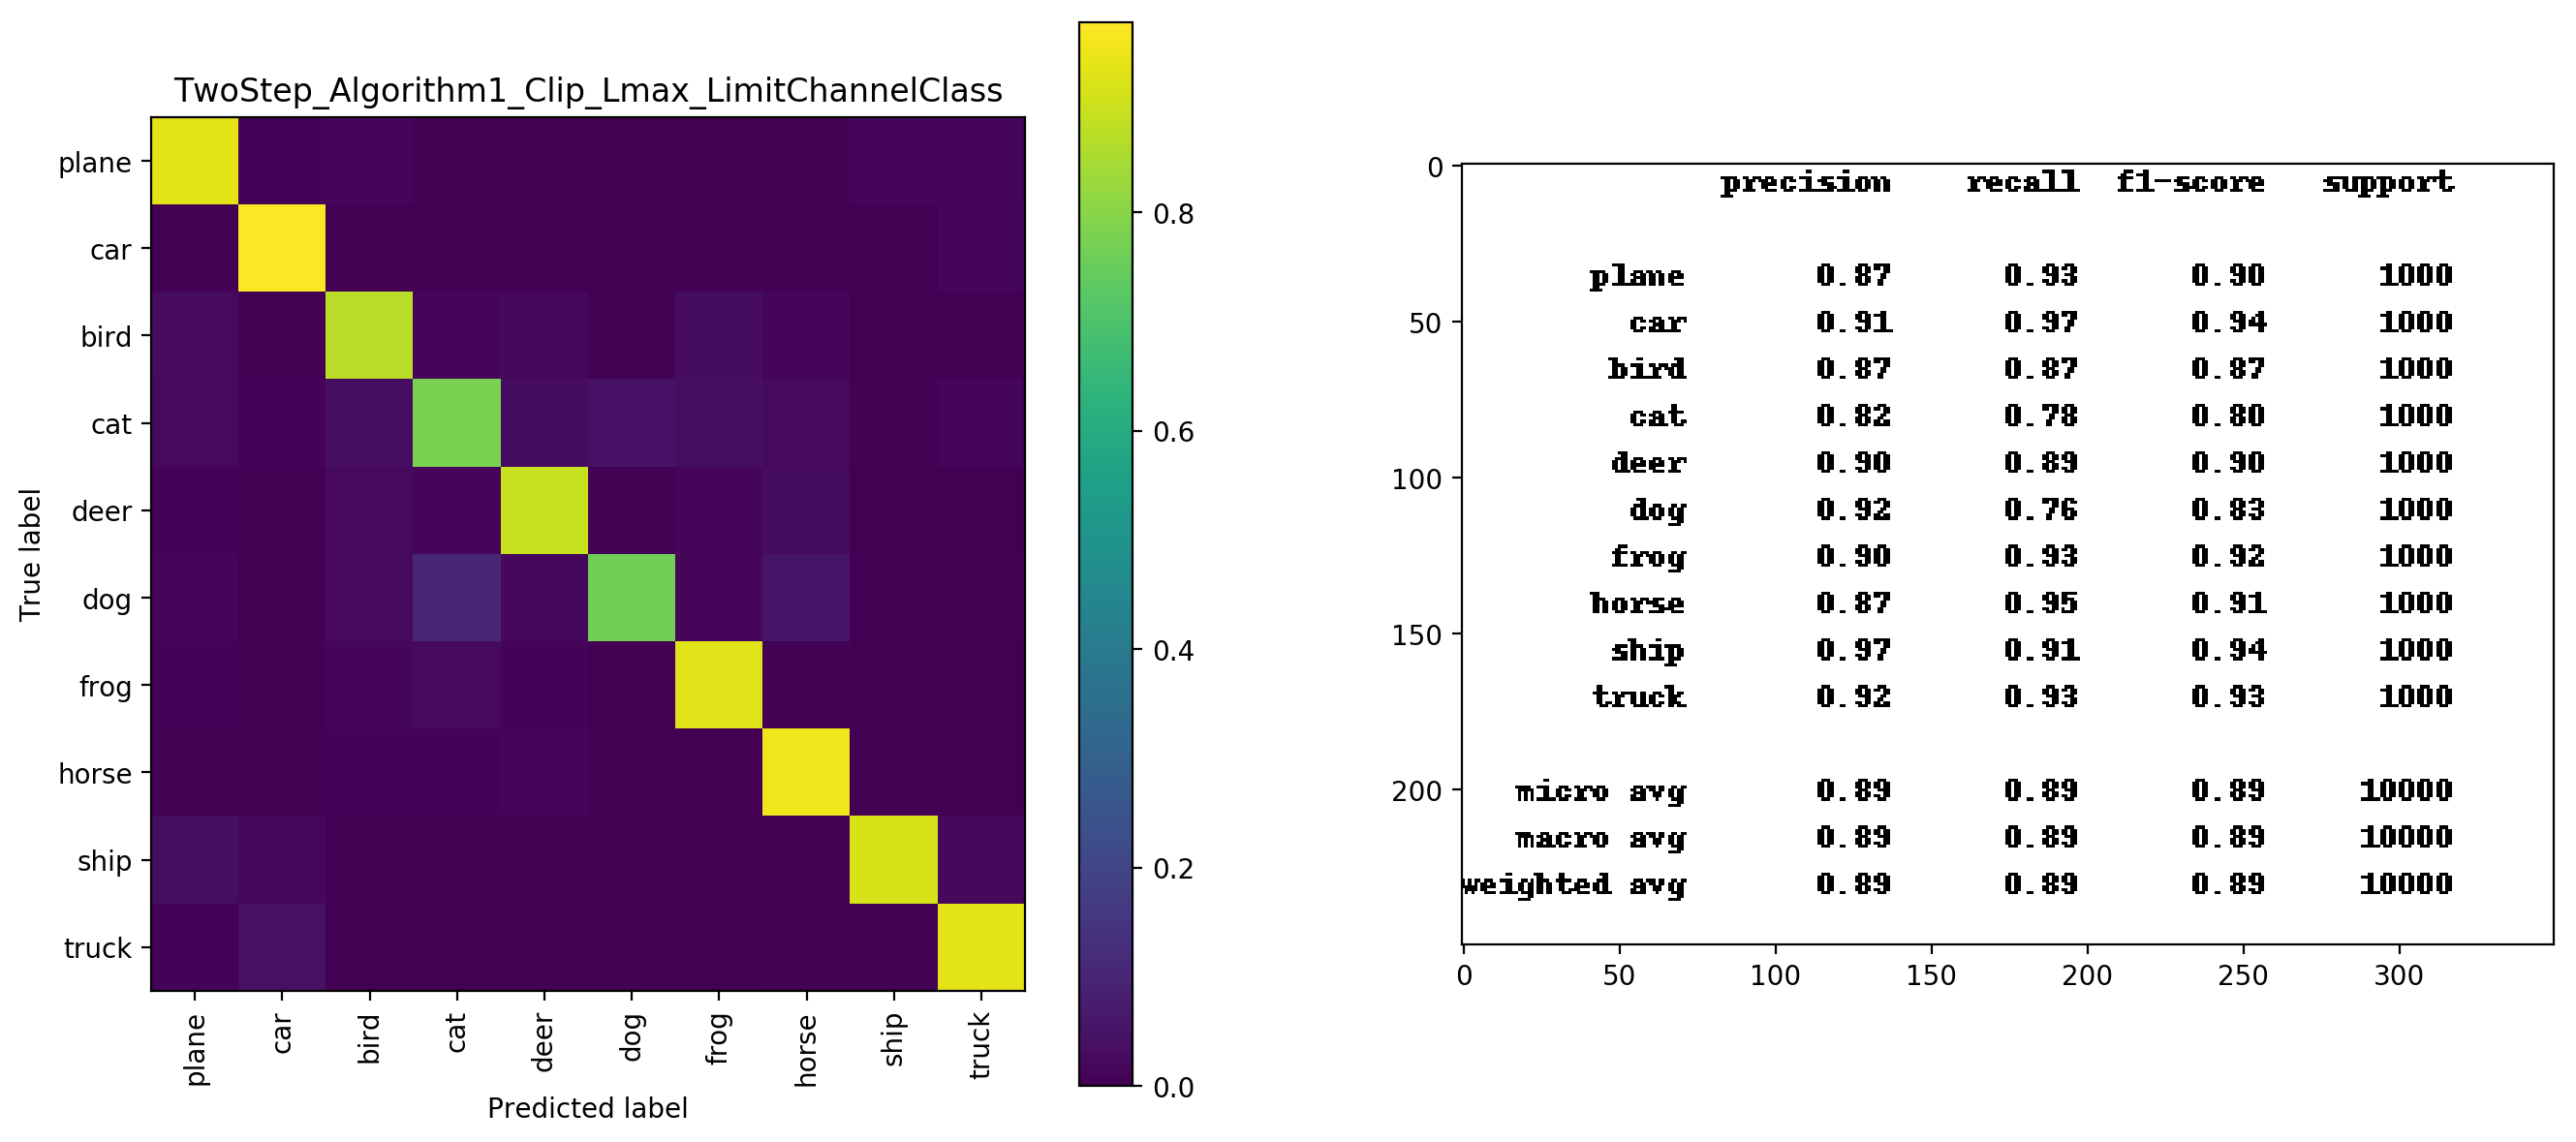

In [23]:
def get_weights(model):
#     return model.module.lmask.get_channel_mask()
    return model.module.lmask.mask
exp_root = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/'
analysis_queue = [
    'TwoStep_Algorithm1_Clip_L11e_3_LimitChannelClass',
    'TwoStep_Algorithm1_Clip_L1_LimitChannelClass',
    'TwoStep_Algorithm1_Clip_L21_LimitChannelClass',
    'TwoStep_Algorithm1_Clip_Lmax_LimitChannelClass',
]
analysis_queue = [exp_root+var for var in analysis_queue]
for item in analysis_queue:
    show_res(item)

# Algorithm2

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L1/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7212


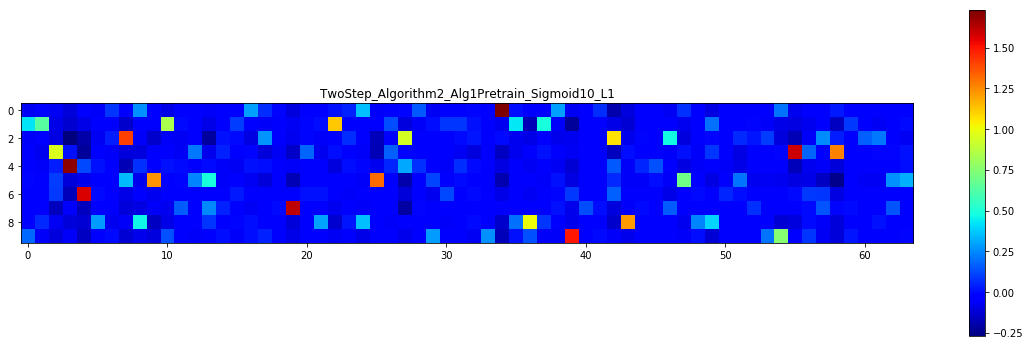

/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


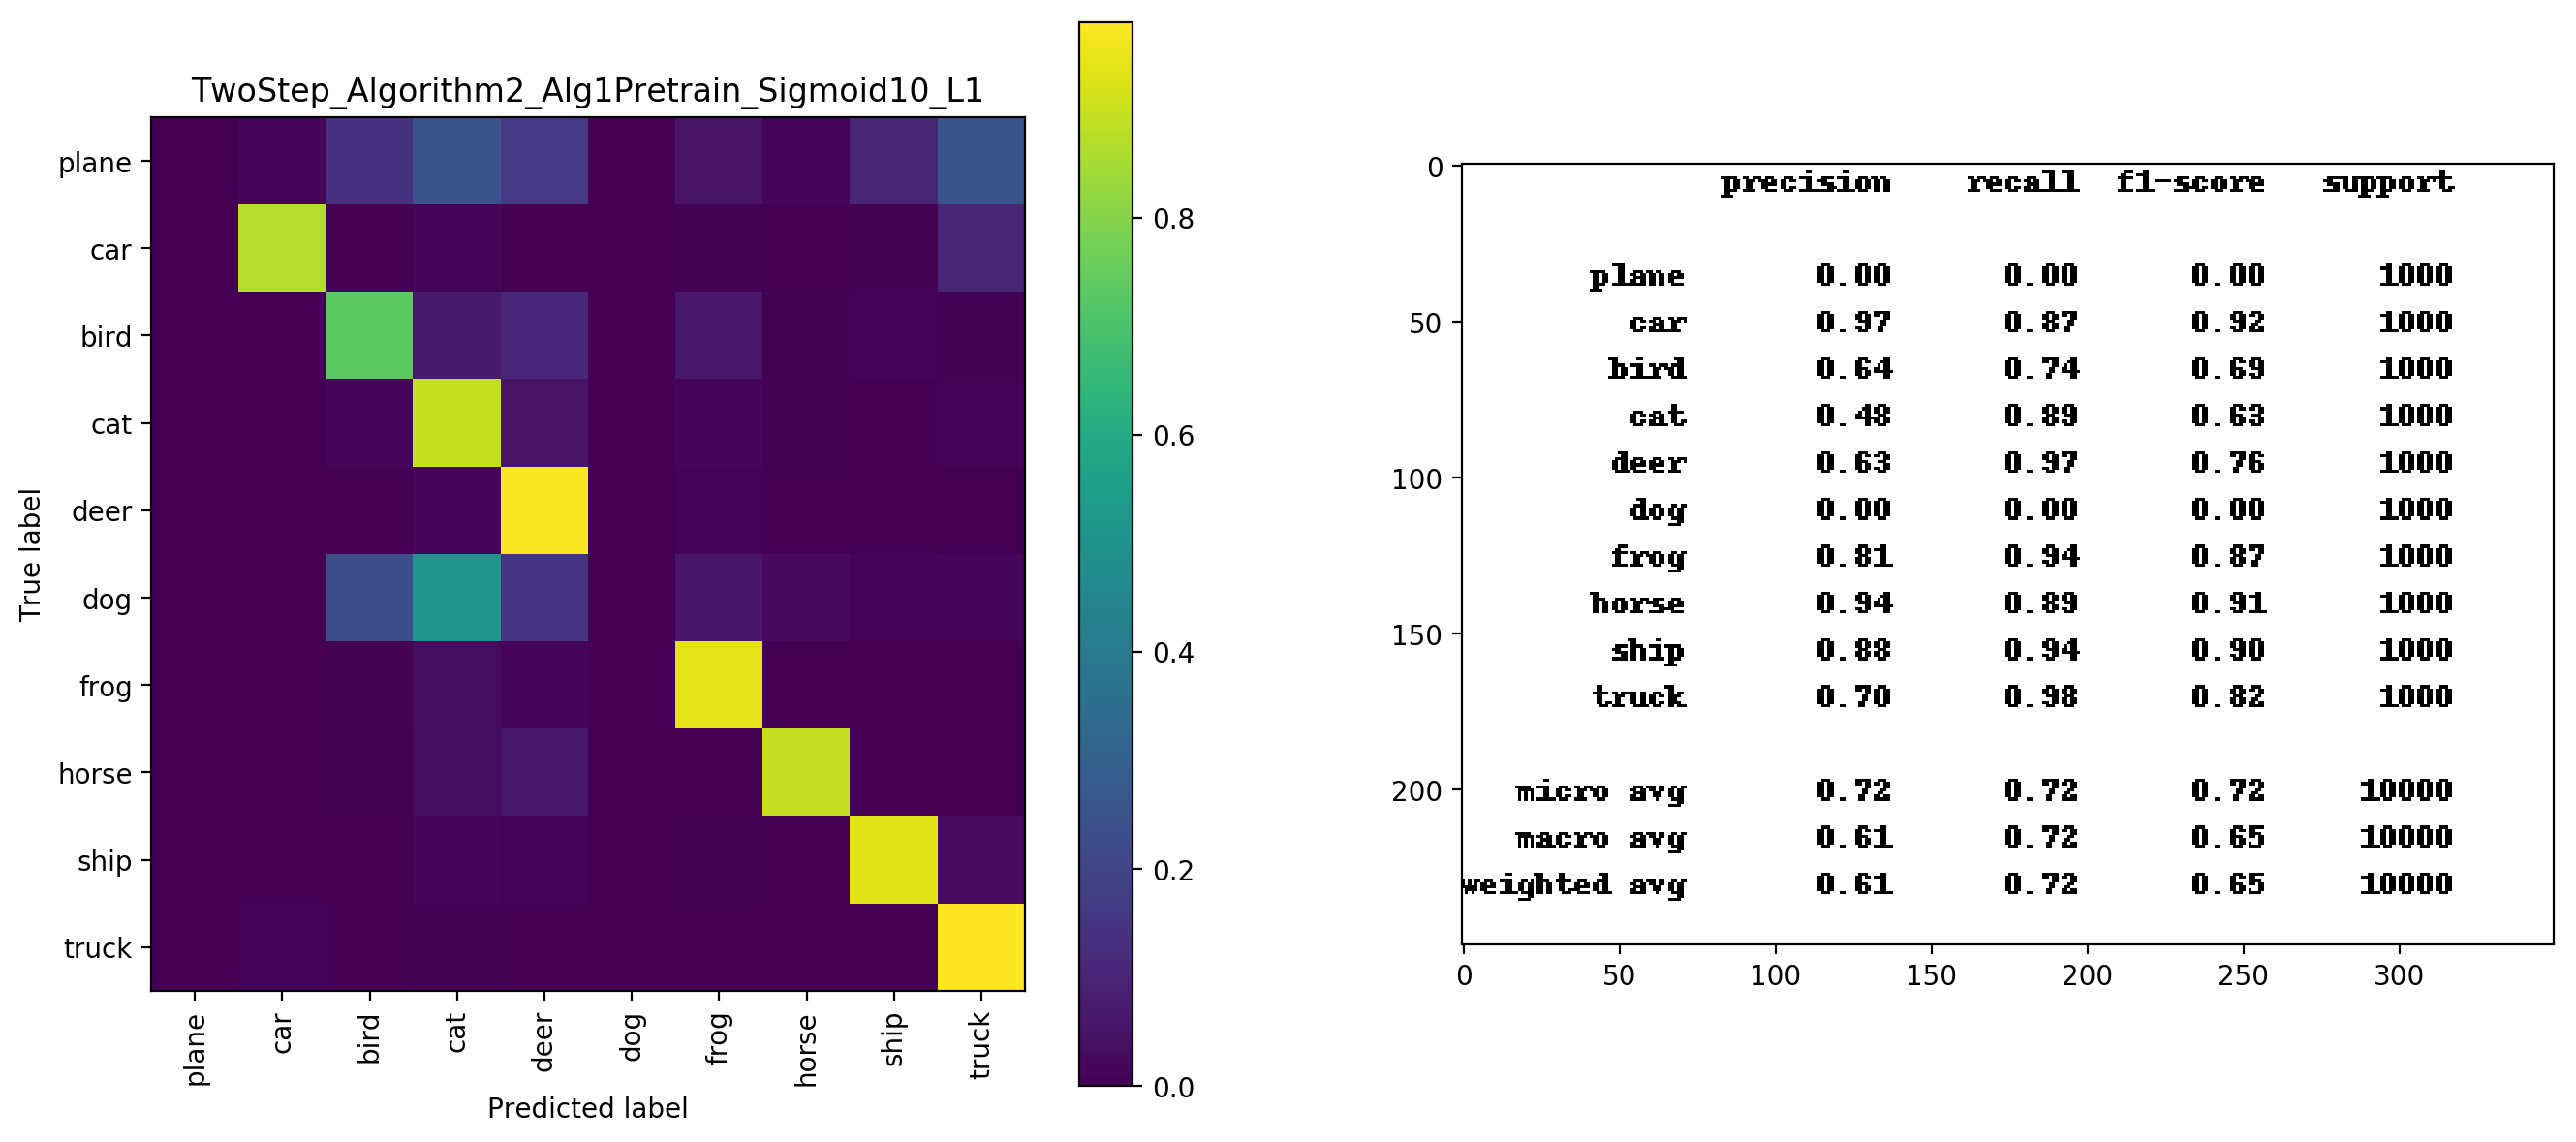

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L21/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7186


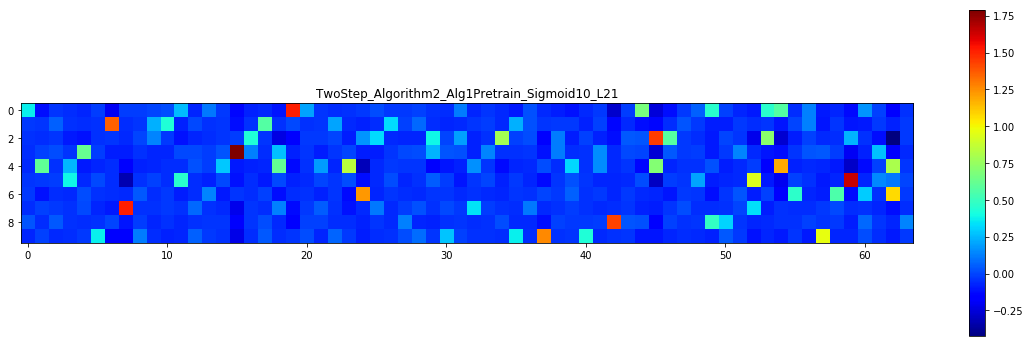

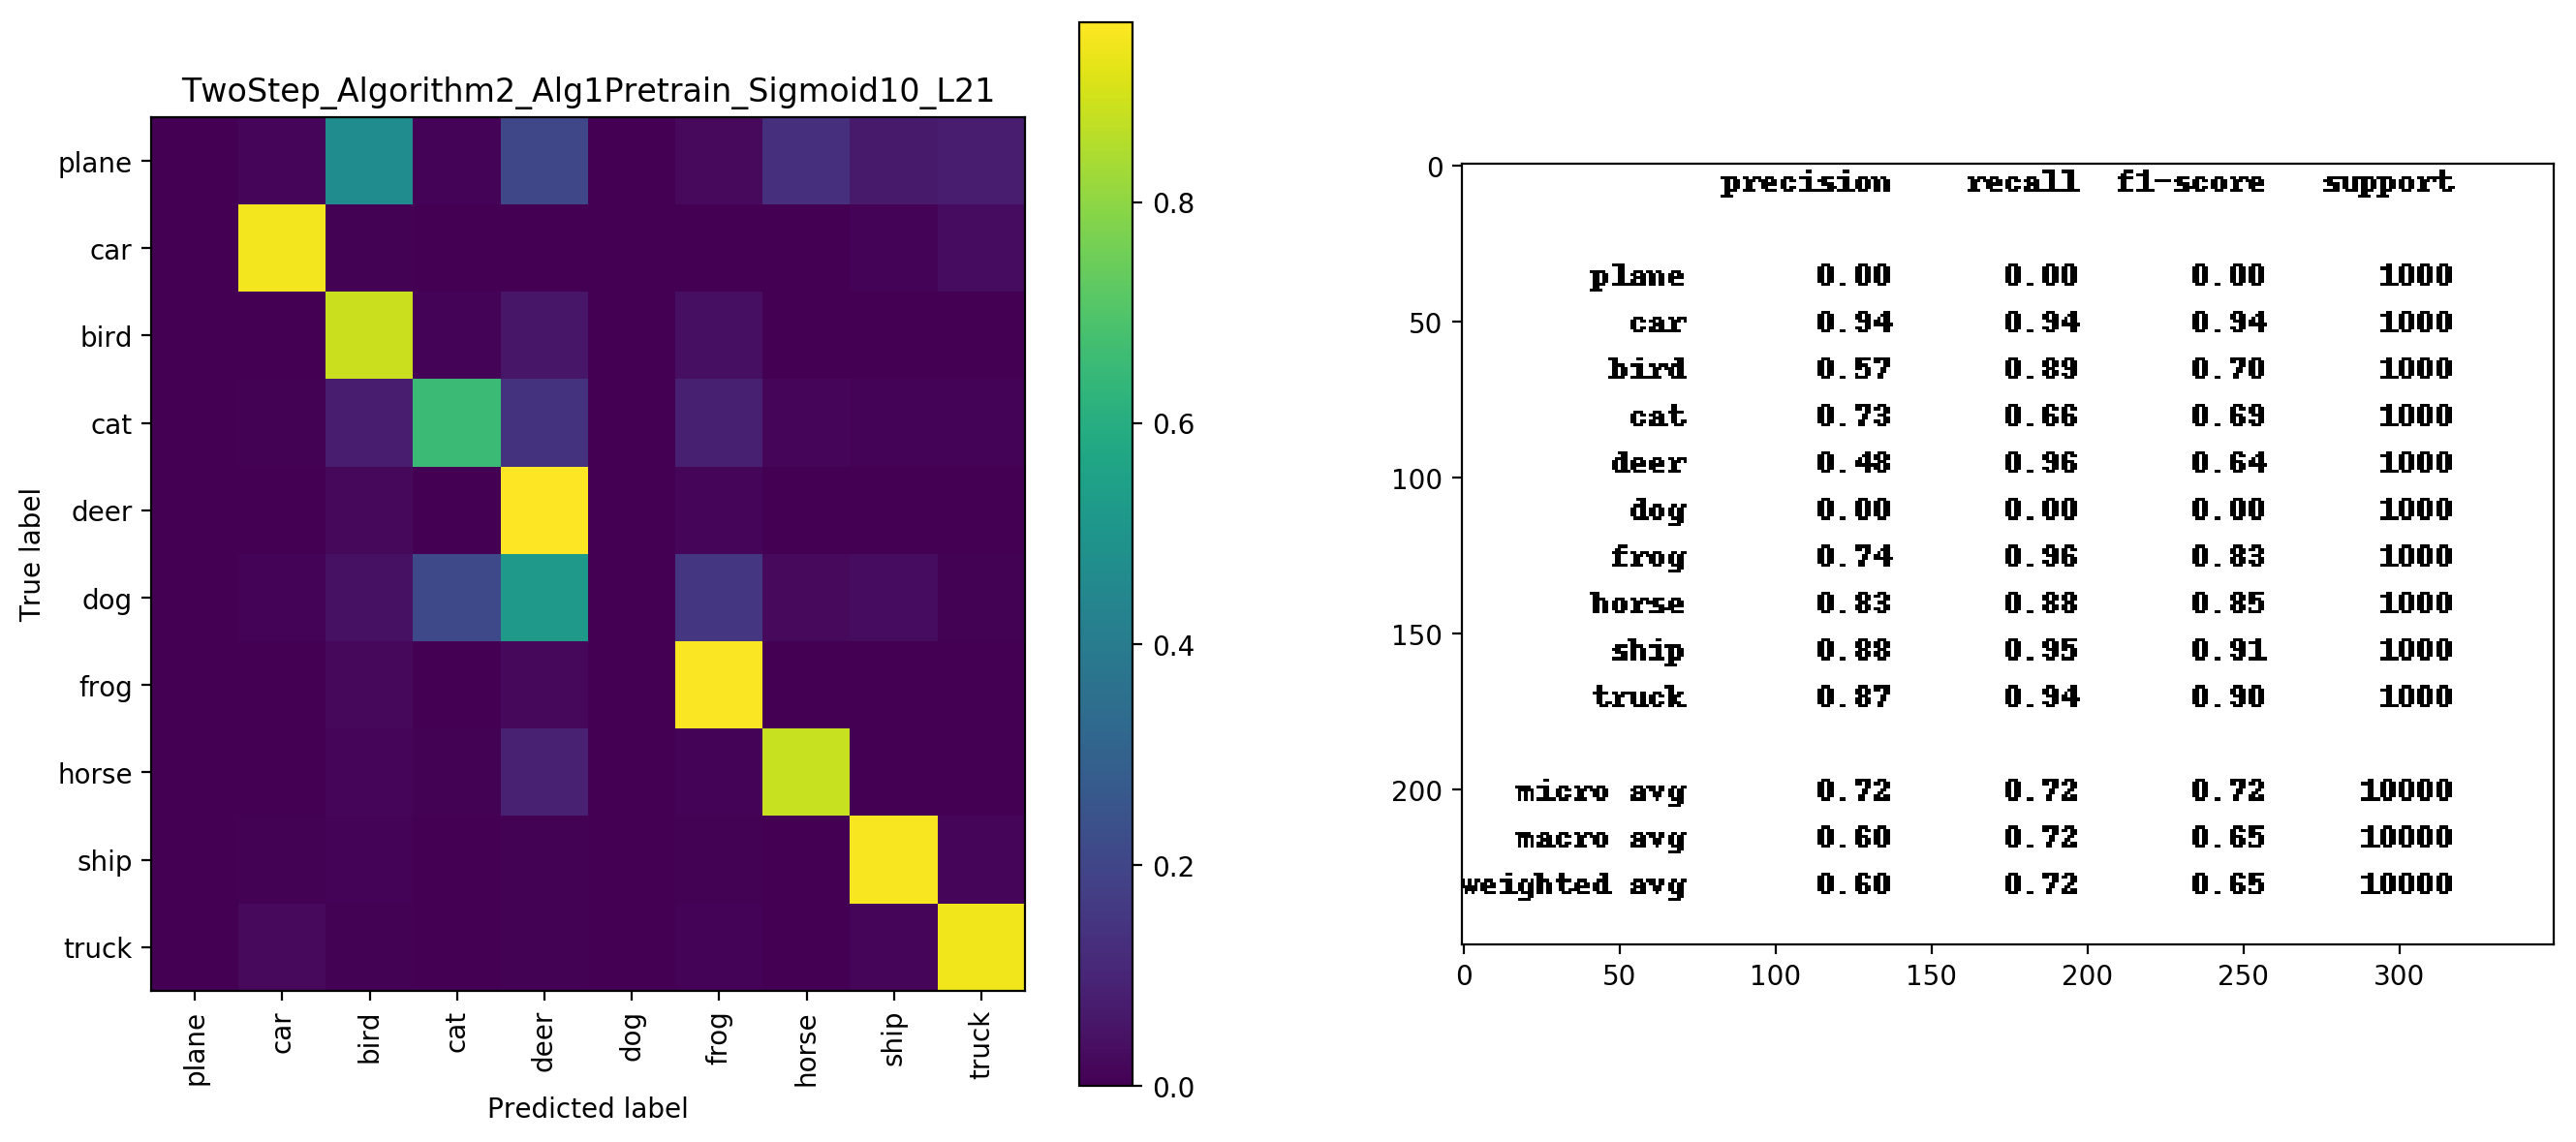

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_Lmax/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.1792


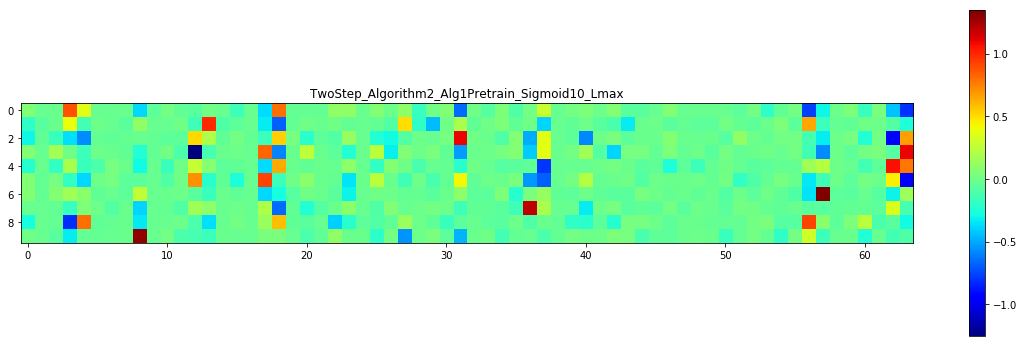

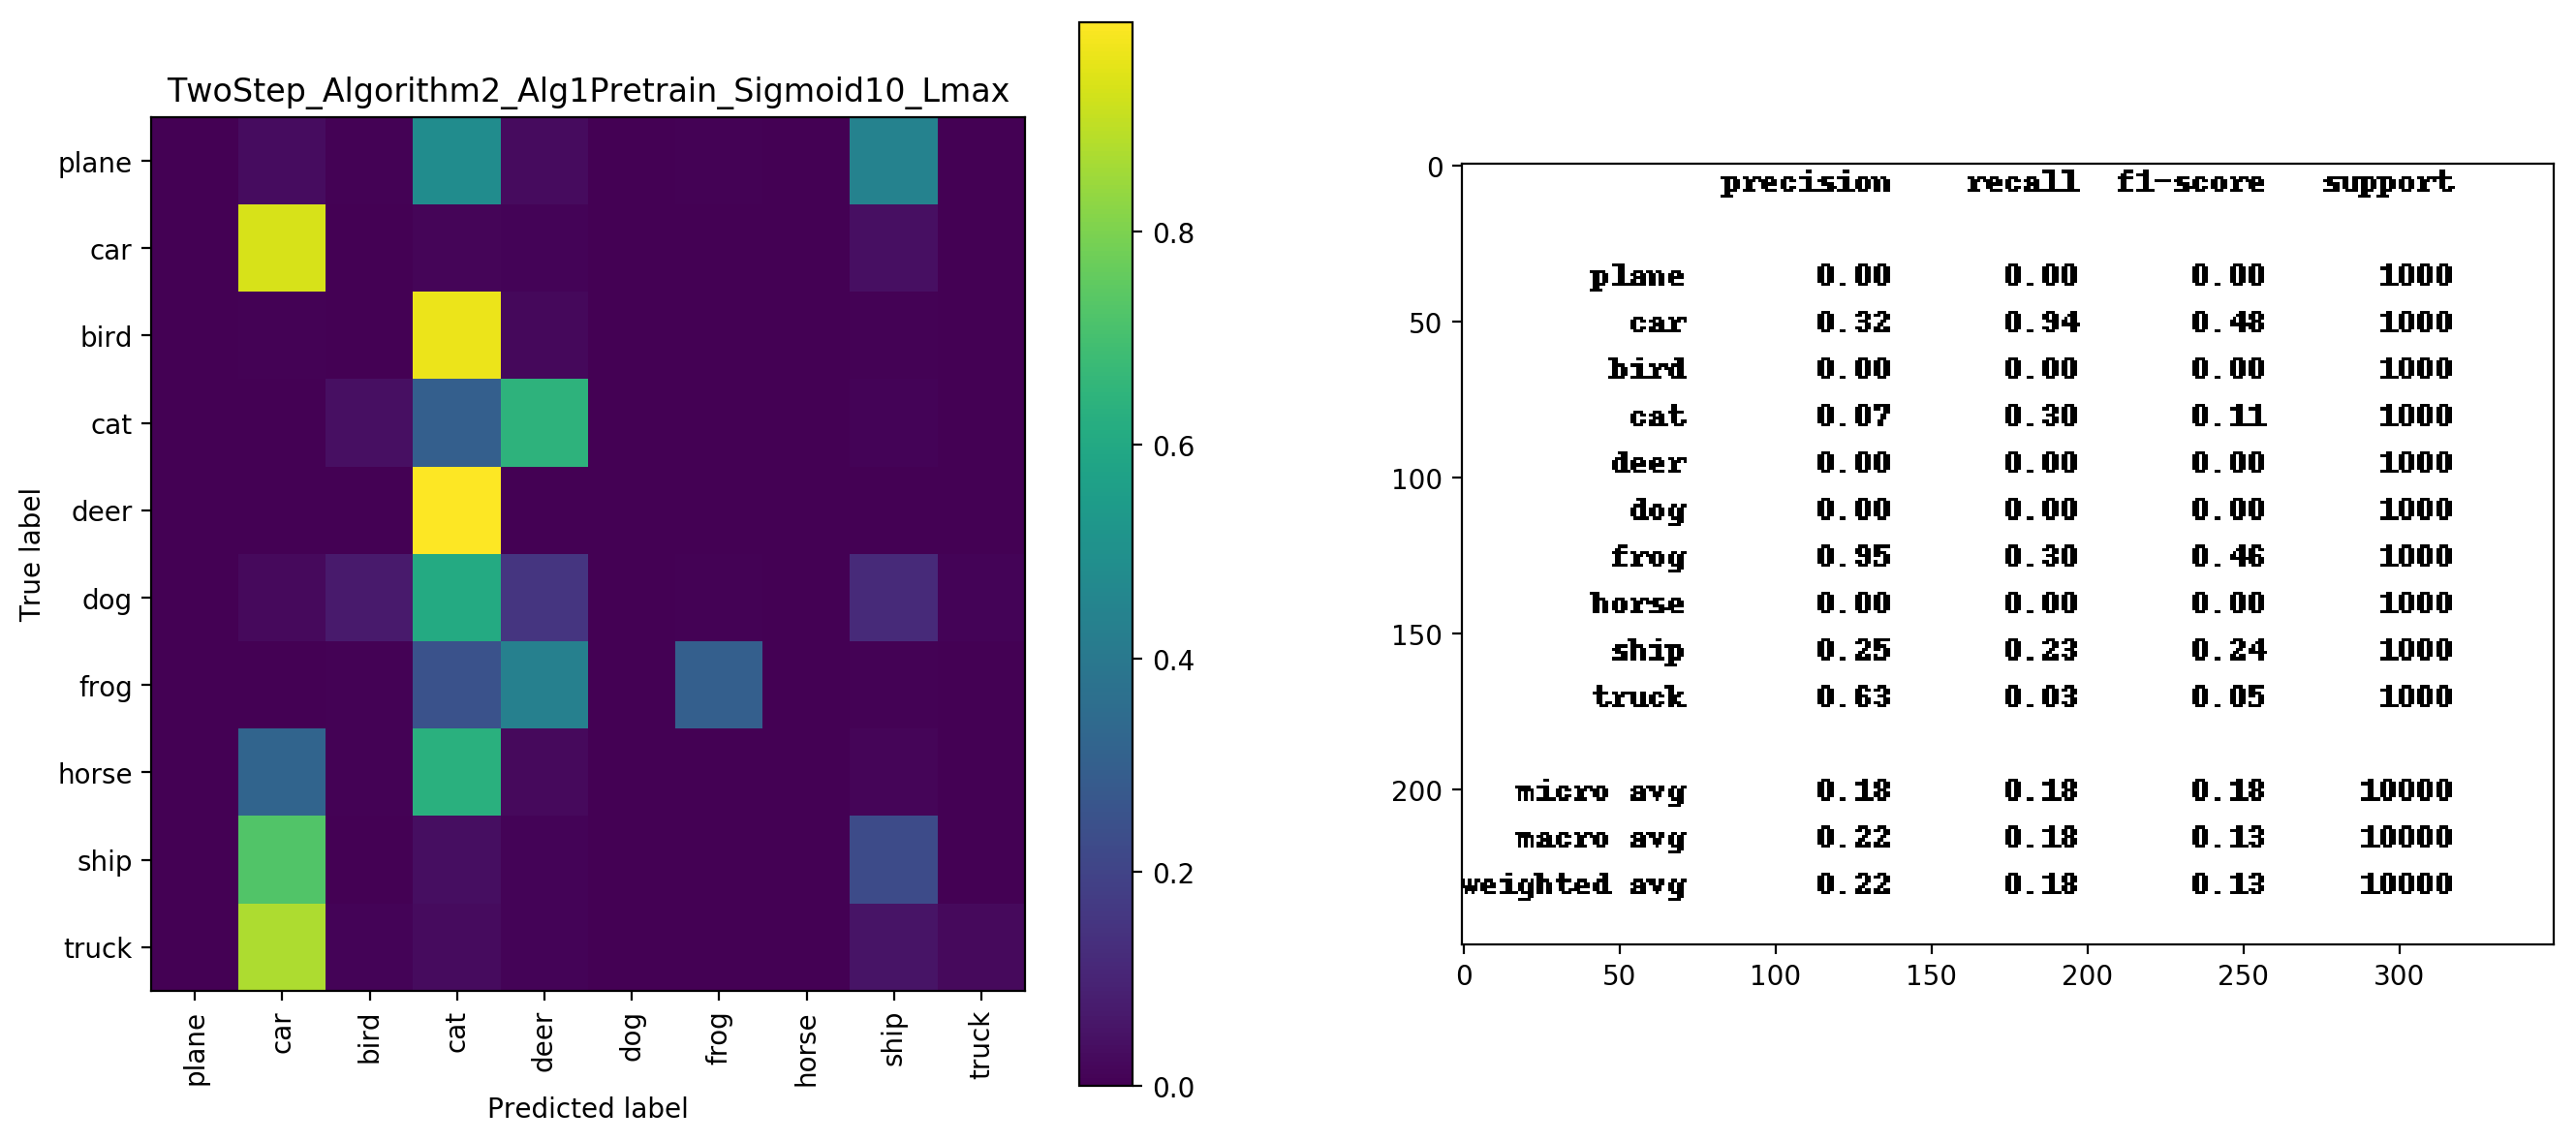

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid10_L1/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.0002


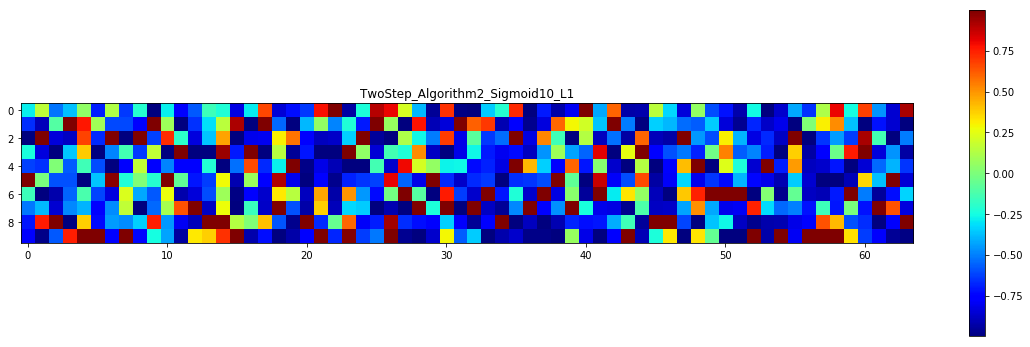

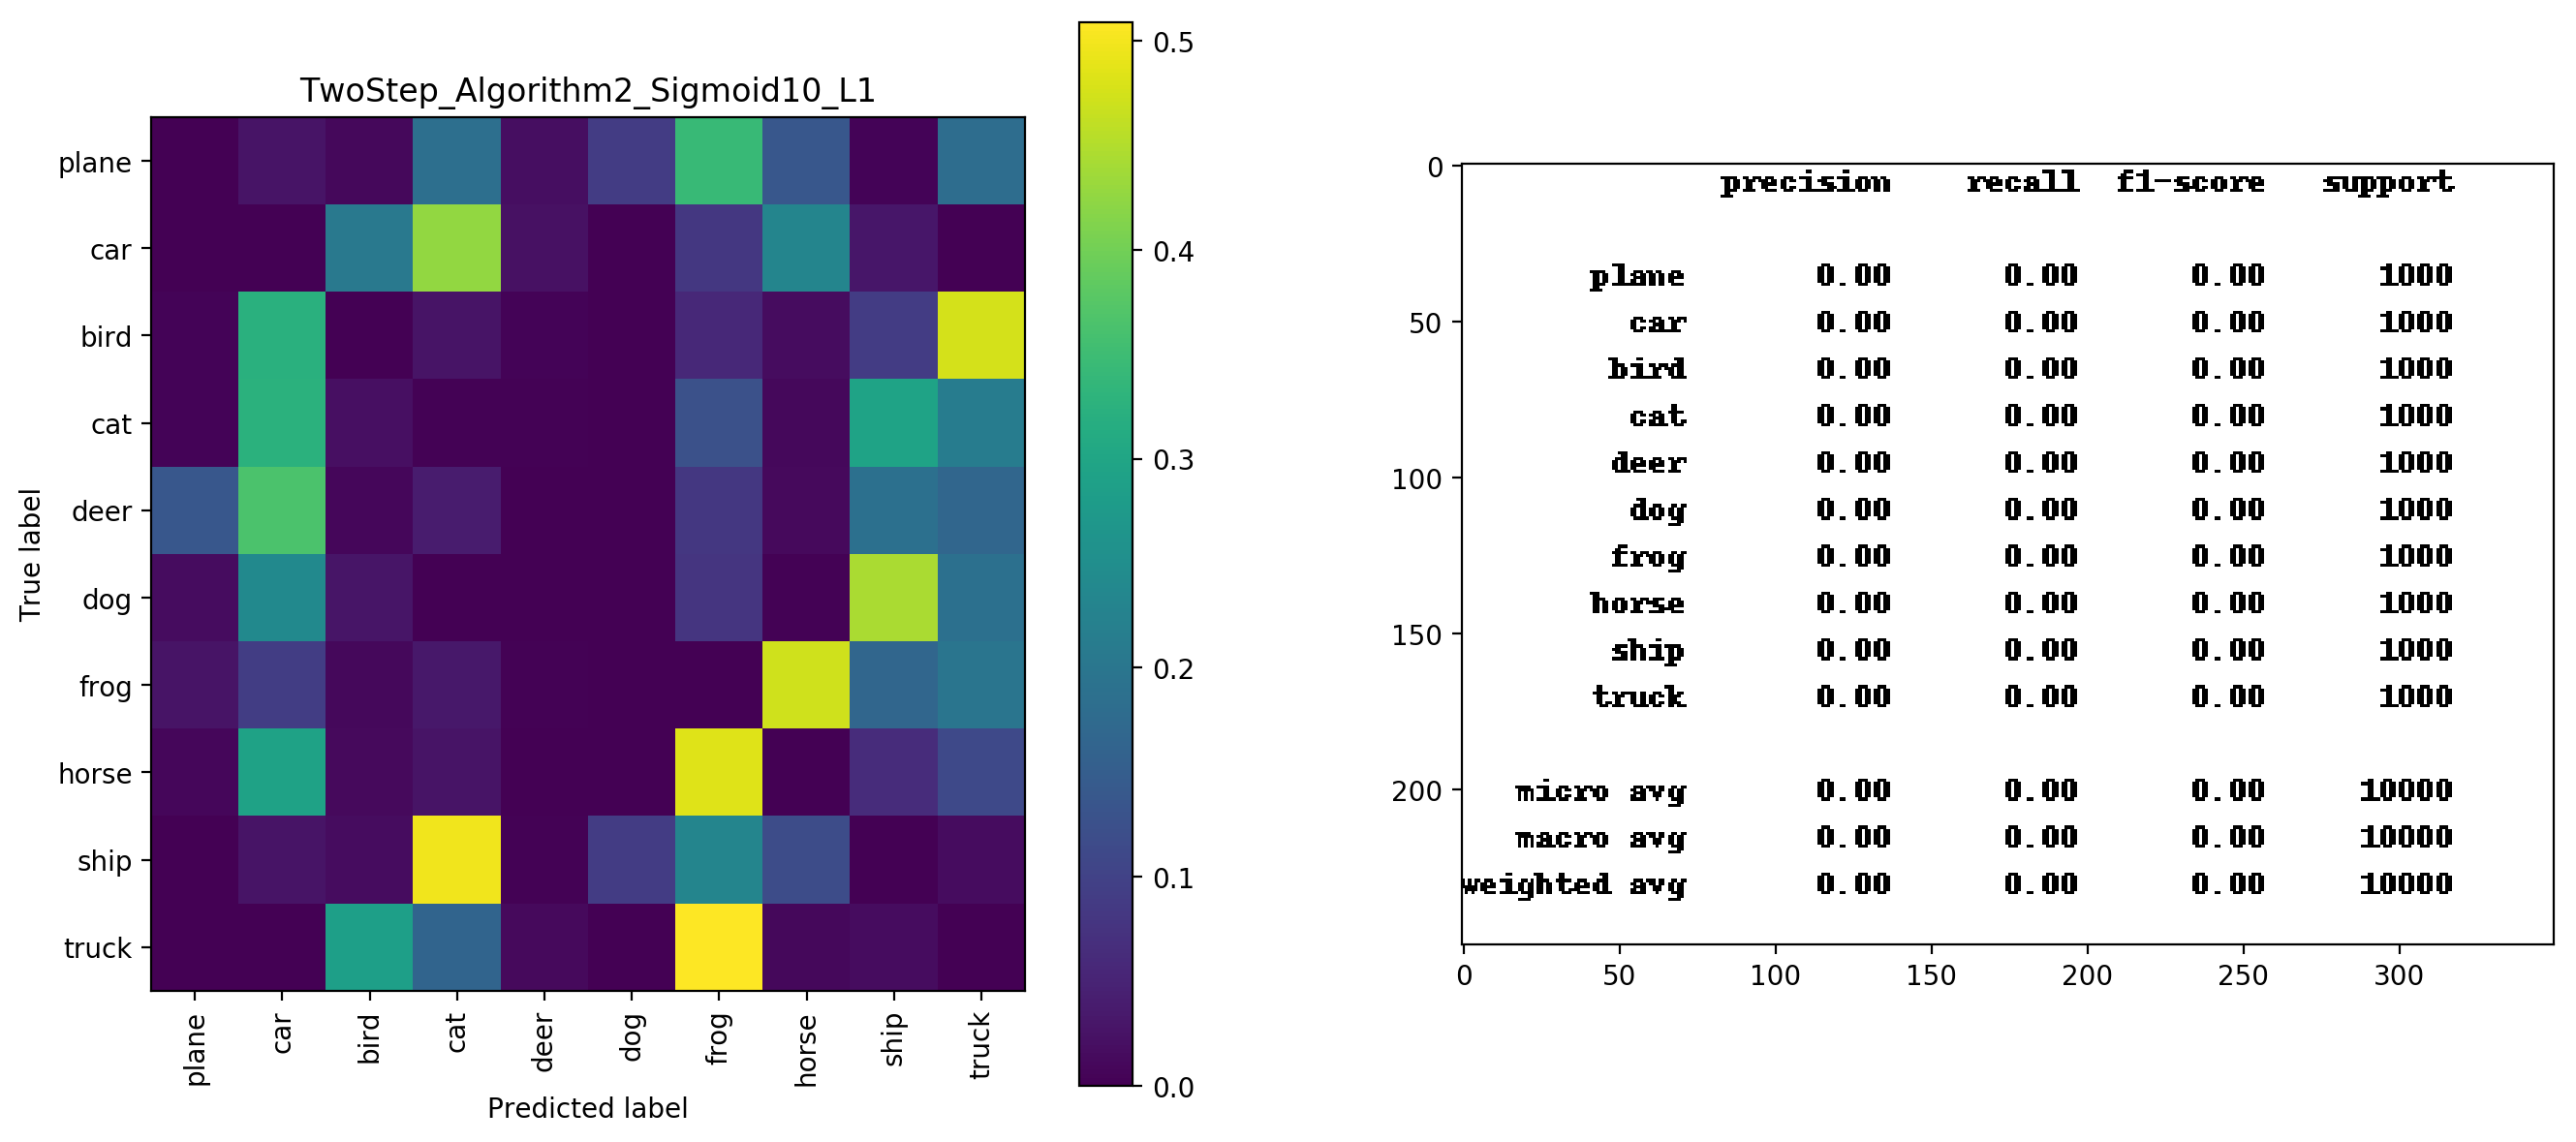

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid10_Lmax/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.3018


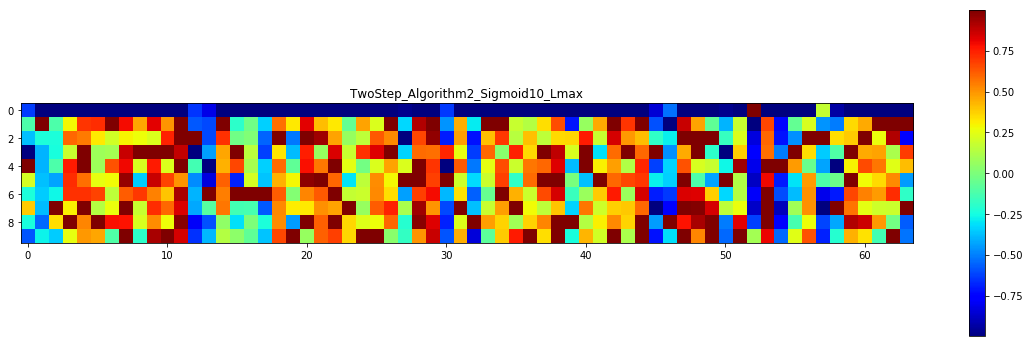

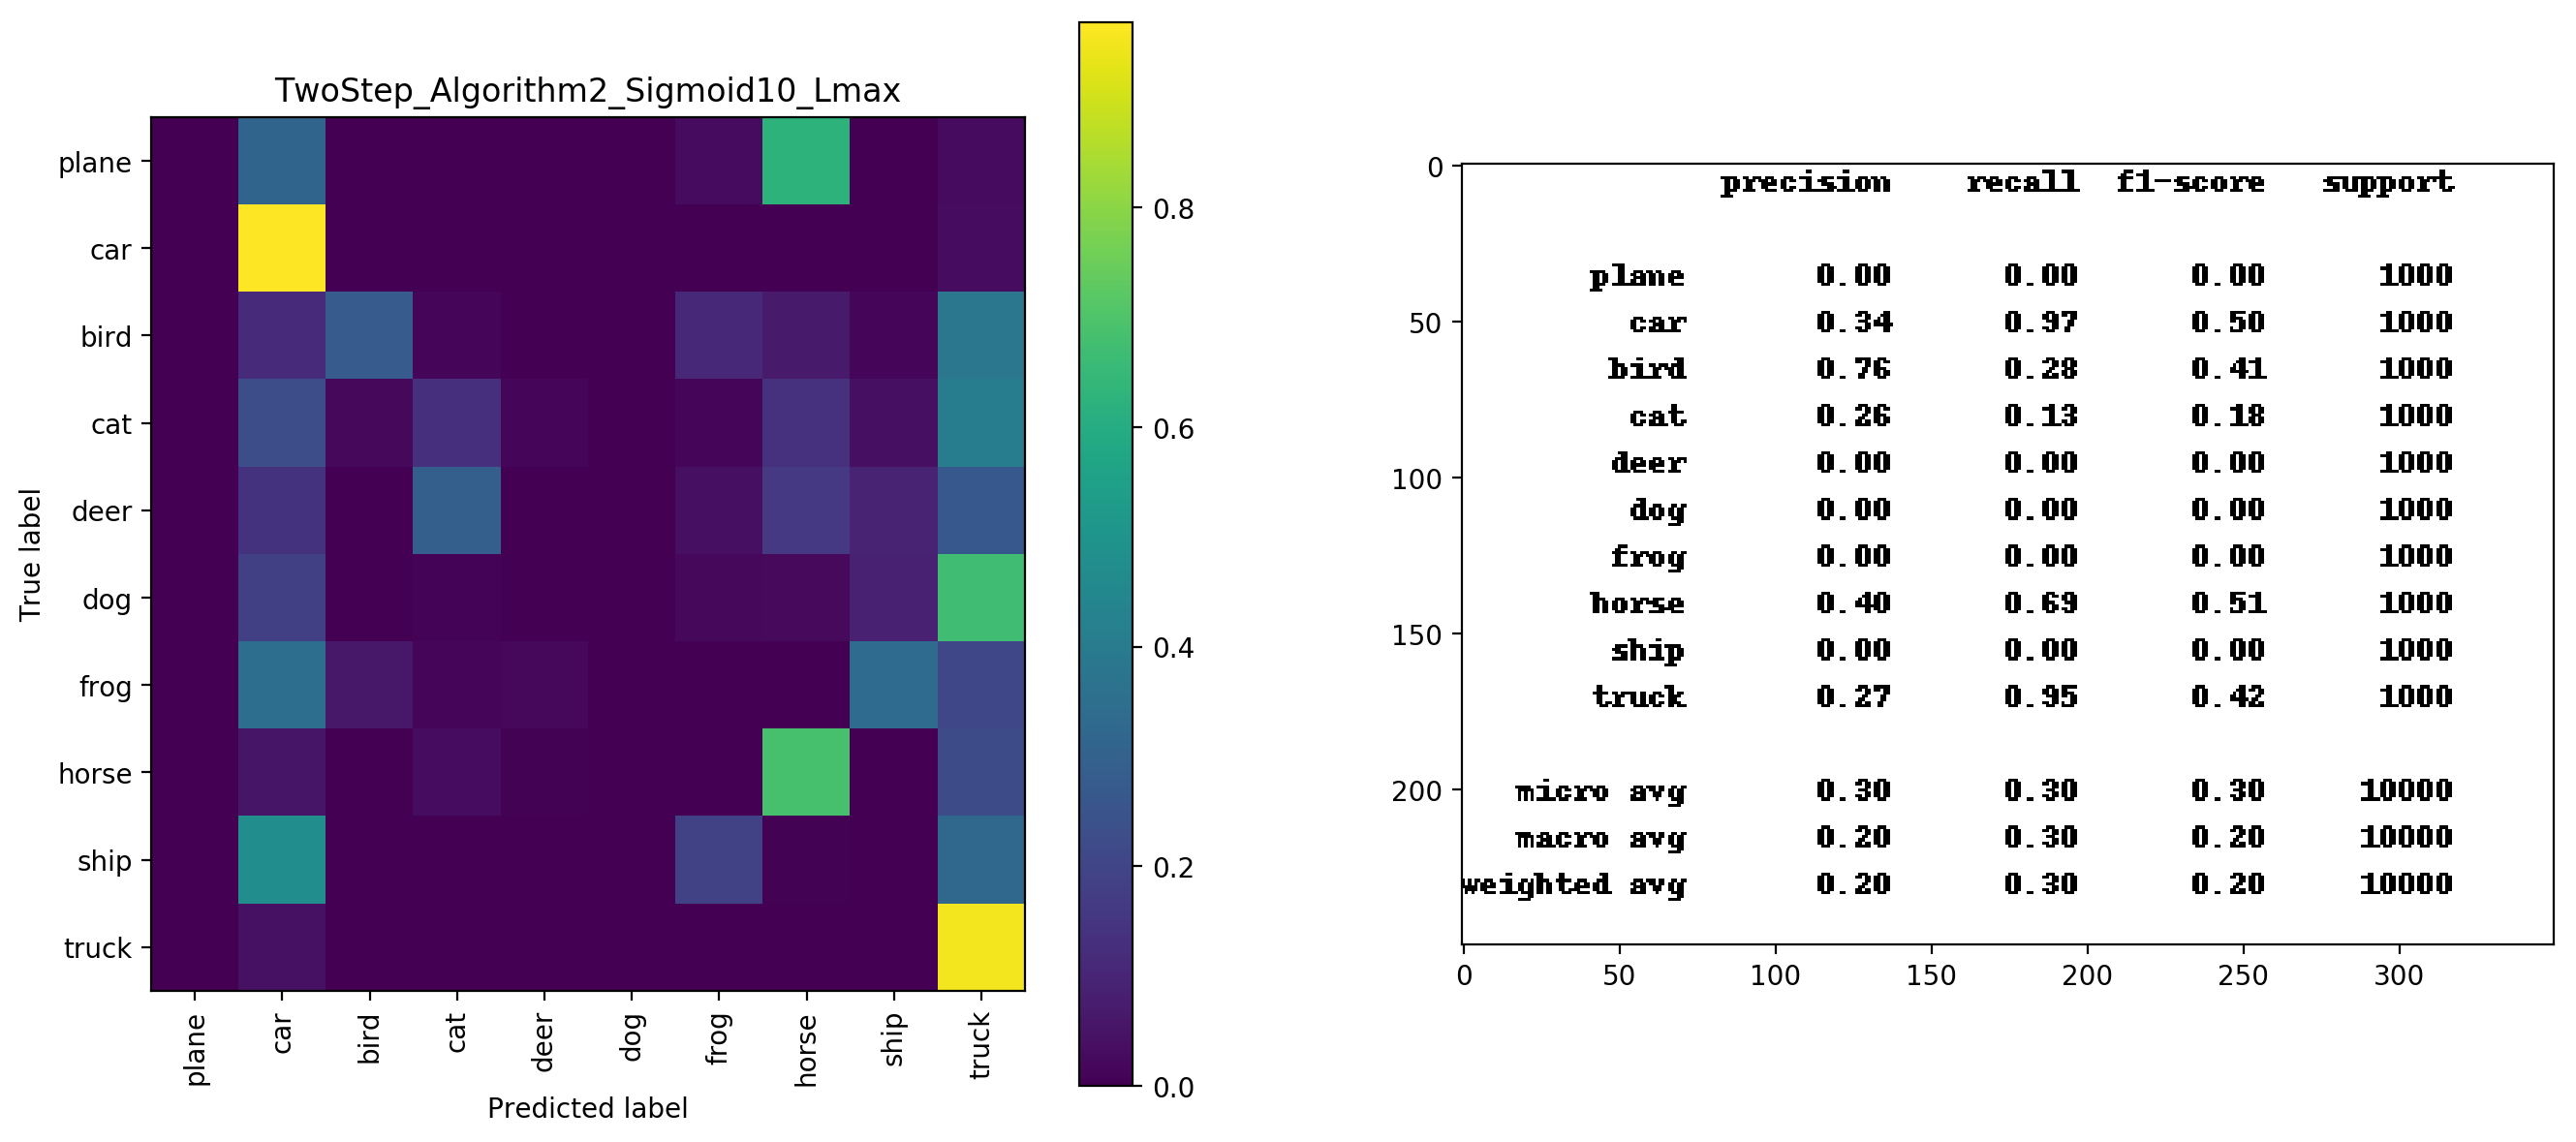

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid1e-3_L21/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.0002


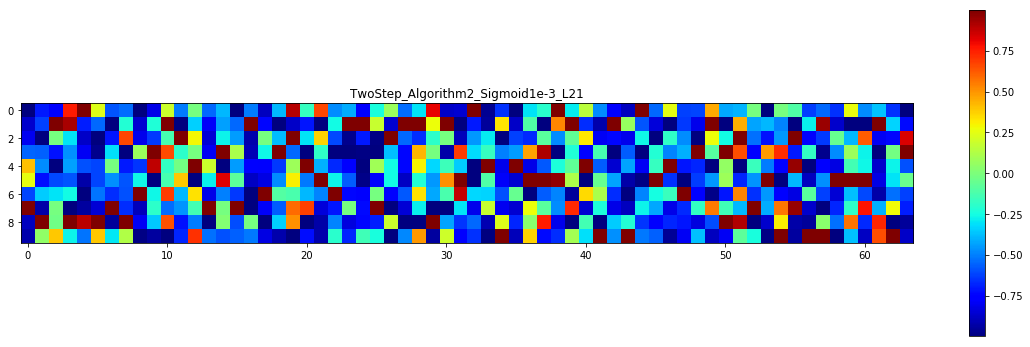

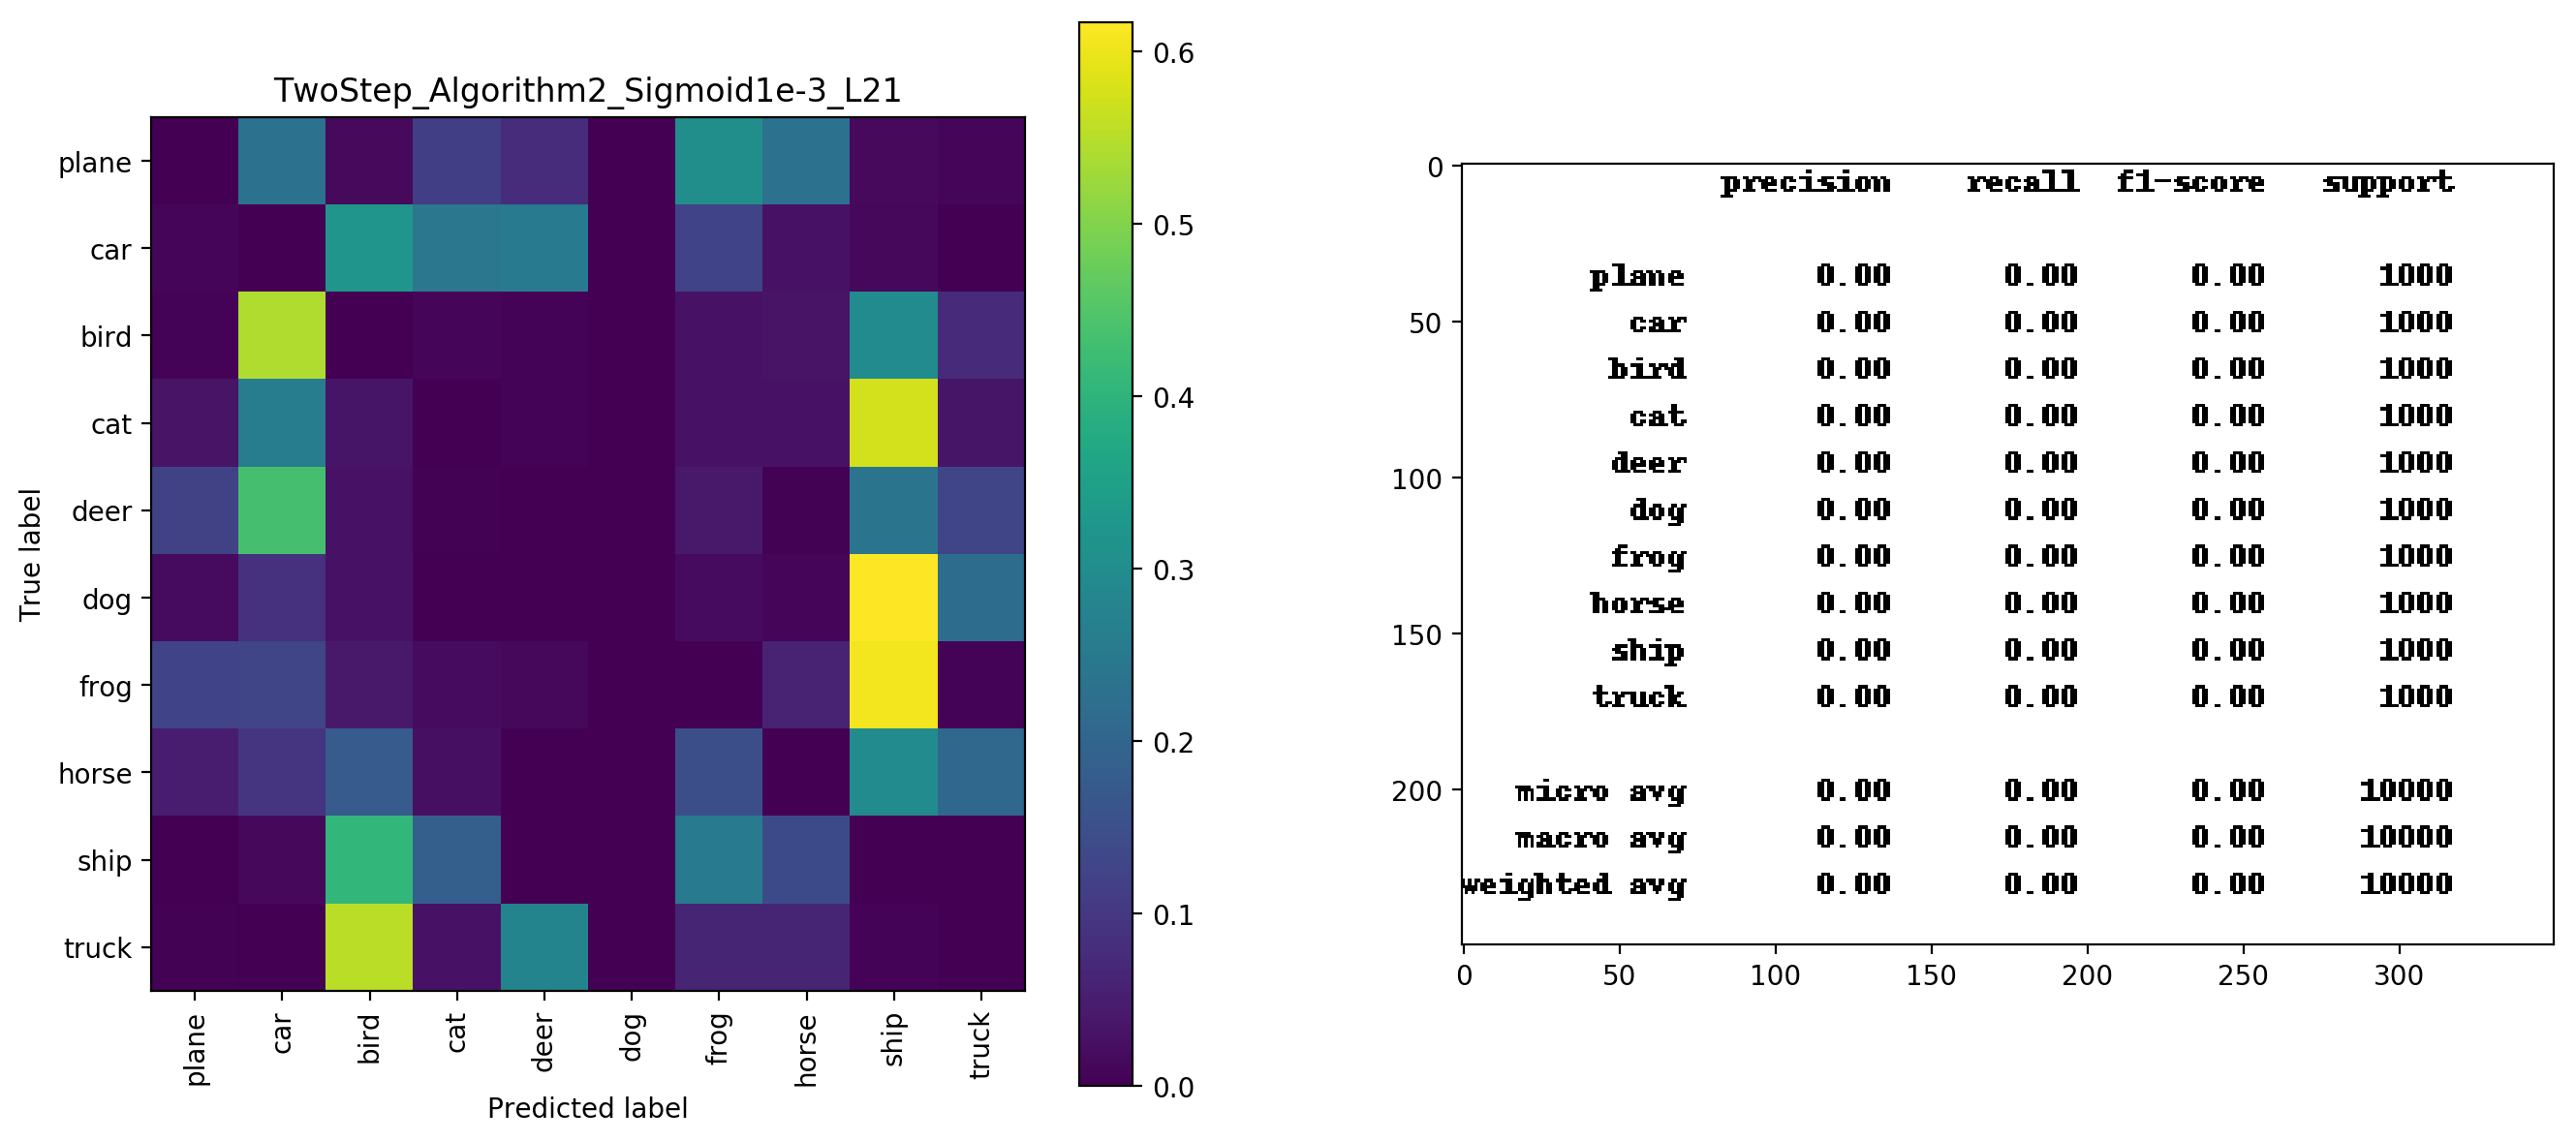

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid0.1_L1/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.0004


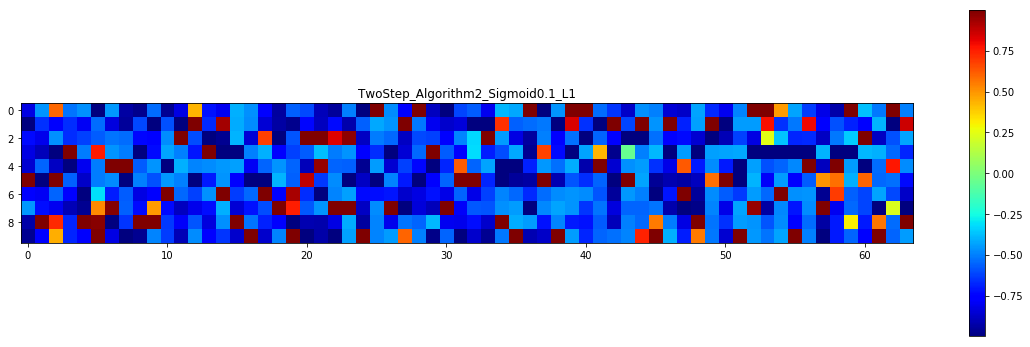

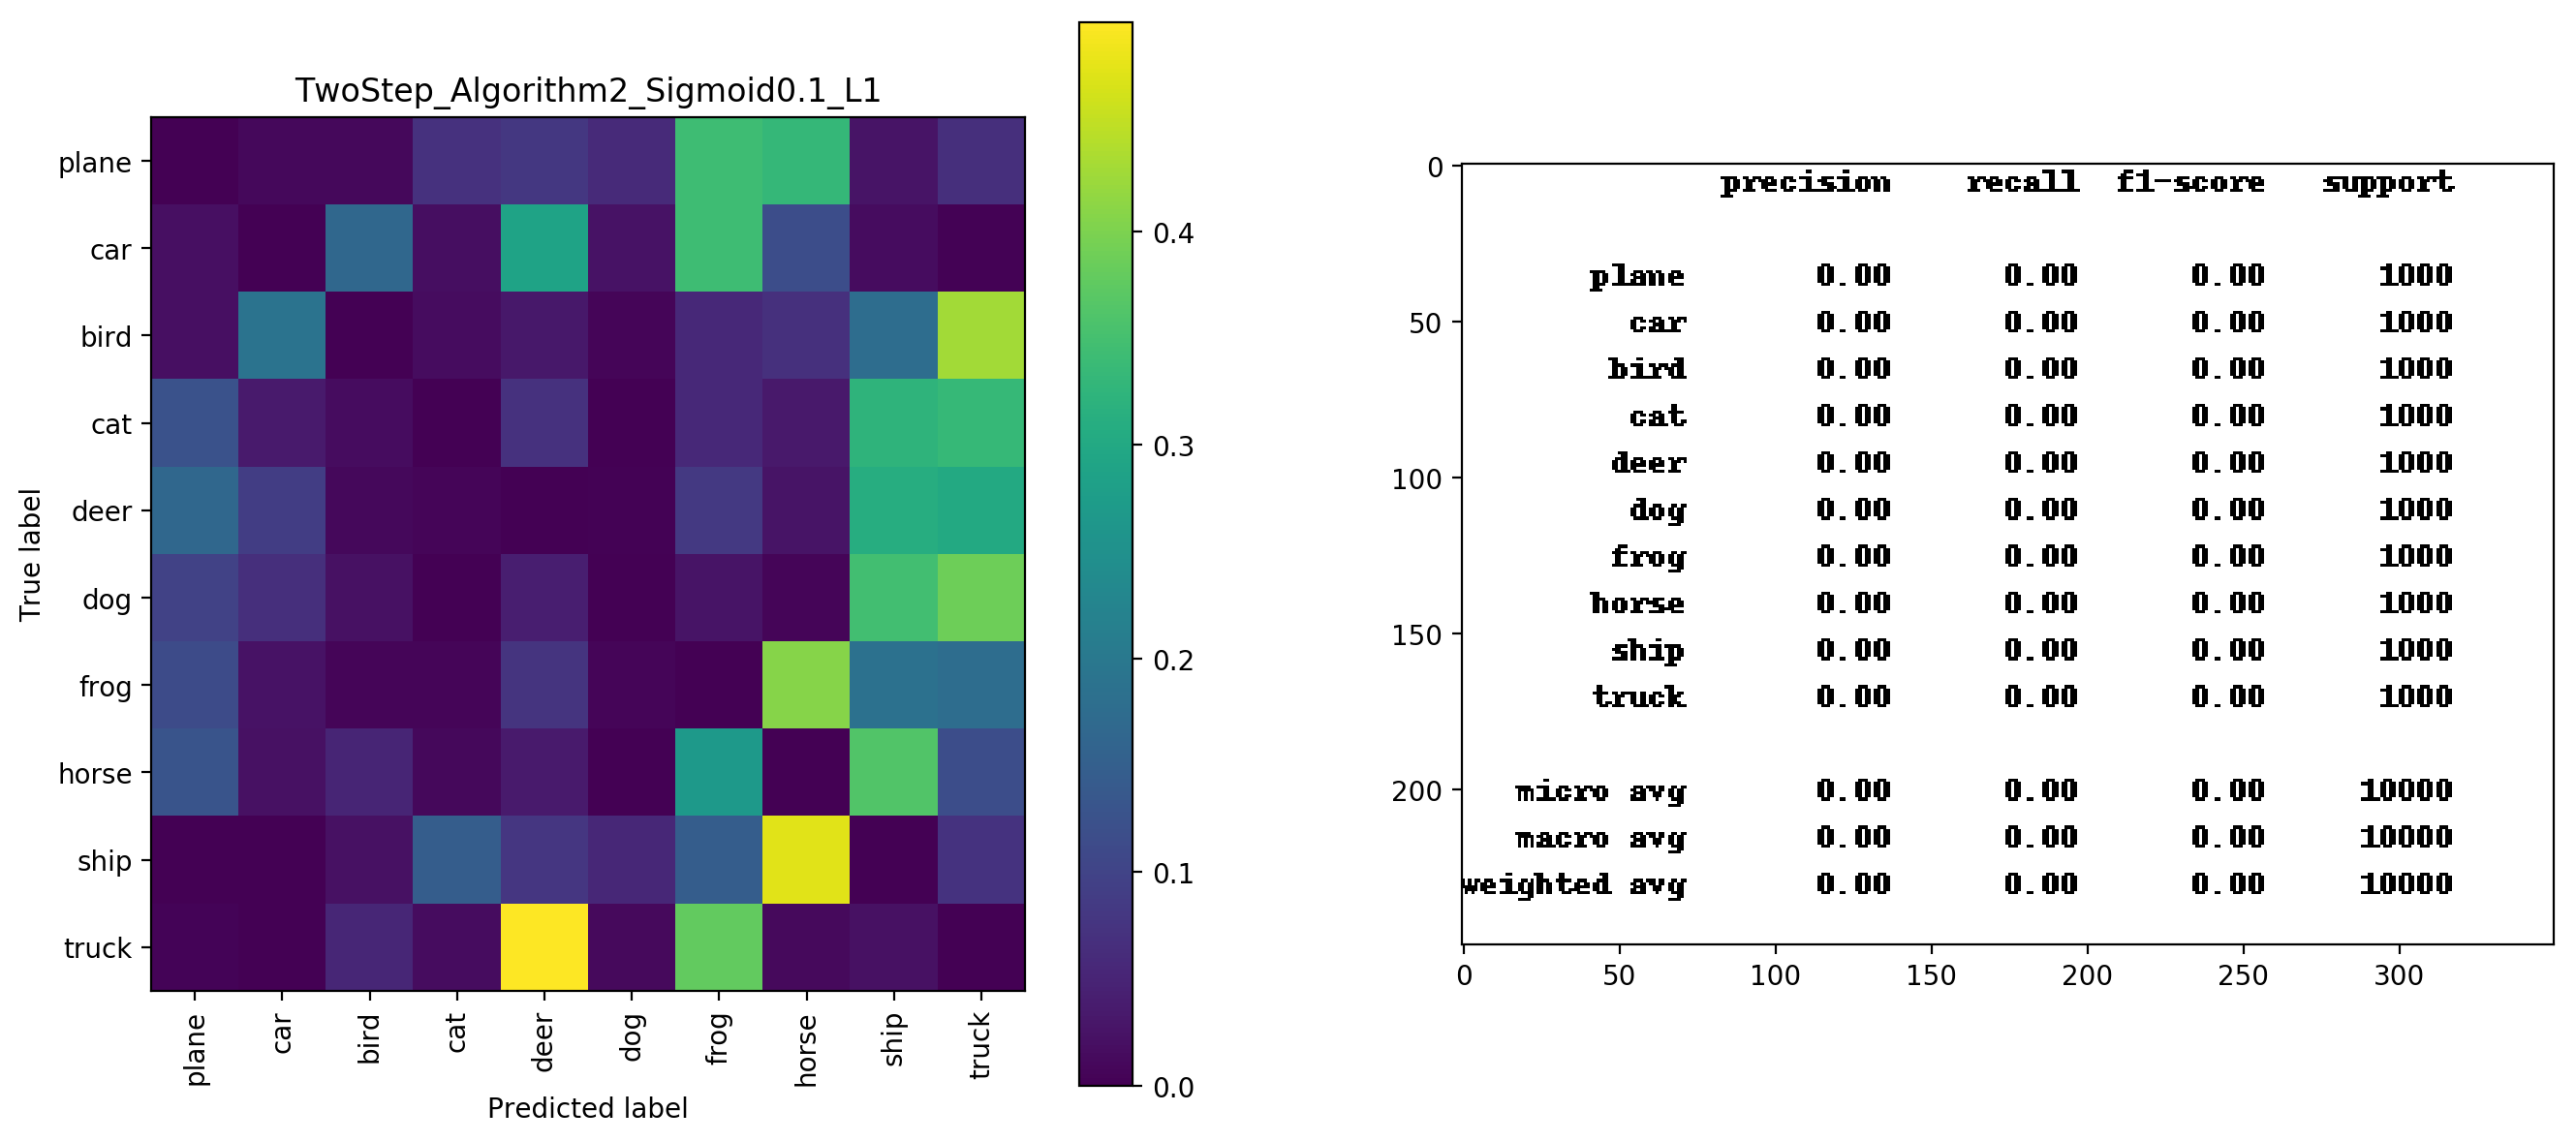

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid0.1_L12/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.0001


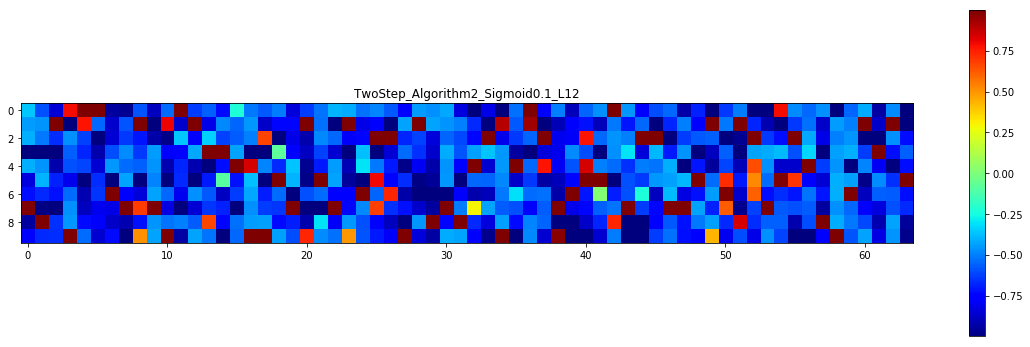

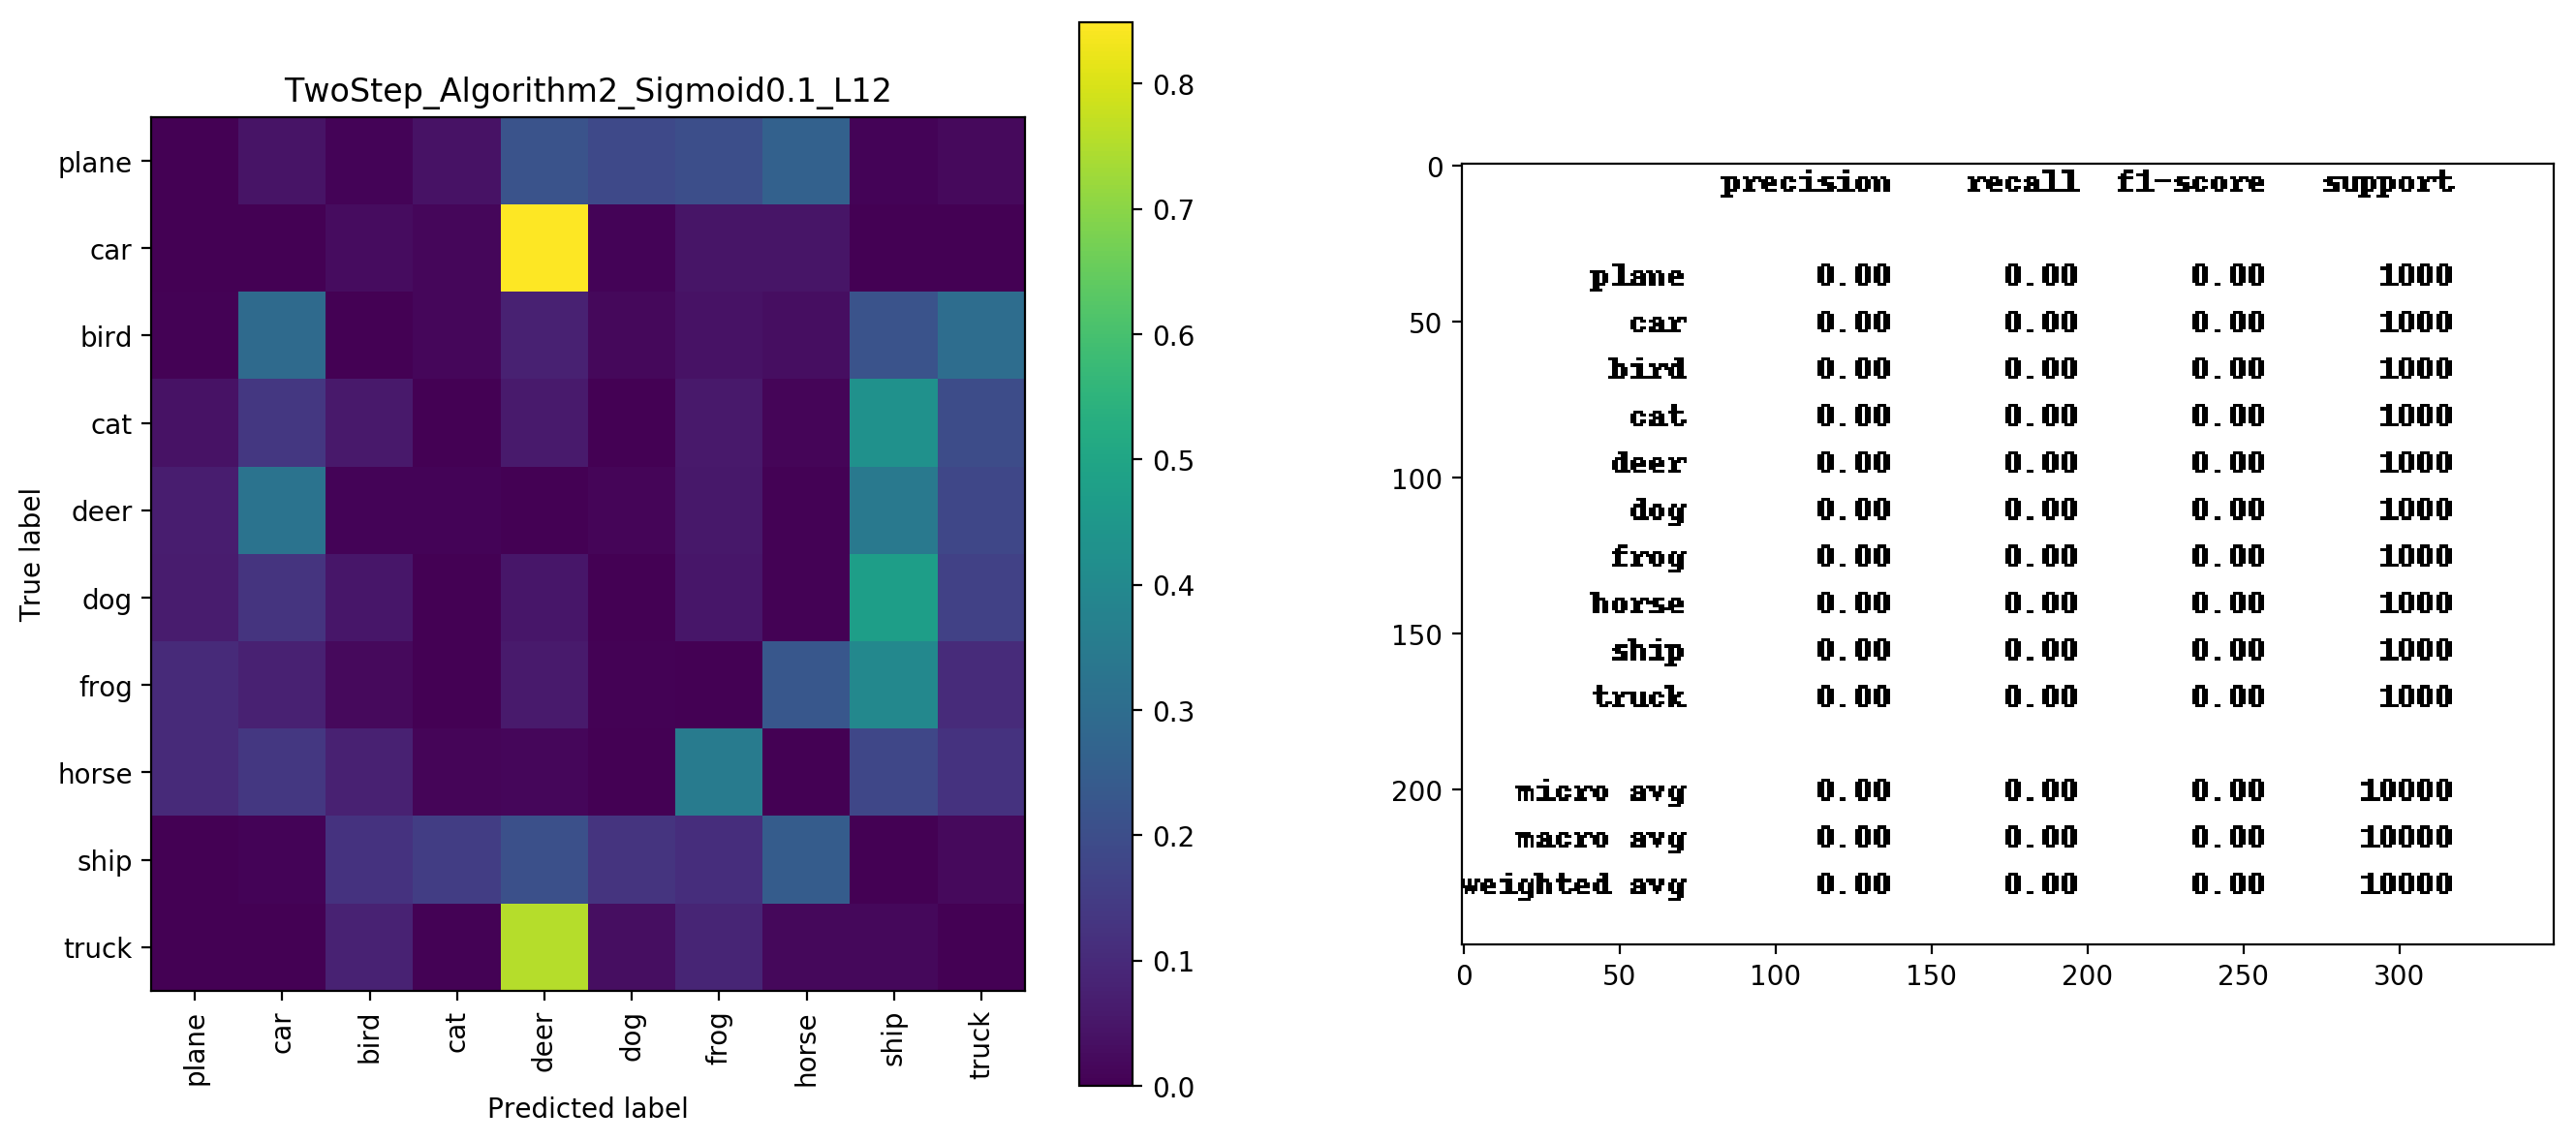

In [24]:
def get_weights(model):
    return model.module.lmask.mask
    def get_channel_mask(c_mask):
        delta_scale = 1
        c_mask = torch.sigmoid(c_mask/delta_scale)
        return c_mask
#     return model.module.lmask.get_channel_mask()
    return get_channel_mask(model.module.lmask.mask)

exp_root = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/'
analysis_queue = [
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L1',
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L21',
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_Lmax',
    'TwoStep_Algorithm2_Sigmoid10_L1',
    'TwoStep_Algorithm2_Sigmoid10_Lmax',
    
    'TwoStep_Algorithm2_Sigmoid1e-3_L21',
    'TwoStep_Algorithm2_Sigmoid0.1_L1',
    'TwoStep_Algorithm2_Sigmoid0.1_L12',
]
analysis_queue = [exp_root+var for var in analysis_queue]
for item in analysis_queue:
    show_res(item)

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L1/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7212


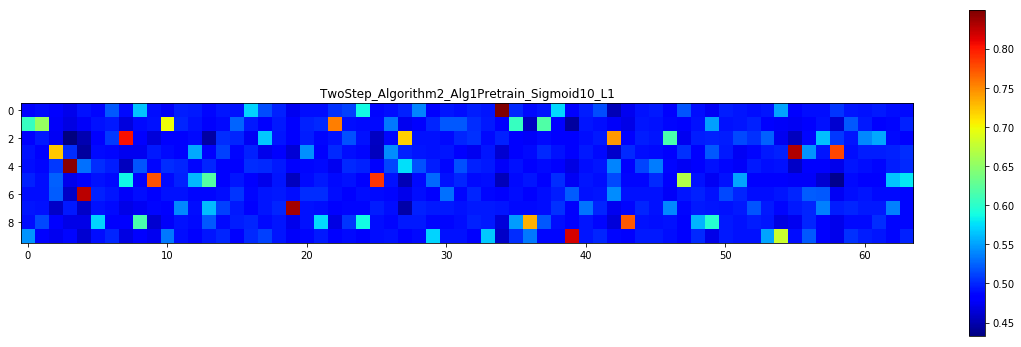

/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


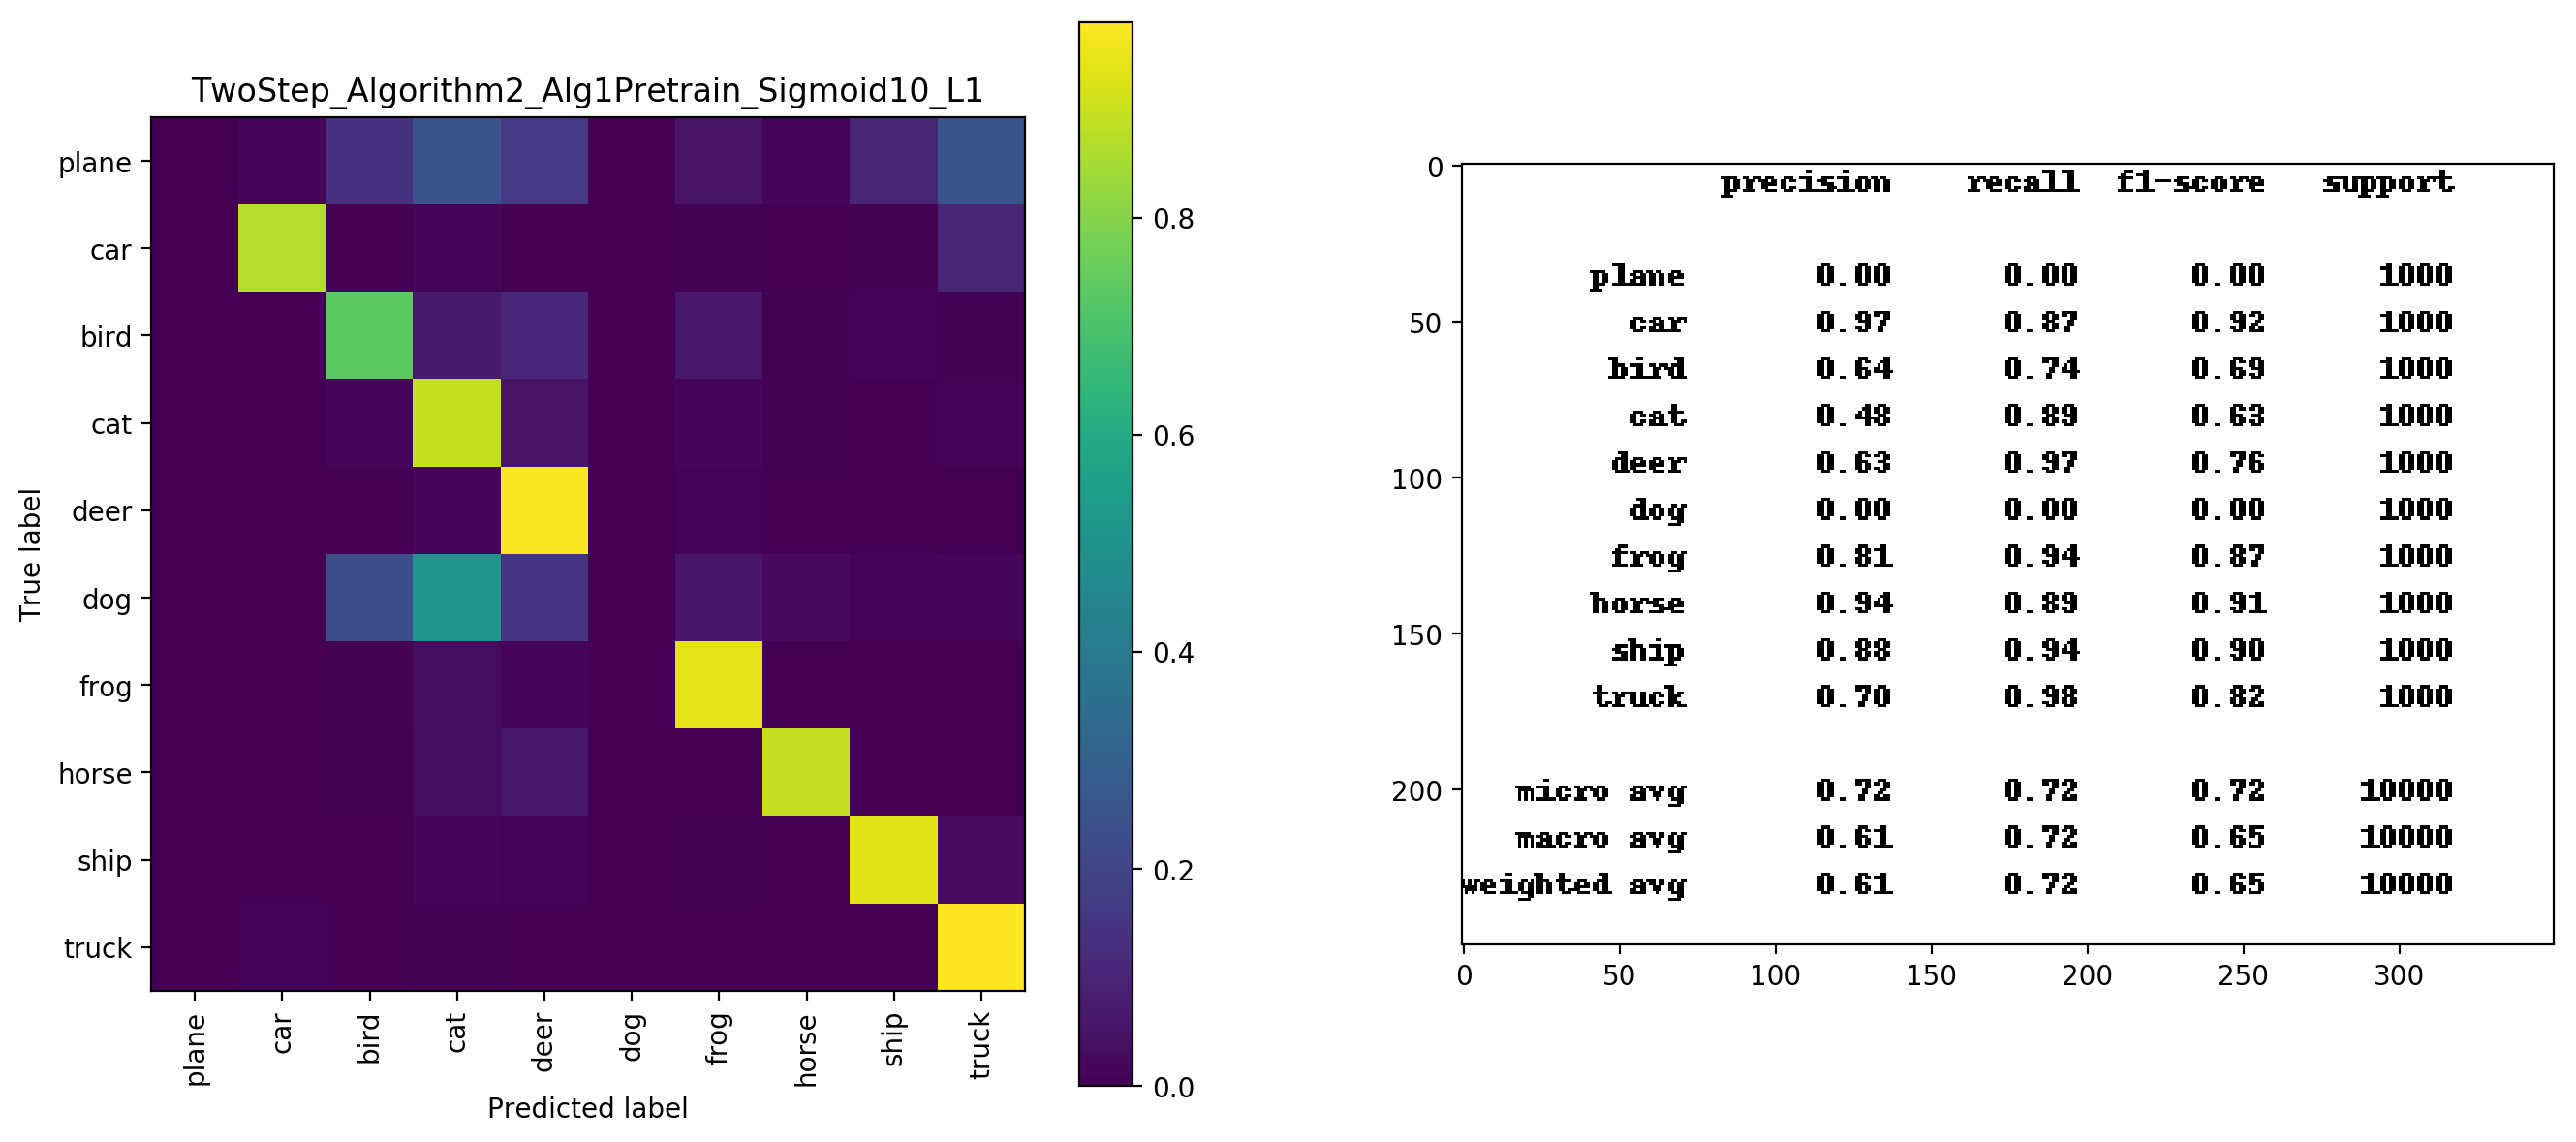

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L21/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7186


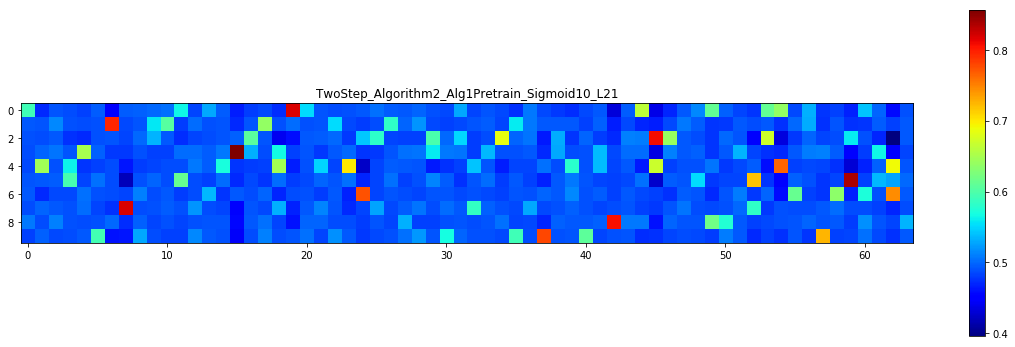

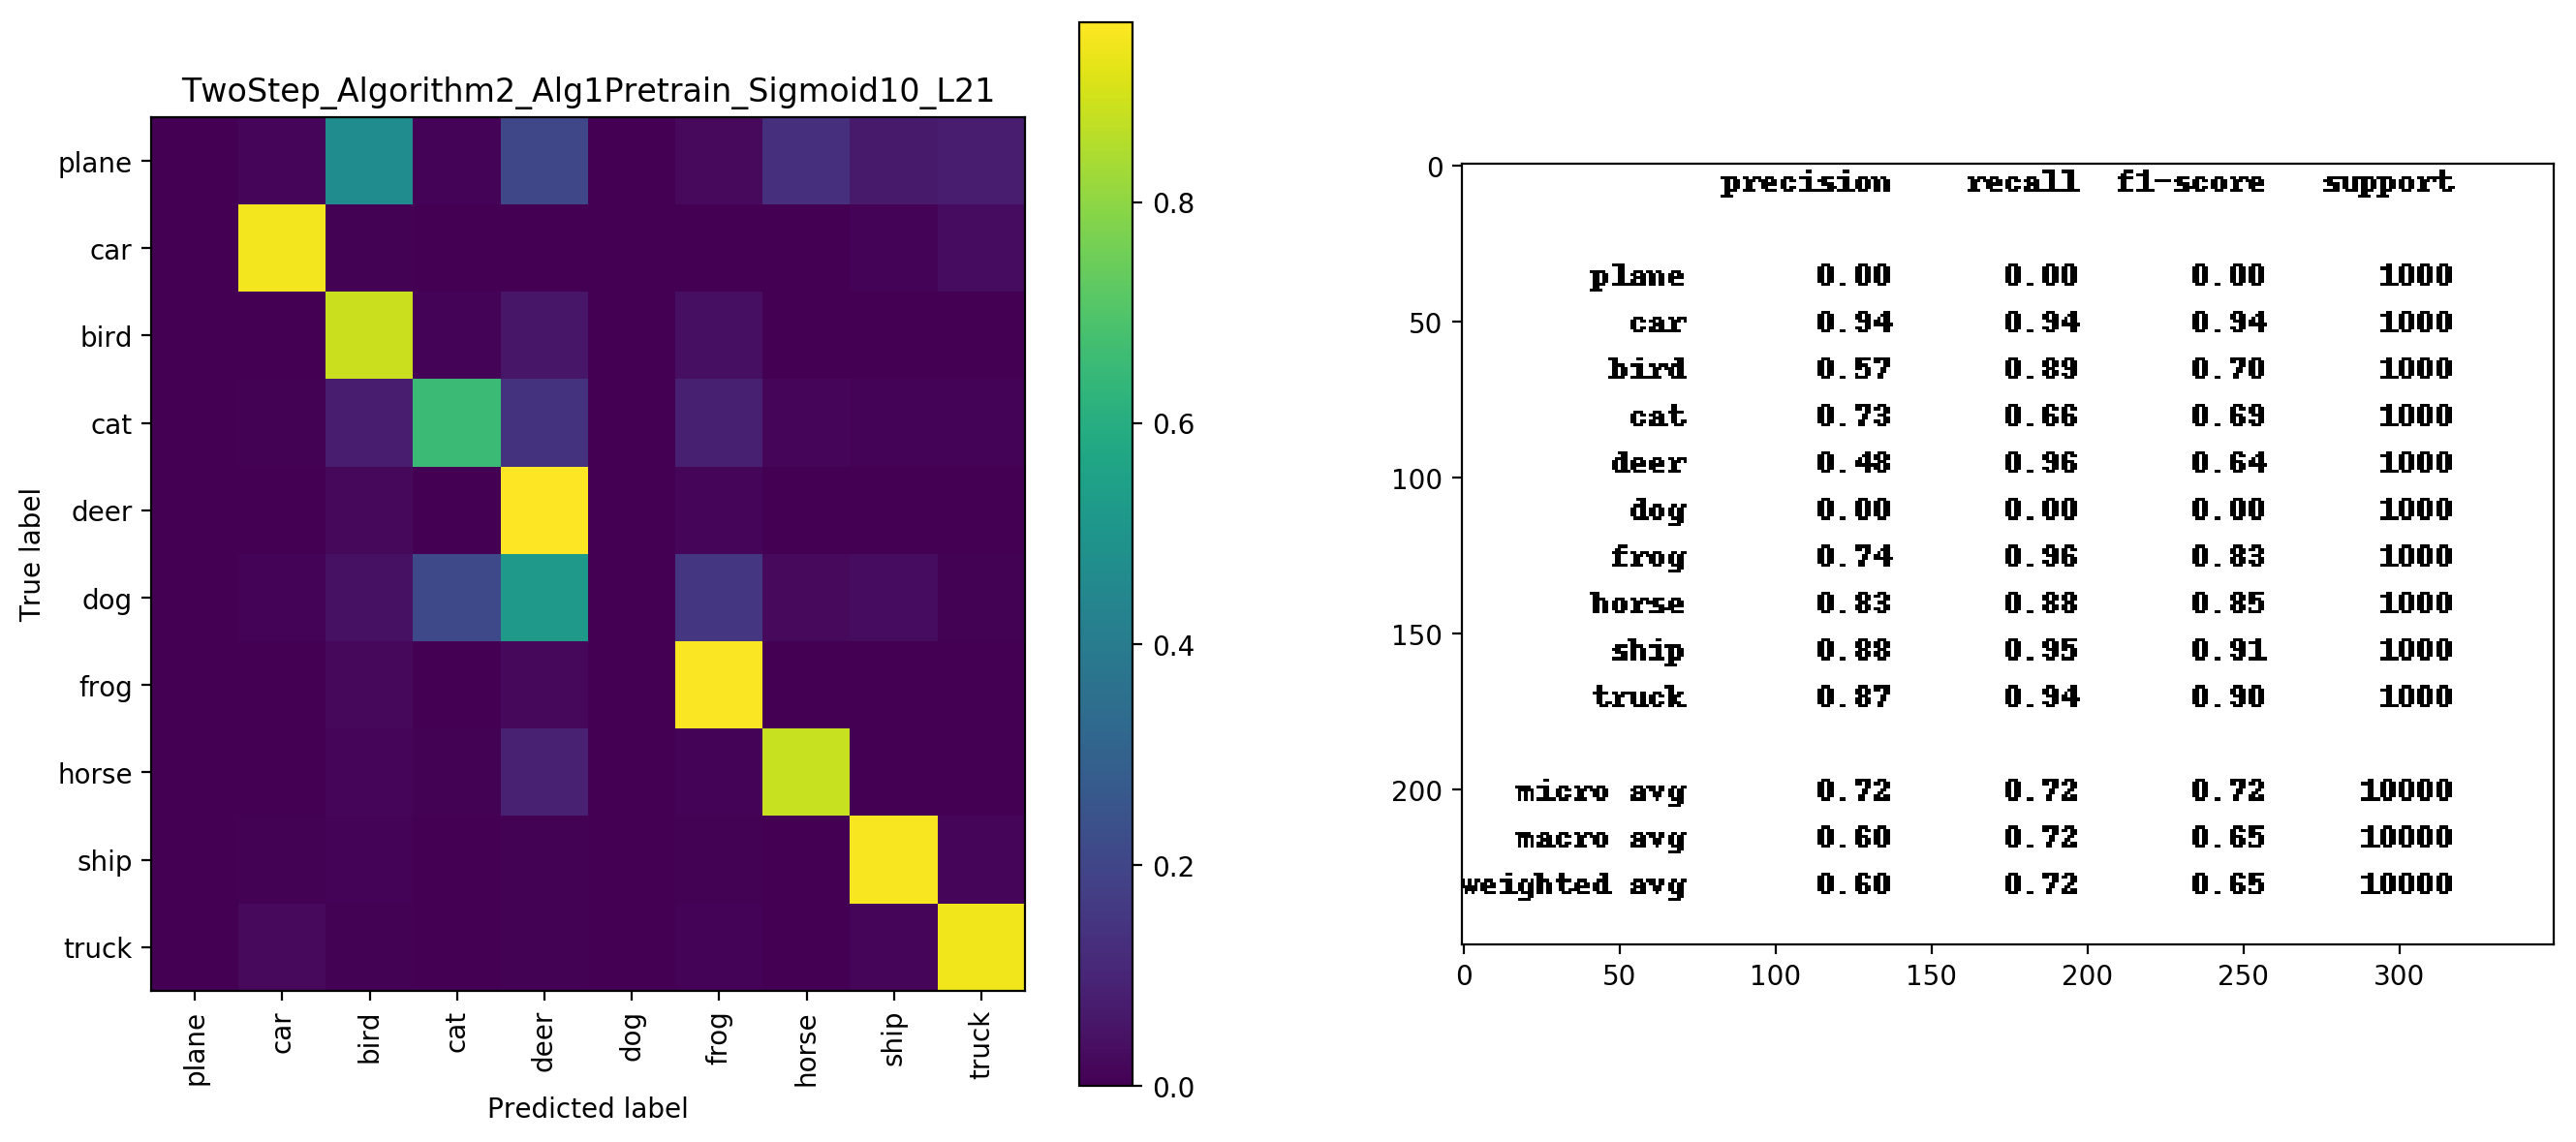

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_Lmax/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.1792


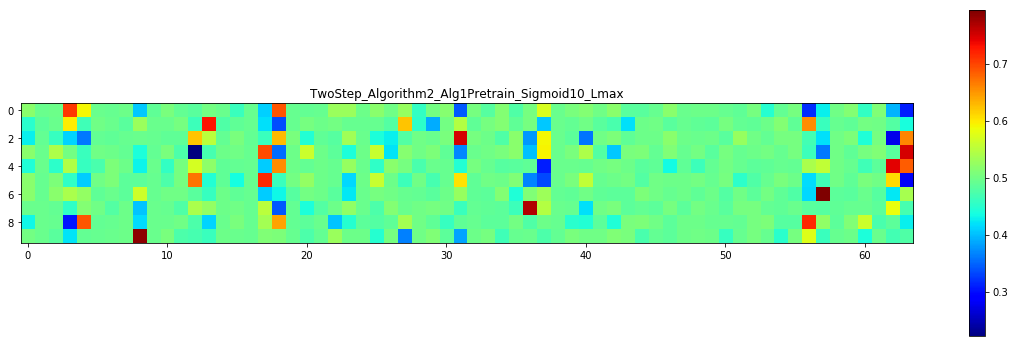

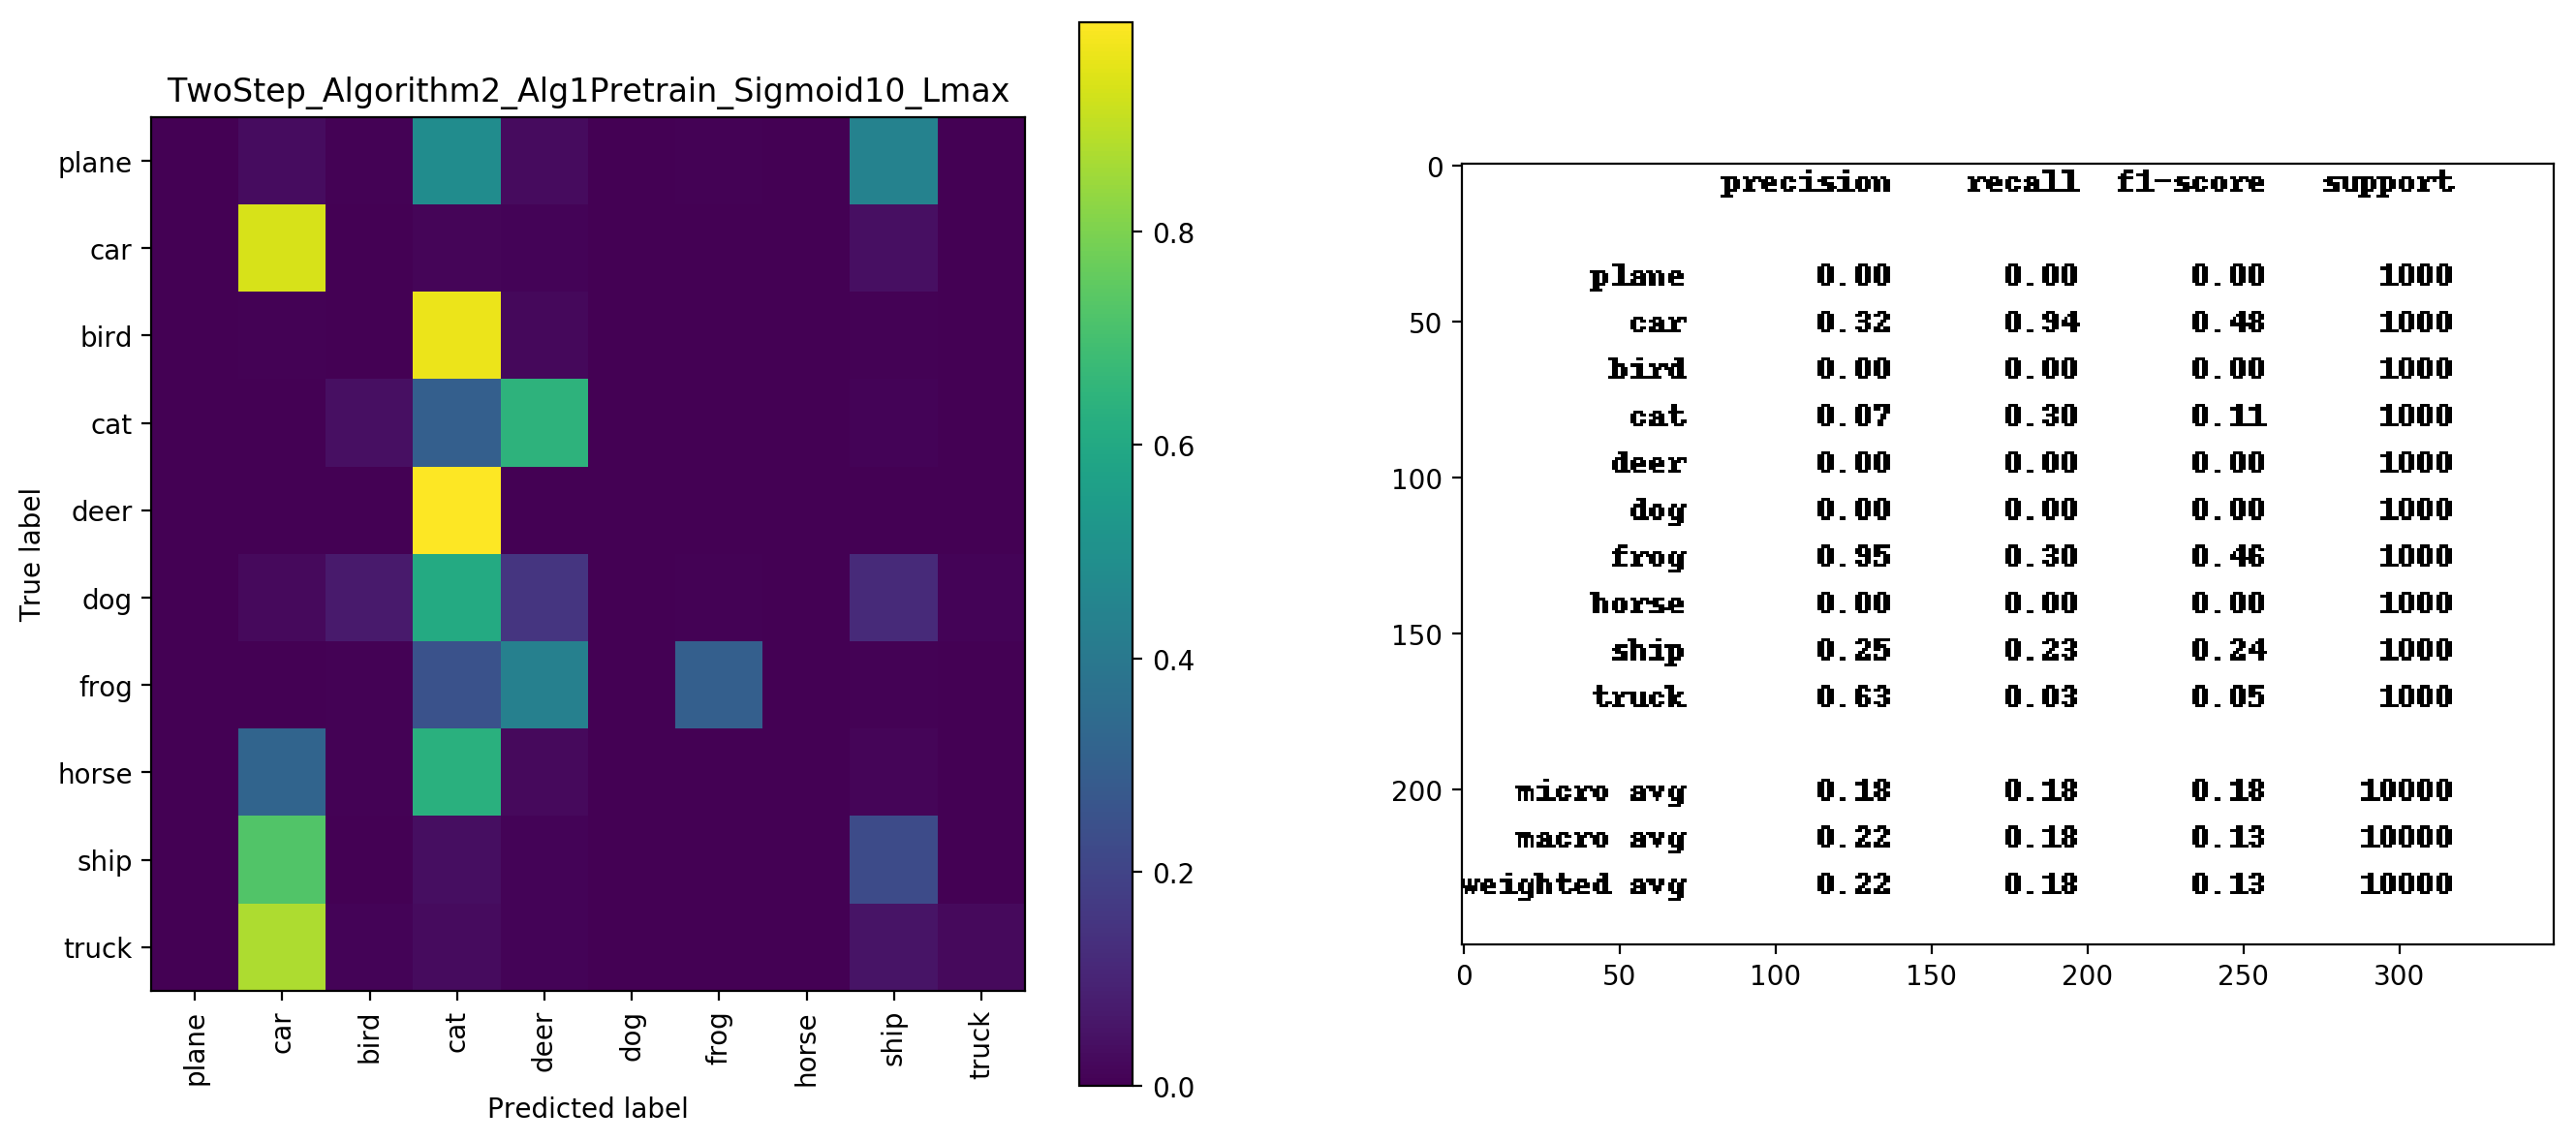

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid10_L1/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.0002


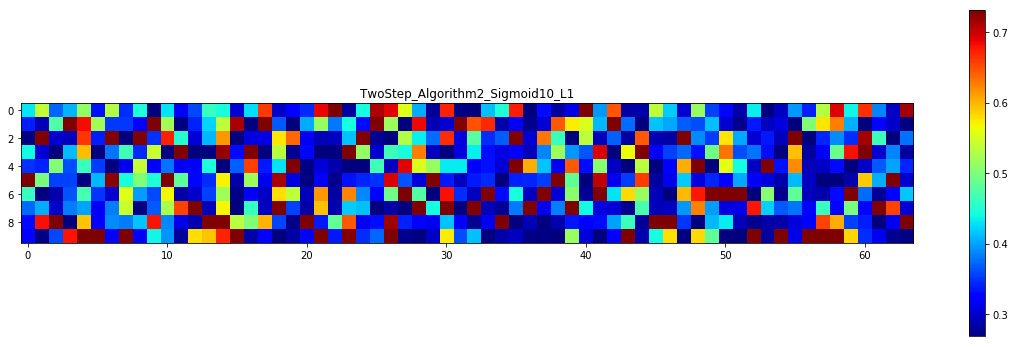

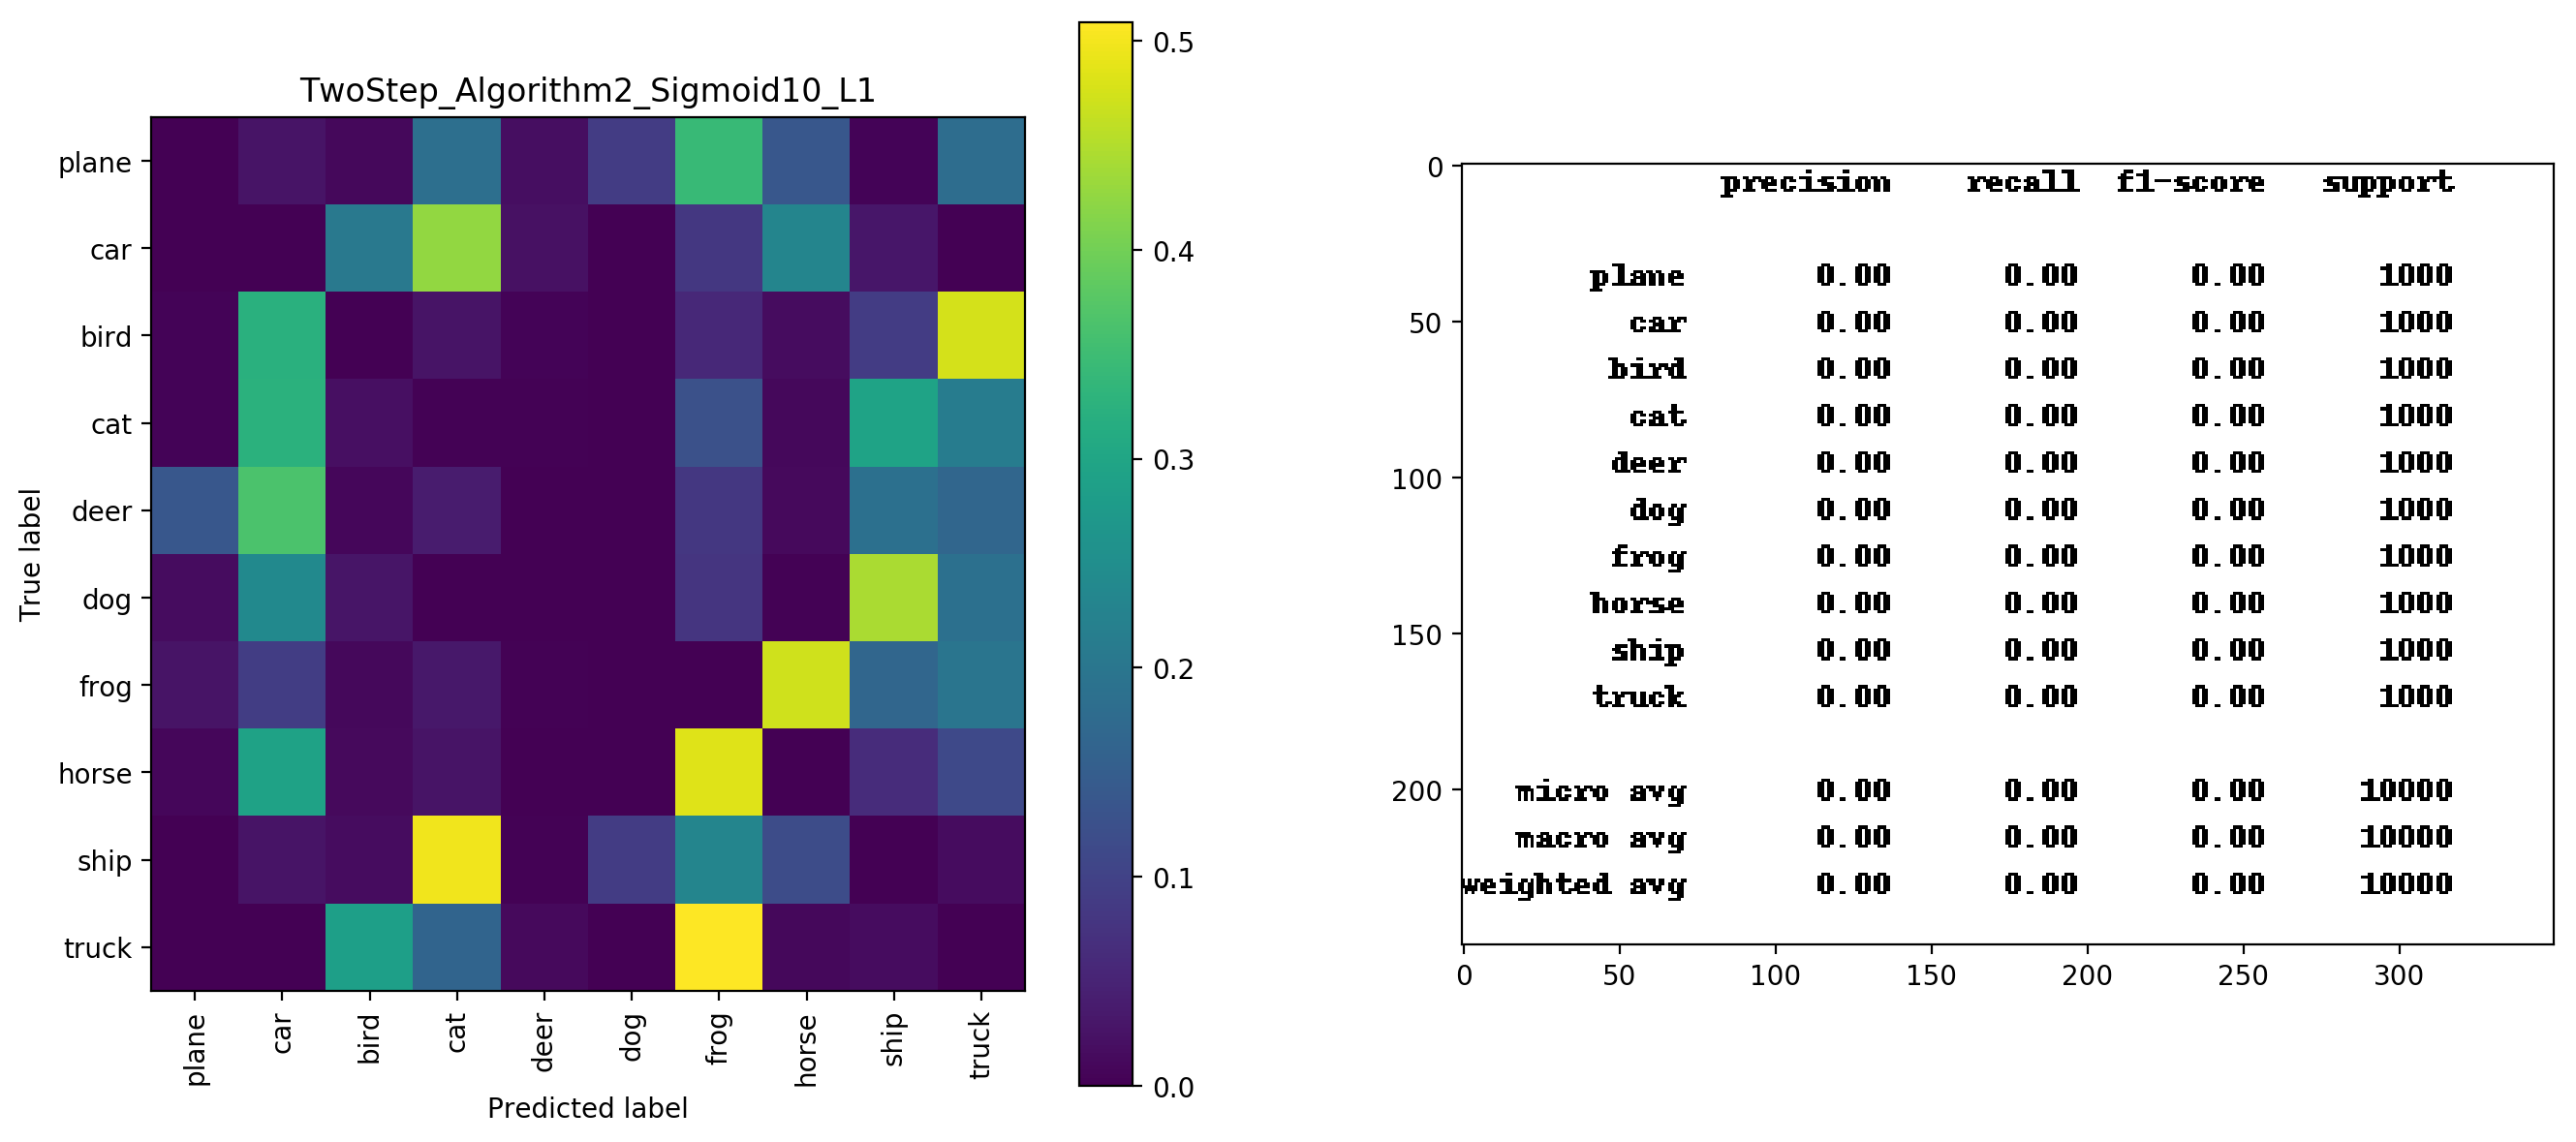

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid10_Lmax/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.3018


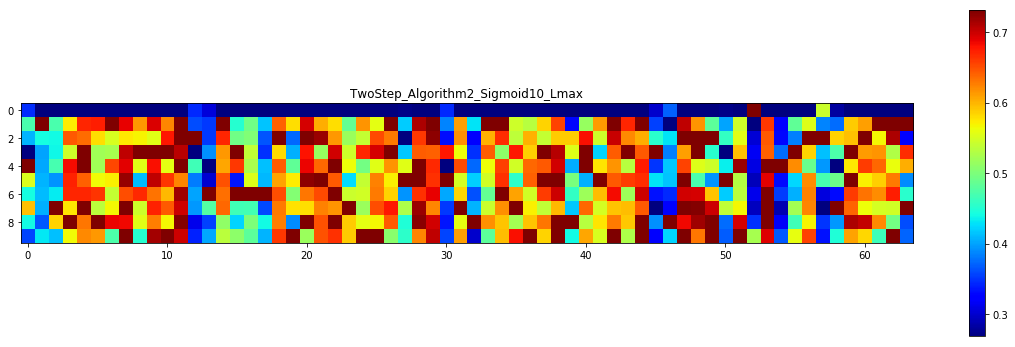

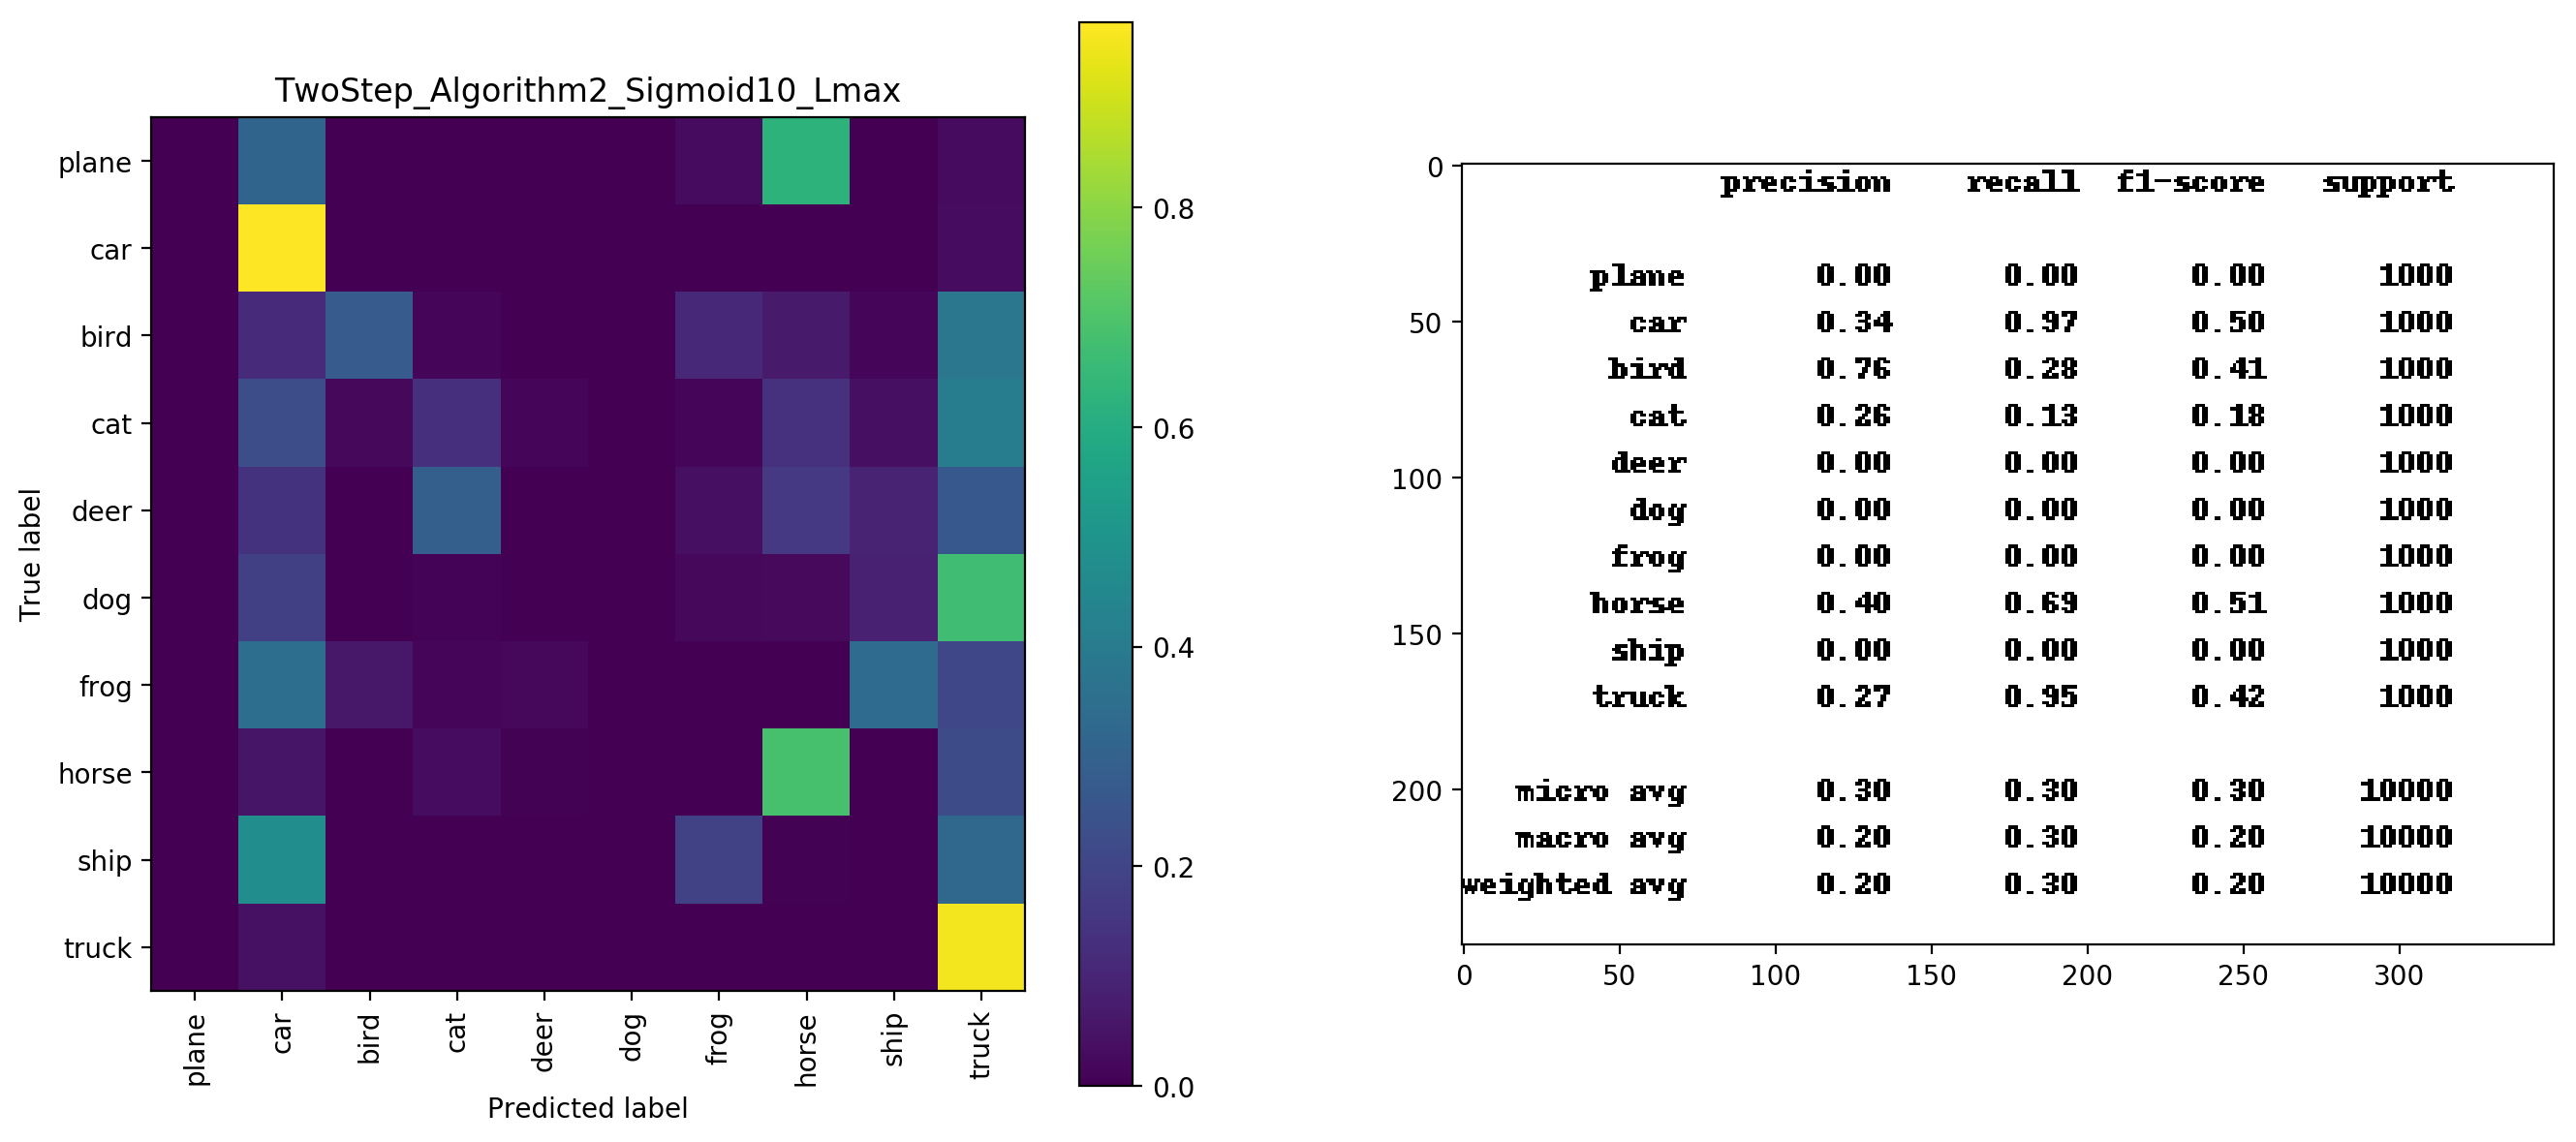

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid1e-3_L21/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.0002


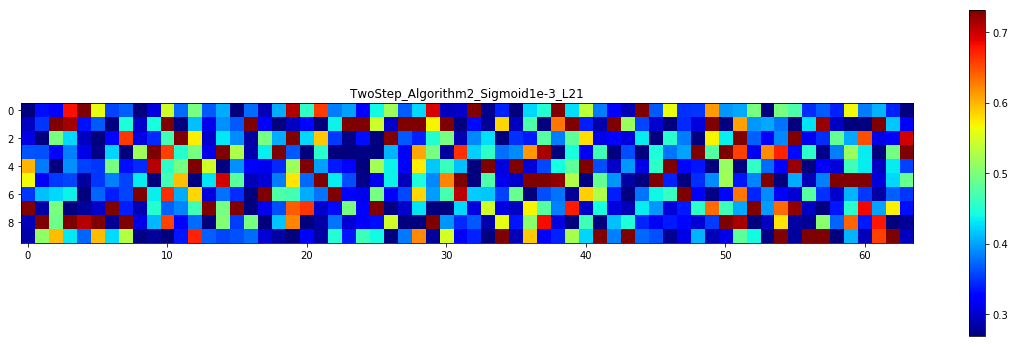

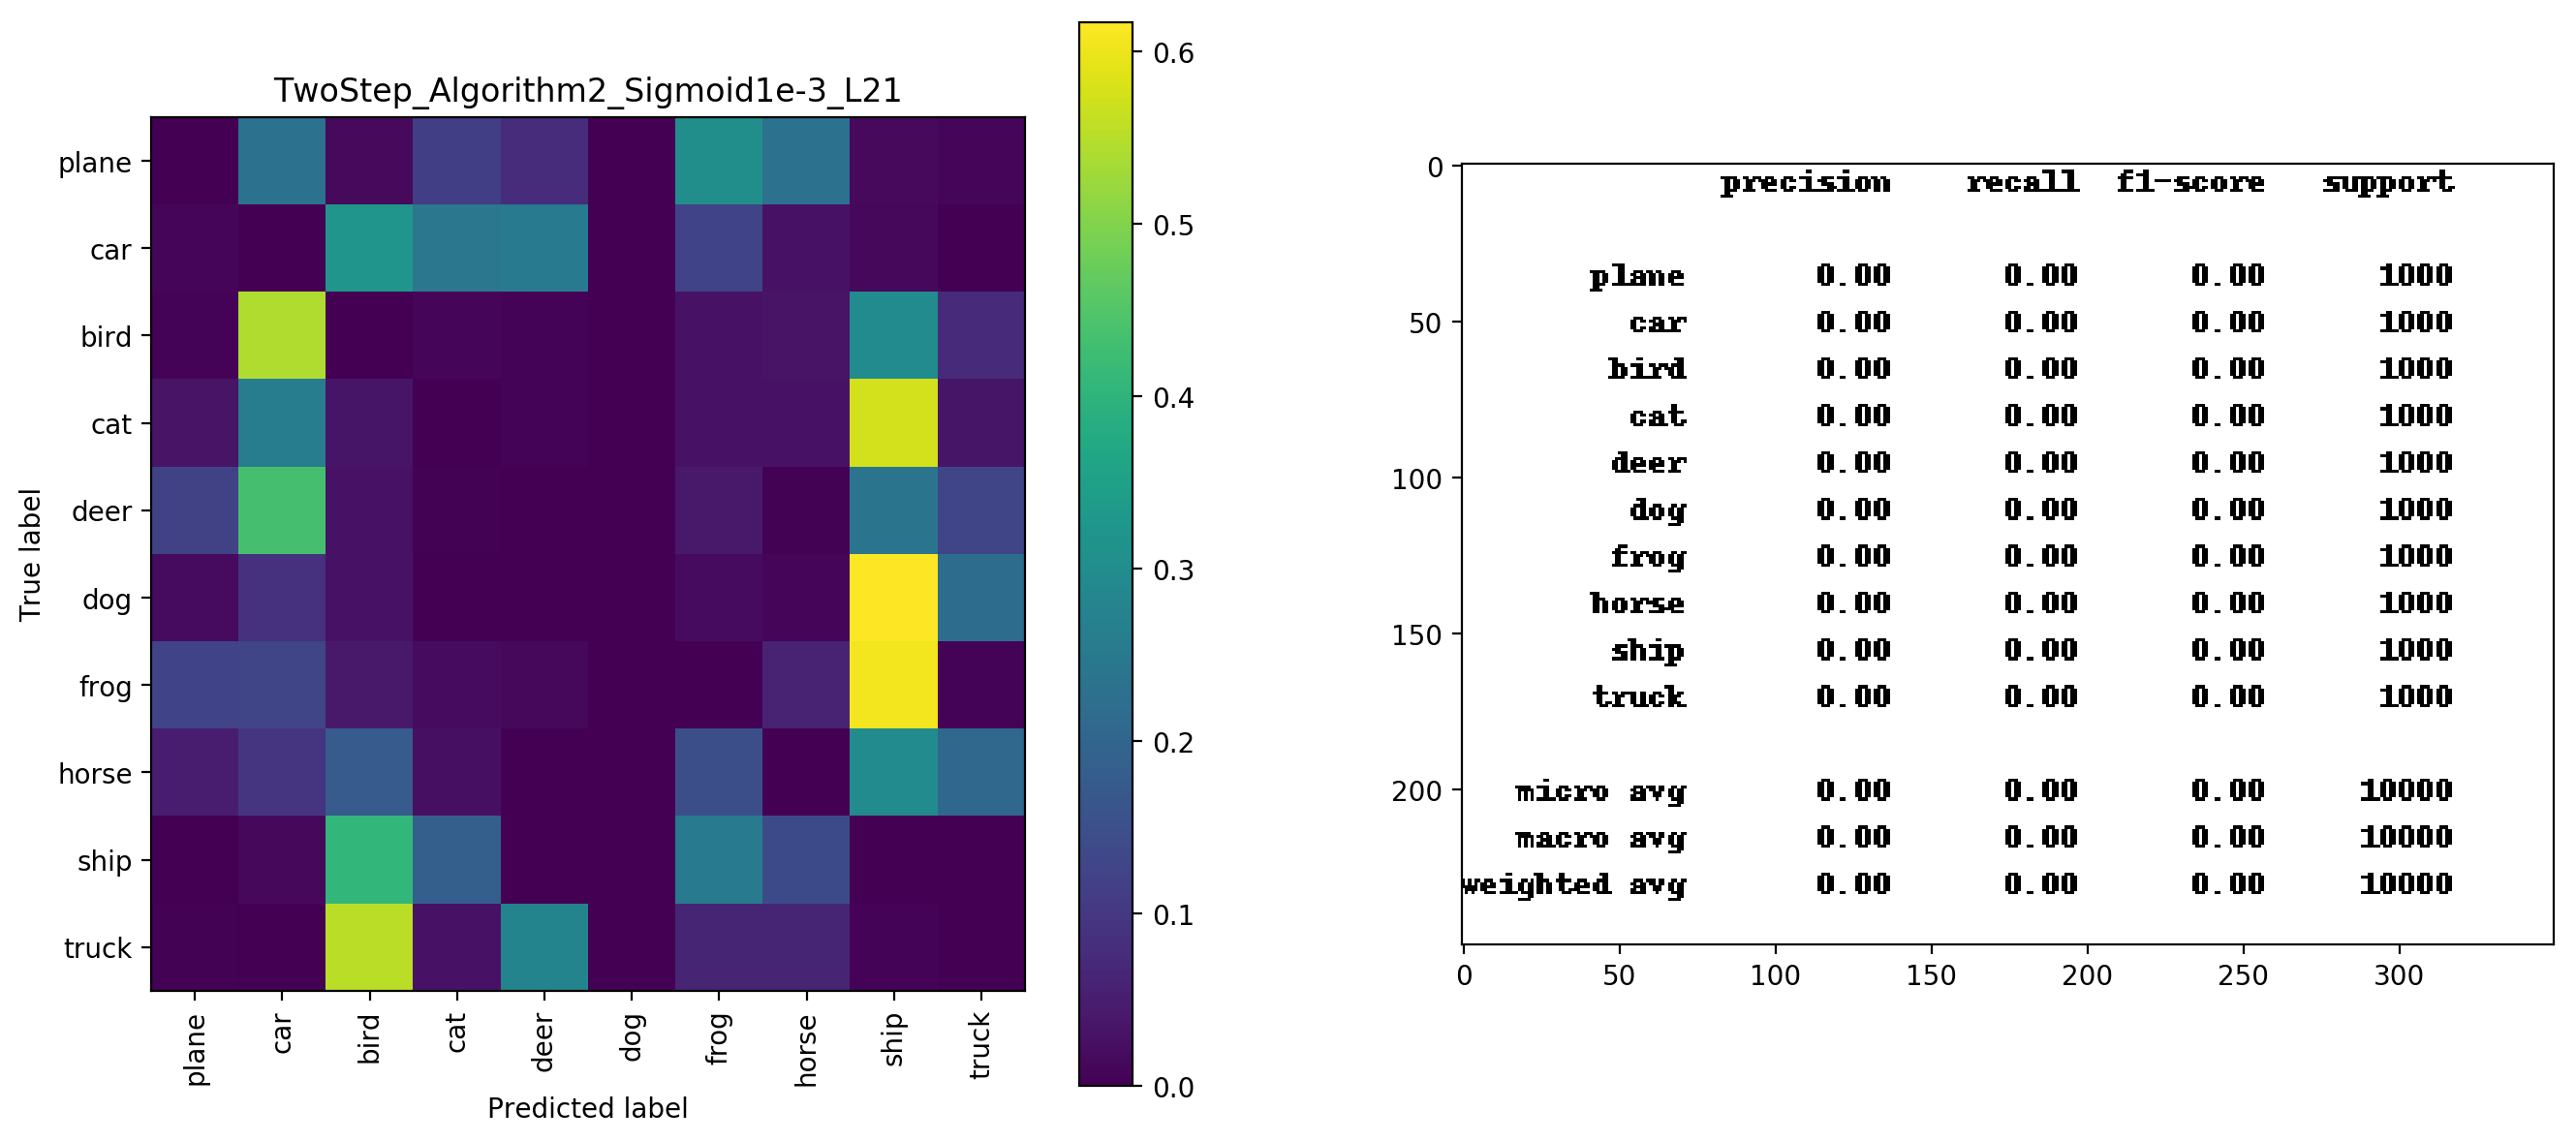

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid0.1_L1/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.0004


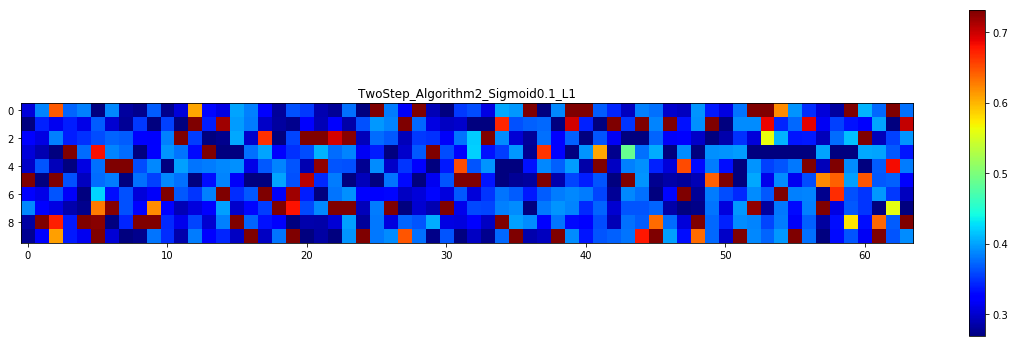

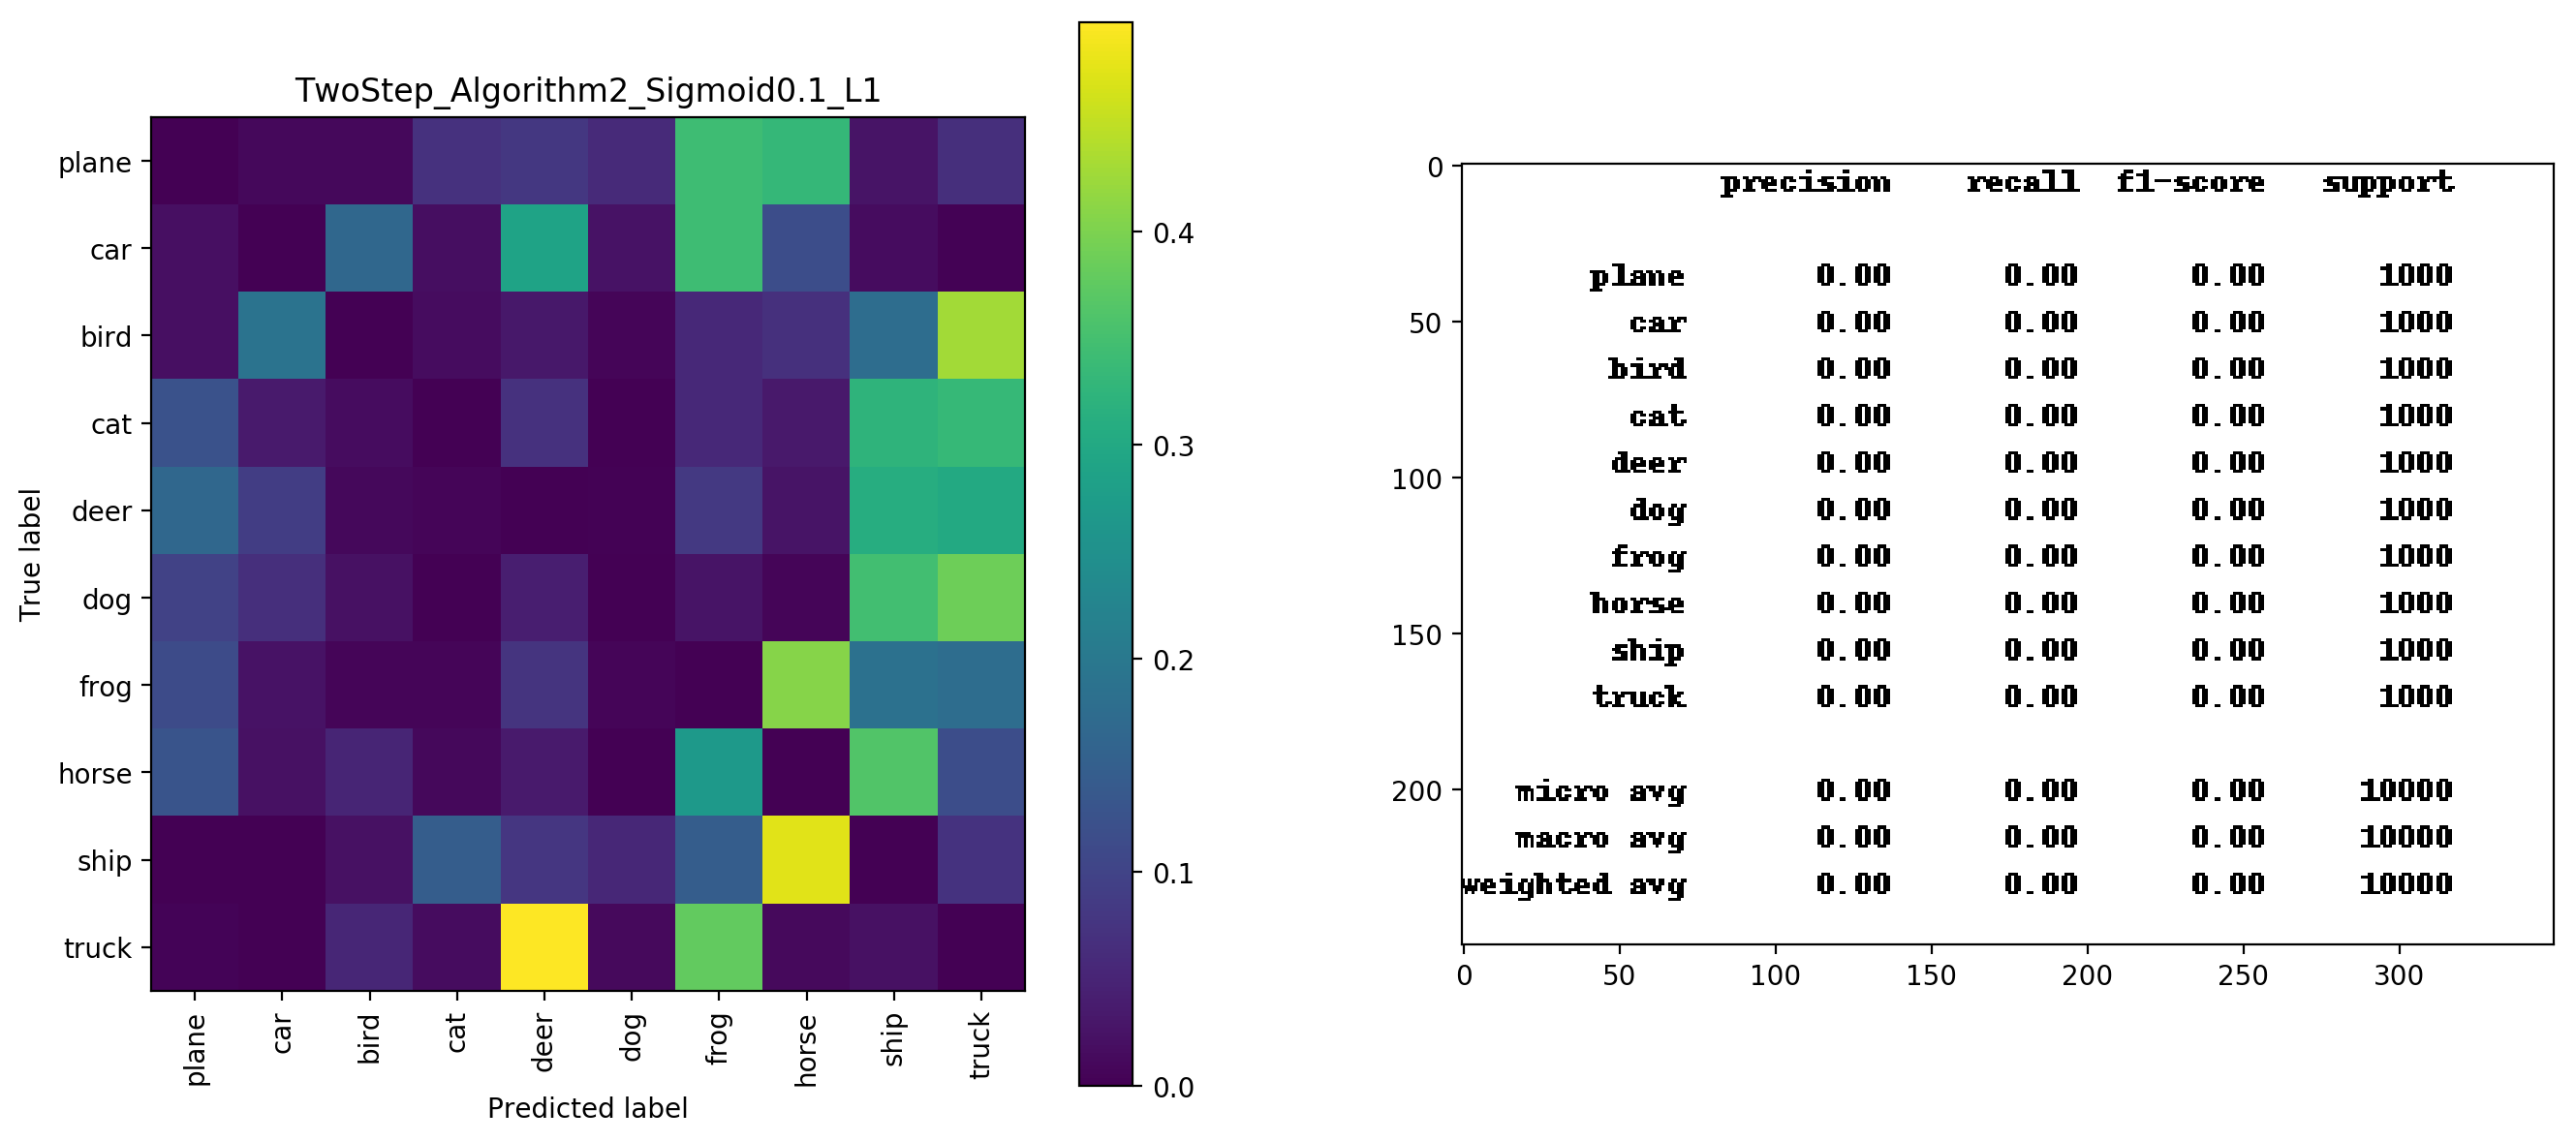

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Sigmoid0.1_L12/saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.0001


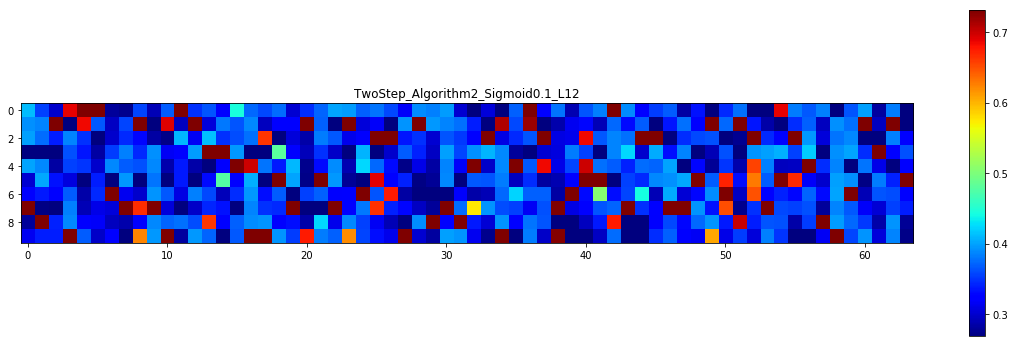

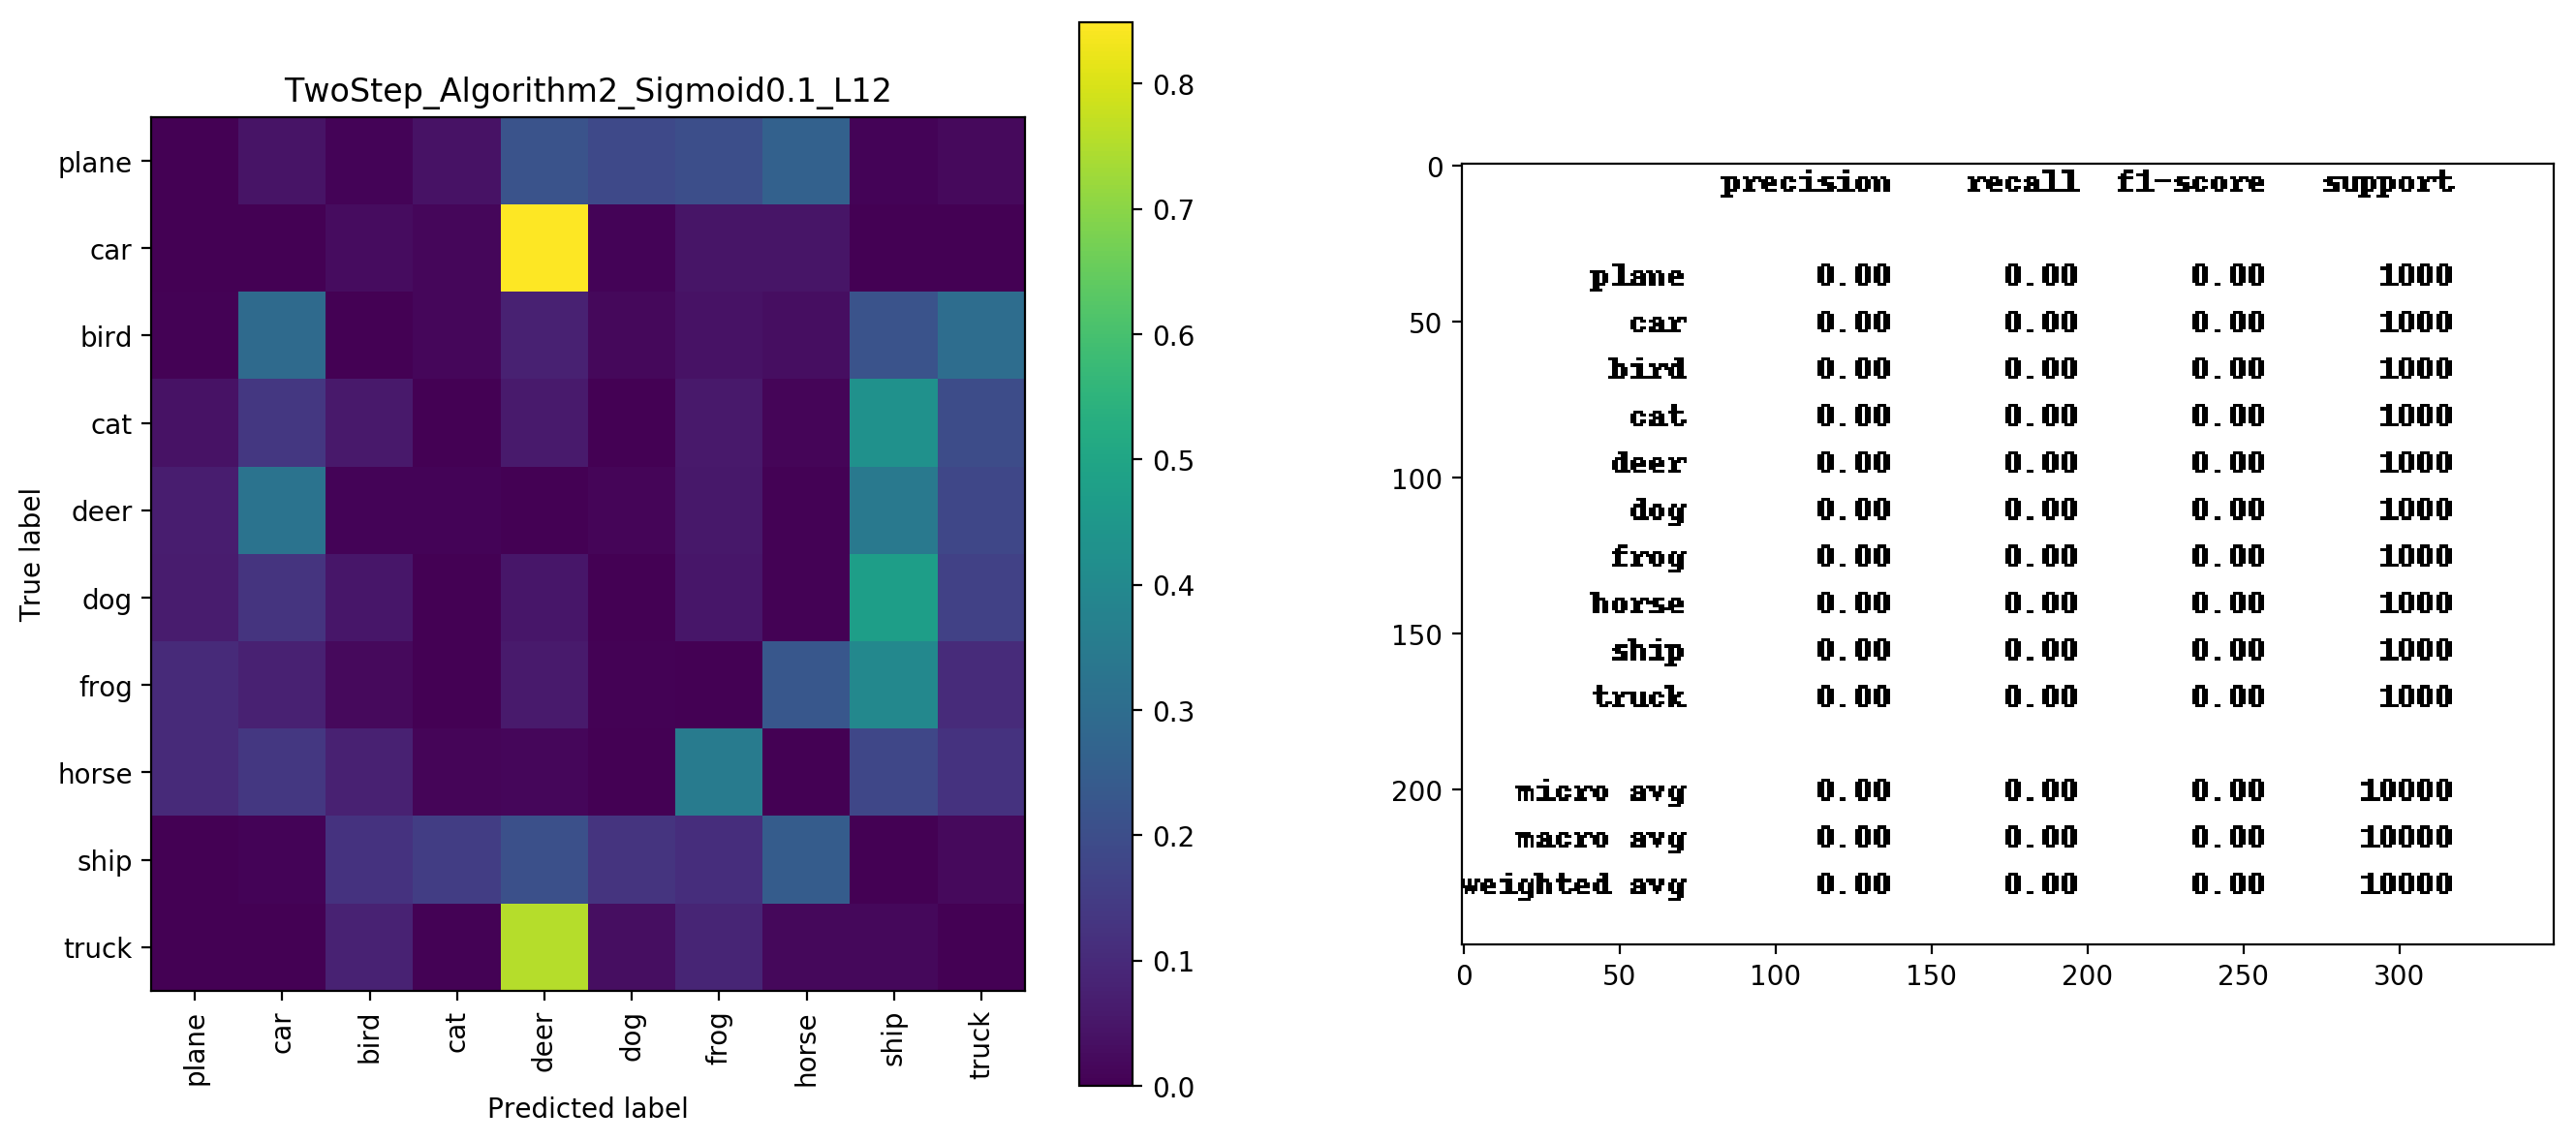

In [25]:
def get_weights(model):
    return model.module.lmask.get_channel_mask()
#     def get_channel_mask(c_mask):
#         delta_scale = 1
#         c_mask = torch.sigmoid(c_mask/delta_scale)
#         return c_mask
#     return get_channel_mask(model.module.lmask.mask)

exp_root = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/'
analysis_queue = [
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L1',
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L21',
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_Lmax',
    'TwoStep_Algorithm2_Sigmoid10_L1',
    'TwoStep_Algorithm2_Sigmoid10_Lmax',
    
    'TwoStep_Algorithm2_Sigmoid1e-3_L21',
    'TwoStep_Algorithm2_Sigmoid0.1_L1',
    'TwoStep_Algorithm2_Sigmoid0.1_L12',
]
analysis_queue = [exp_root+var for var in analysis_queue]
for item in analysis_queue:
    show_res(item)

# Different Sigmoid Function

## 0.1 \delta

Successfully Load Model:  /data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L1/saved_model.pt


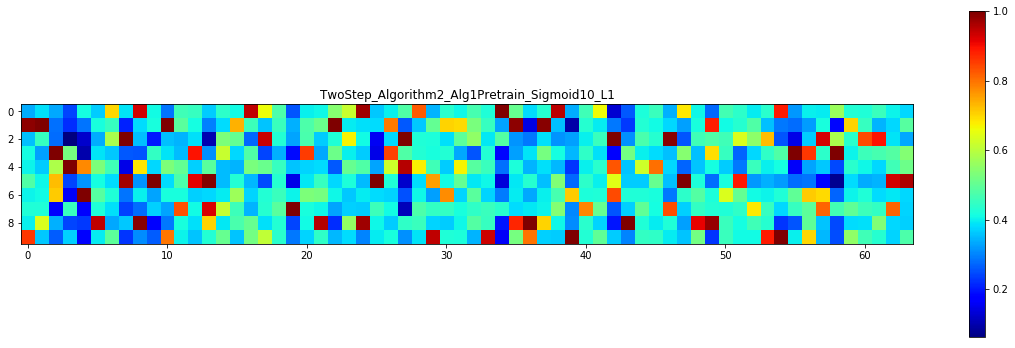

/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/matplotlib/image.py:855: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)
/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


ValueError: Number of classes, 0, does not match size of target_names, 10. Try specifying the labels parameter

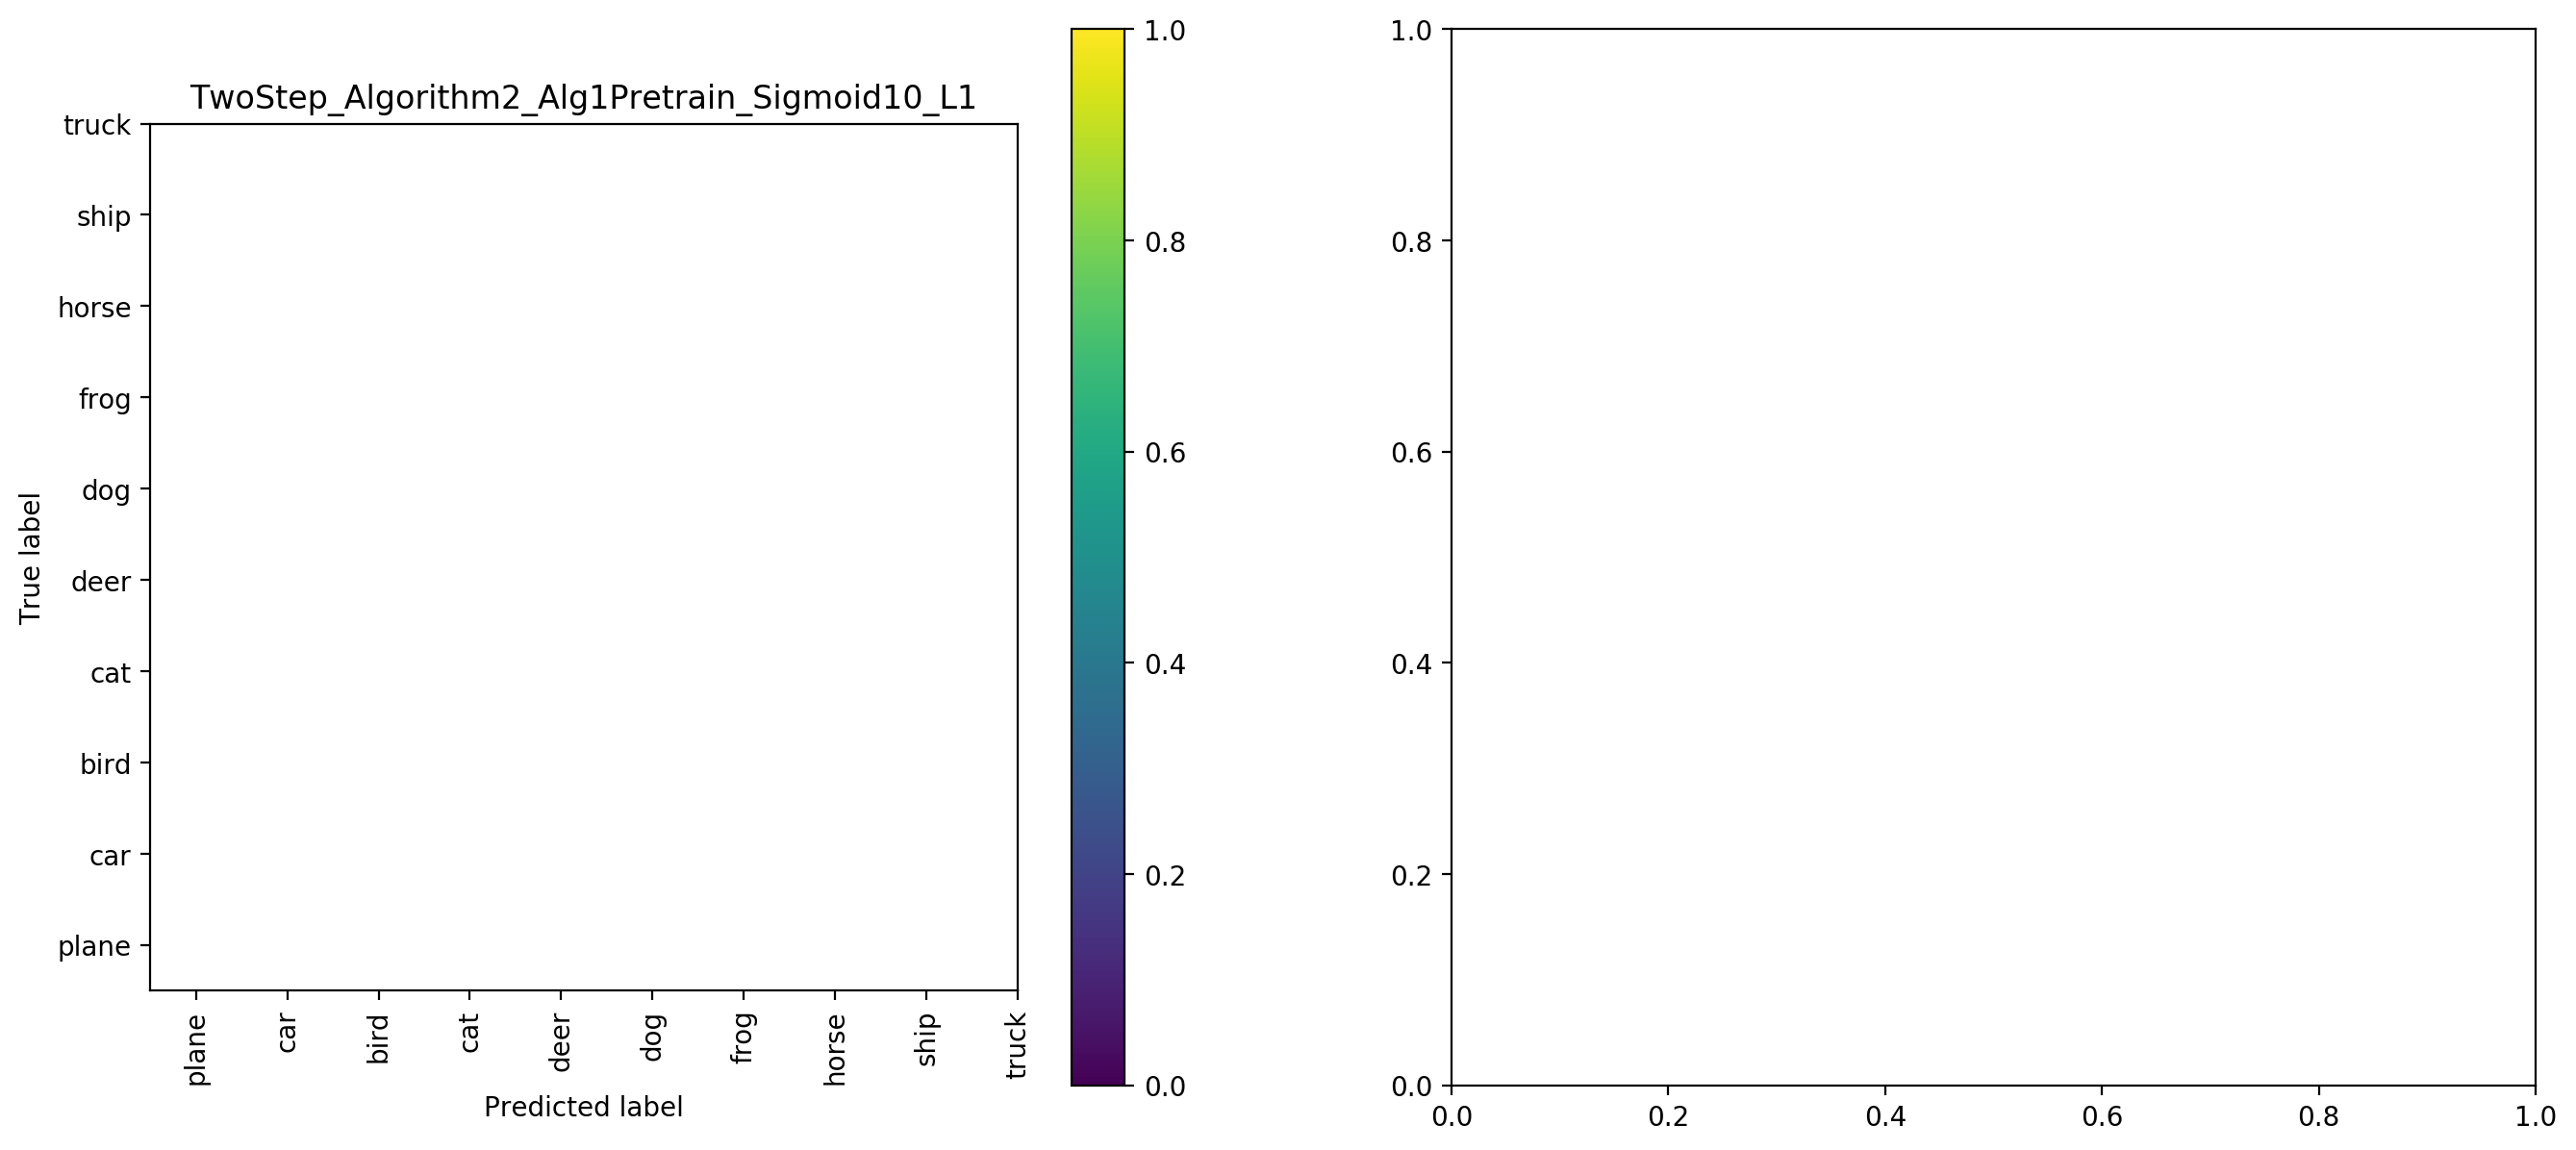

In [27]:
def get_weights(model):
    def get_channel_mask(c_mask):
        delta_scale = 0.1
        c_mask = torch.sigmoid(c_mask/delta_scale)
        return c_mask
#     return model.module.lmask.get_channel_mask()
    return get_channel_mask(model.module.lmask.mask)

exp_root = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/'
analysis_queue = [
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L1',
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L21',
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_Lmax',
    'TwoStep_Algorithm2_Sigmoid10_L1',
    'TwoStep_Algorithm2_Sigmoid10_Lmax',
    
    'TwoStep_Algorithm2_Sigmoid1e-3_L21',
    'TwoStep_Algorithm2_Sigmoid0.1_L1',
    'TwoStep_Algorithm2_Sigmoid0.1_L12',
]
analysis_queue = [exp_root+var for var in analysis_queue]
for item in analysis_queue:
    show_res(item, run_model = False)

## 0.01 delta

In [ ]:
def get_weights(model):
    def get_channel_mask(c_mask):
        delta_scale = 0.01
        c_mask = torch.sigmoid(c_mask/delta_scale)
        return c_mask
#     return model.module.lmask.get_channel_mask()
    return get_channel_mask(model.module.lmask.mask)

exp_root = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/reproduce_8_20/alg2_8_22/'
analysis_queue = [
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L1',
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_L21',
    'TwoStep_Algorithm2_Alg1Pretrain_Sigmoid10_Lmax',
    'TwoStep_Algorithm2_Sigmoid10_L1',
    'TwoStep_Algorithm2_Sigmoid10_Lmax',
    
    'TwoStep_Algorithm2_Sigmoid1e-3_L21',
    'TwoStep_Algorithm2_Sigmoid0.1_L1',
    'TwoStep_Algorithm2_Sigmoid0.1_L12',
]
analysis_queue = [exp_root+var for var in analysis_queue]
for item in analysis_queue:
    show_res(item, run_model = False)

# Model Weights Analysis 

In [ ]:
model_path = analysis_queue[0] + '/saved_model.pt'
model = resnet_cifar(depth=args_depth, num_classes=num_classes)
model = model.cuda()
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path))
w = model.module.lmask.get_channel_mask()

In [ ]:
w.shape

In [ ]:
w

In [ ]:
w = model.module.lmask.mask
def get_channel_mask(c_mask):
    delta_scale = 1
    c_mask = torch.sigmoid(c_mask/delta_scale)
    return c_mask
w = get_channel_mask(w)

In [ ]:
w